# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML

from operator import itemgetter  
from collections import OrderedDict
import pprint
import math

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize, StandardScaler, Normalizer, MinMaxScaler, minmax_scale, robust_scale
from sklearn.decomposition import PCA

from tslearn.piecewise import SymbolicAggregateApproximation

In [2]:
data = pd.read_csv('Data/training_1.csv')
data2 = pd.read_csv('Data/training_2.csv')
data3 = pd.read_csv('Data/test.csv')

data2.columns = data2.columns.str.replace(' ', '')

data['DATETIME'] = pd.to_datetime(data['DATETIME'], format='%d/%m/%y %H')
data2['DATETIME'] = pd.to_datetime(data2['DATETIME'], format='%d/%m/%y %H')
data3['DATETIME'] = pd.to_datetime(data3['DATETIME'], format='%d/%m/%y %H')

# Process attack flags
data2.loc[data2['ATT_FLAG'] < 0, 'ATT_FLAG'] = 0
data3['ATT_FLAG'].fillna(0, inplace=True)

data = data.drop(columns=['ATT_FLAG', 'DATETIME'])
data2 = data2.drop(columns=['DATETIME'])
data3 = data3.drop(columns=['DATETIME'])
all_features = data.columns

for feature in all_features:
    data[feature] = data[feature].astype('float')
    data2[feature] = data2[feature].astype('float')
    data3[feature] = data3[feature].astype('float')
    
VALUE_FOR_ANOMALITY_DETECTED = 1
VALUE_FOR_NORMALITY_DETECTED = 0

### Group function that can be used with different prediction methods

In [24]:
# This method groups attacks if they are close (max threshold hours) apart as one attack
def group_attacks(attacks, threshold=25):
    for i, row in enumerate(attacks):
        if row == 1:
            # Special case that an attack is at the end of the available list
            if i+threshold >= len(attacks):
                threshold = len(attacks) - i - 1
                
            for check in range(i+threshold,i,-1):
                if attacks[check] == 1:
                    for fill in range(check, i, -1):
                        attacks[fill] = 1


# Familiarization task – 1 A4 

Answer the following questions:
* What kinds of signals are there?
* Are the signals correlated? Do they show cyclic behavior?
* Is predicting the next value in a series easy or hard? Use any method from class.

Visualize these types, the presence or absence of correlation, and the performance of prediction.

### What kinds of signals are there?

The data is categorized as follows:
* T Are the water tanks
    * L_Tx stands for the water level in the tanks (float)
* PU Are the pumps
    * F_PUx(x) stands for the flow through the pumt(float)
    * S_PUx(x) stands for the status of the pump (on (1) / off (0)) (binary)
* V is a valve
    * F_Vx stands for flow through the valve (float) 
    * S_Vx stands for the status of the valve (open (1) / closed (0)) (binary)
* J are junctions
    * P_Jxxx stands for the pressure in the junction (float)

* ATT_FLAG is the attack flag (normal (0) / attack (1) / unknown (-999))

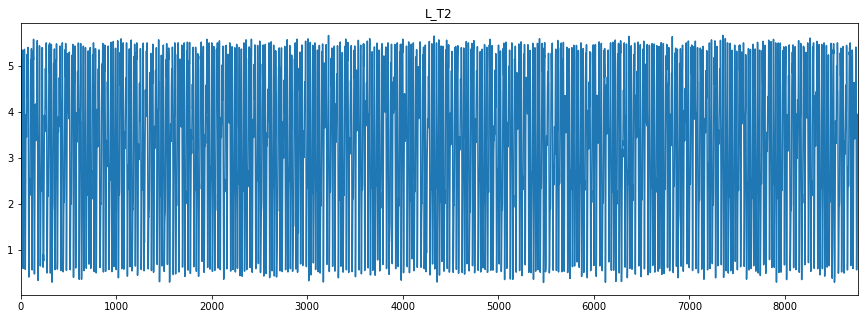

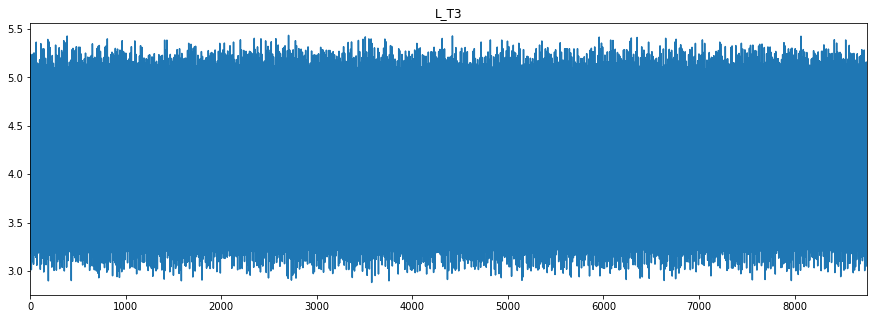

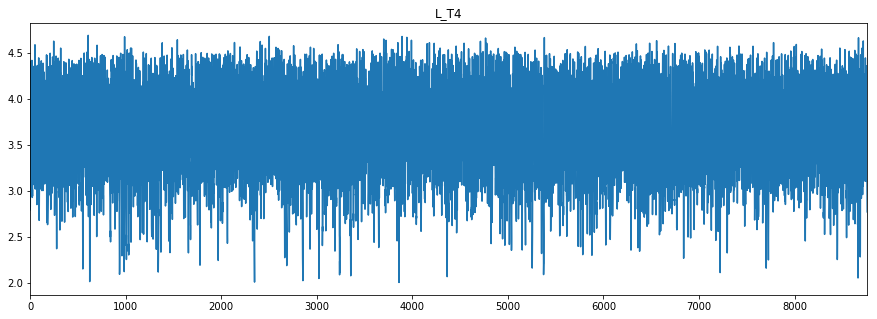

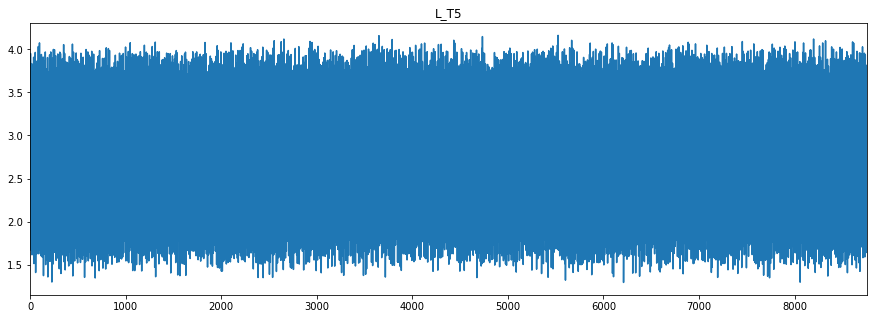

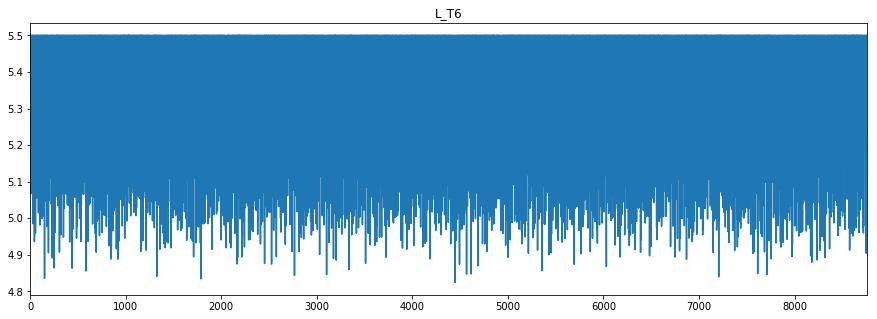

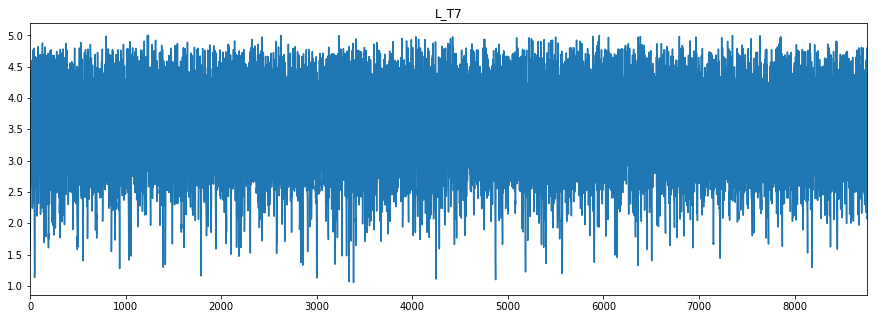

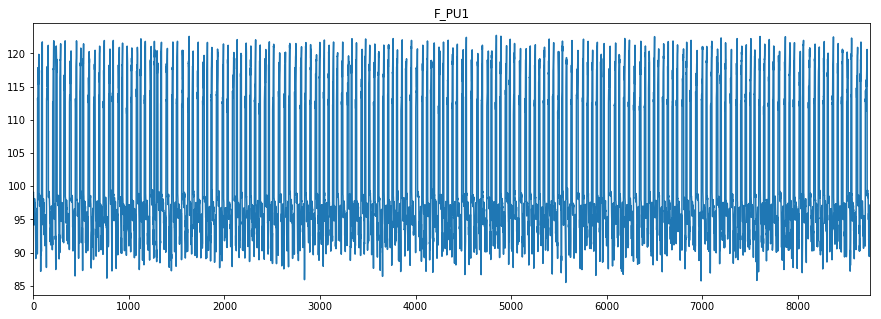

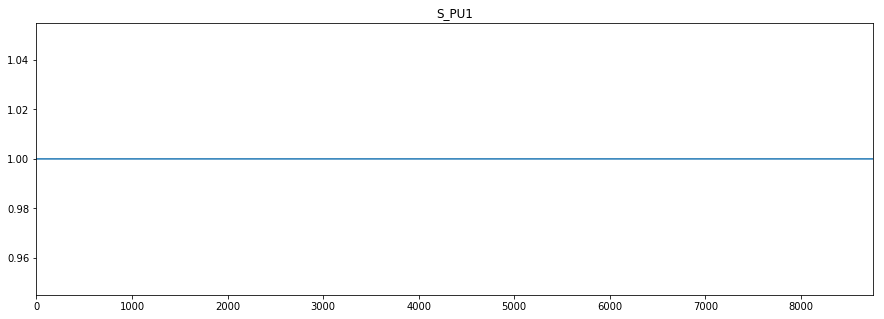

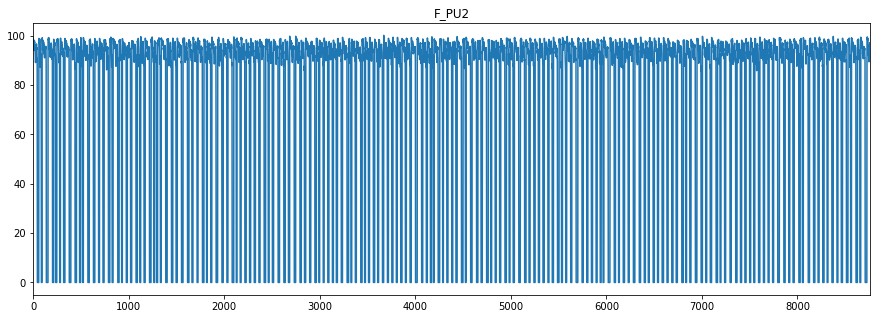

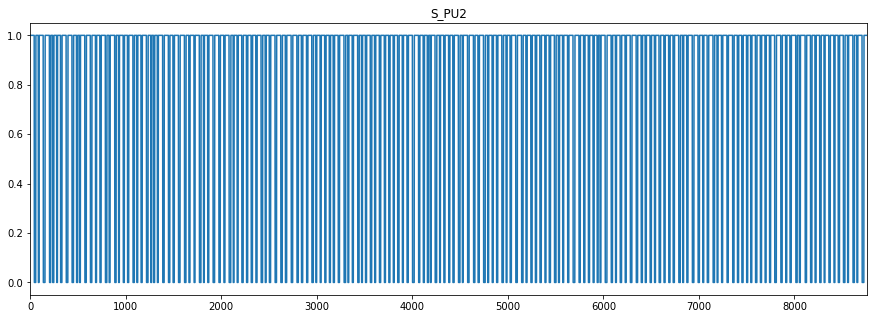

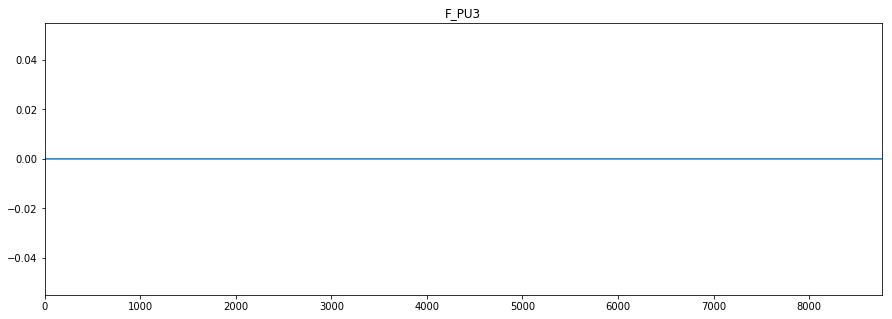

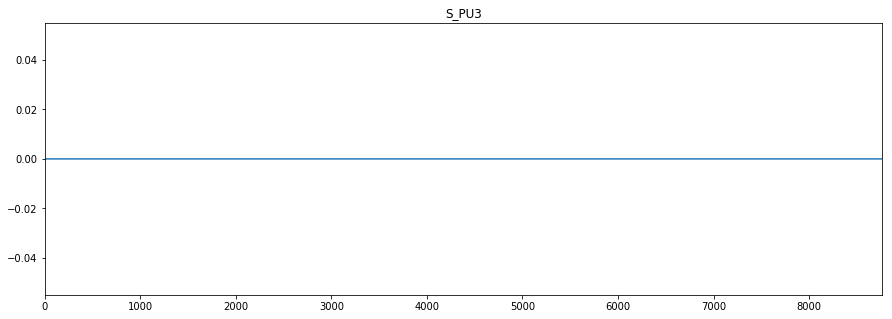

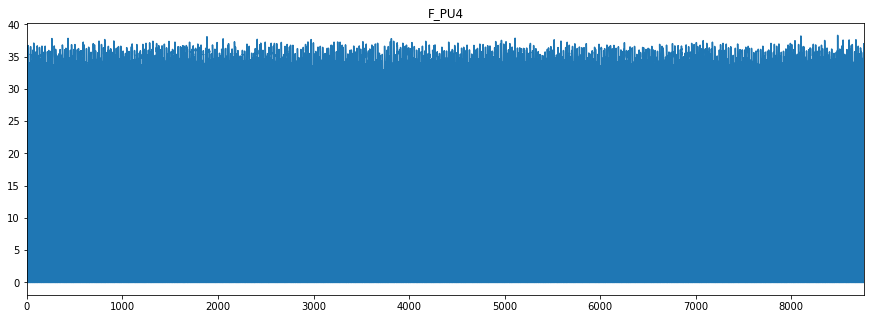

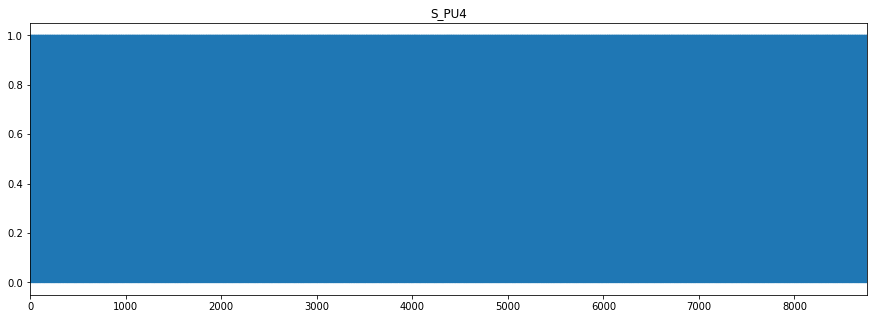

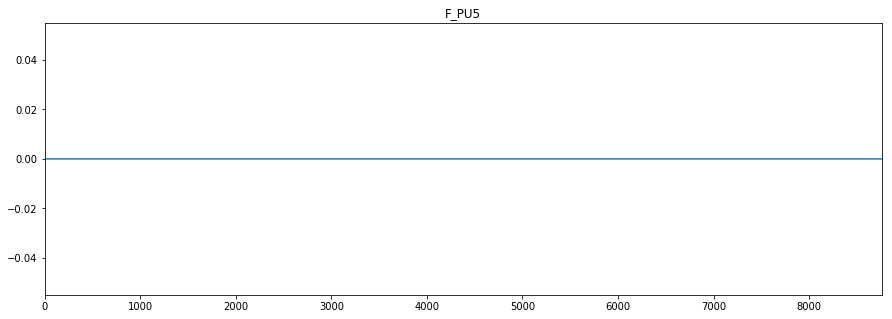

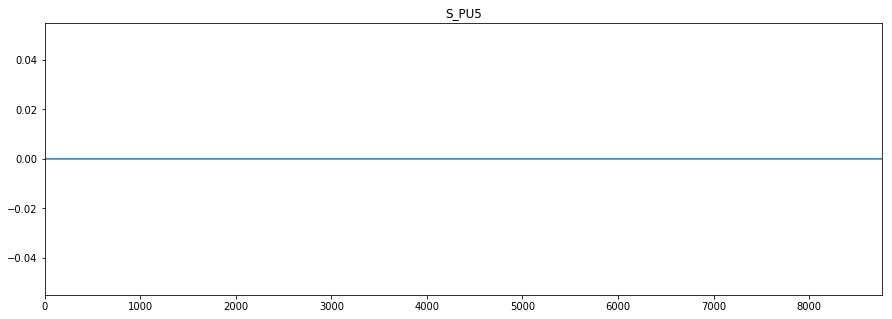

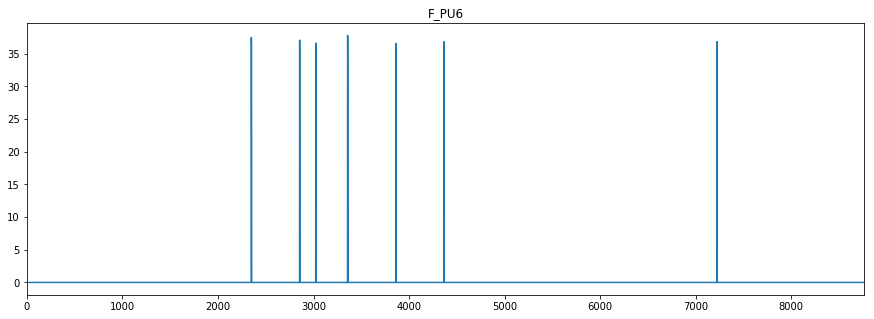

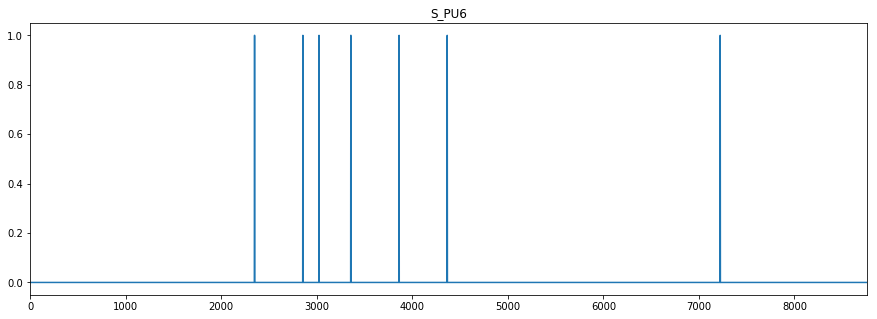

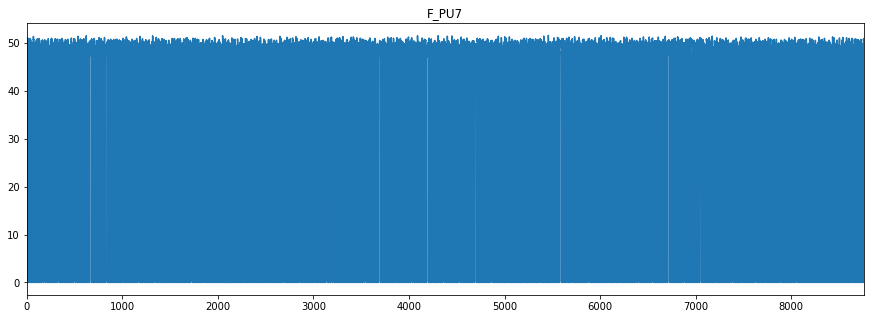

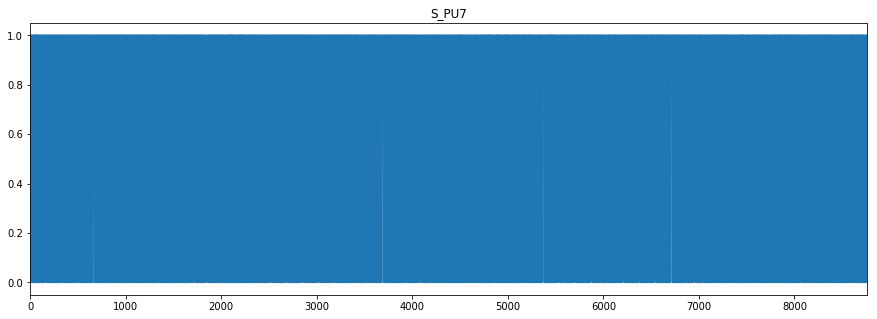

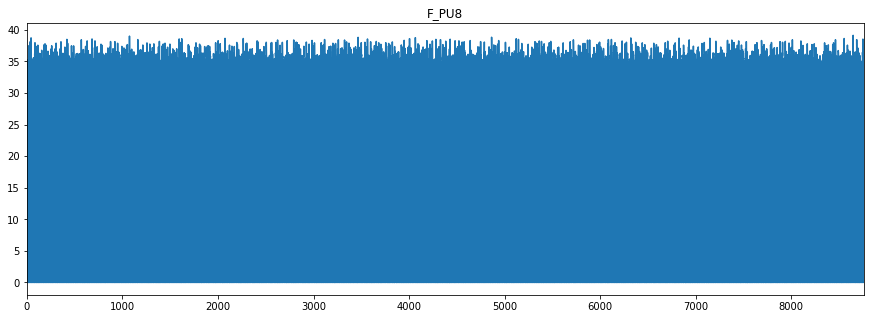

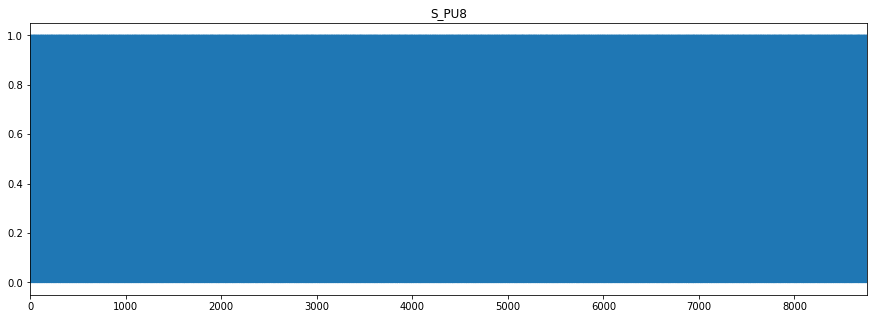

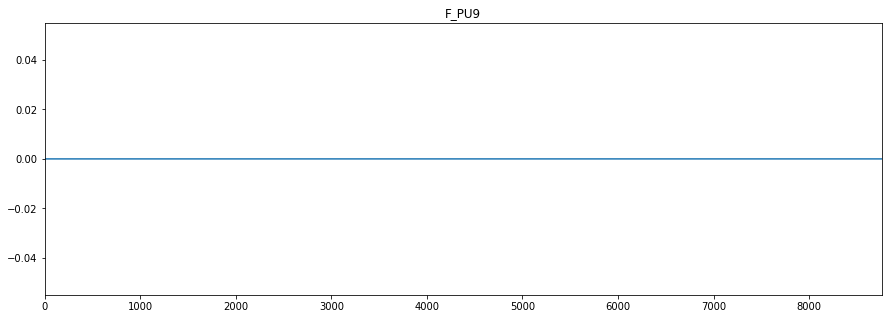

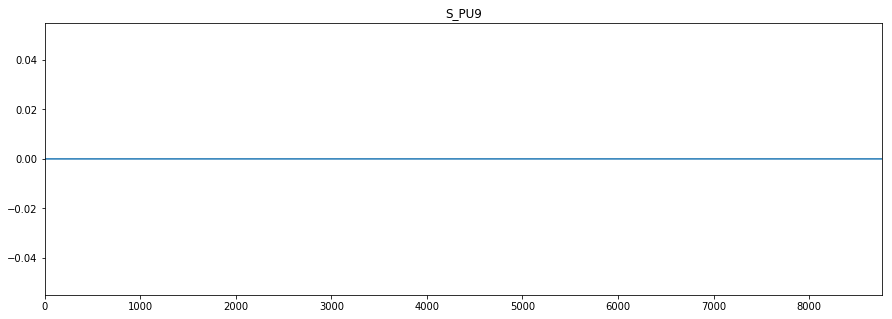

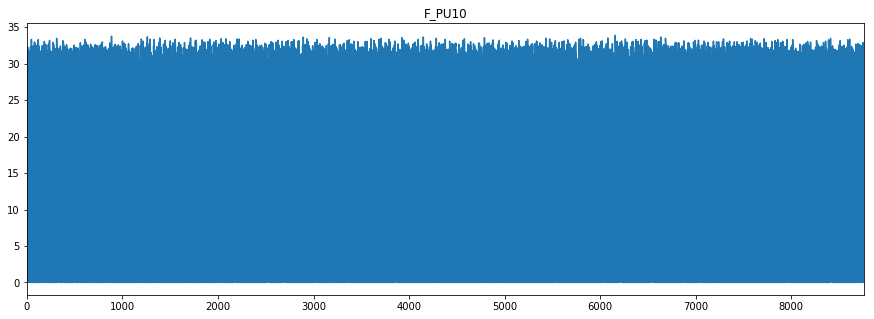

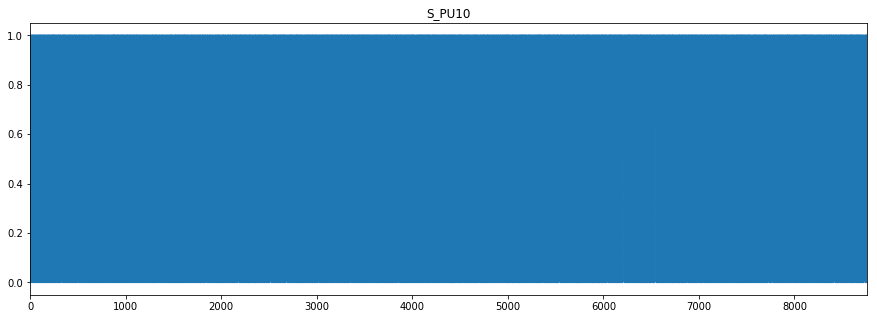

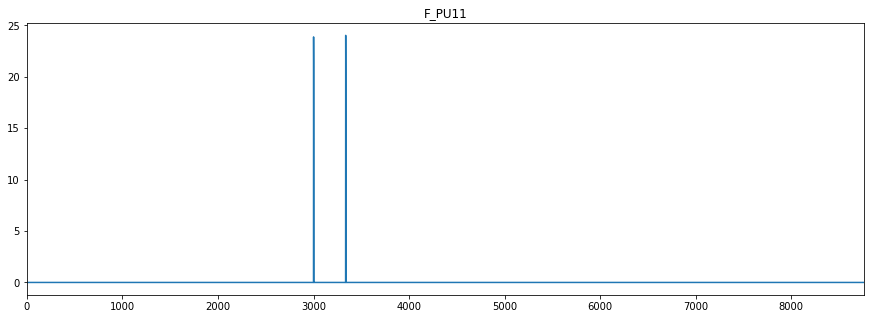

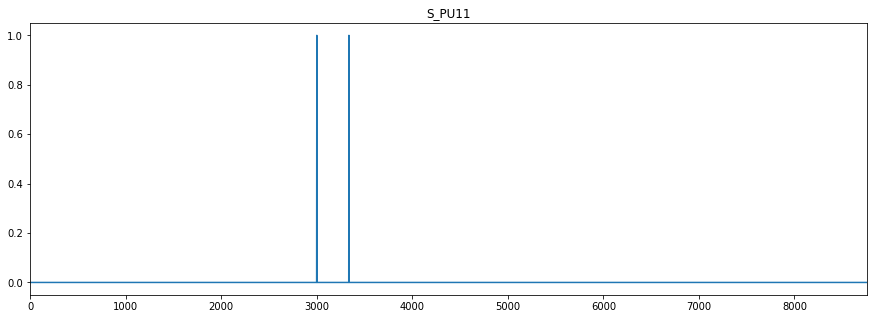

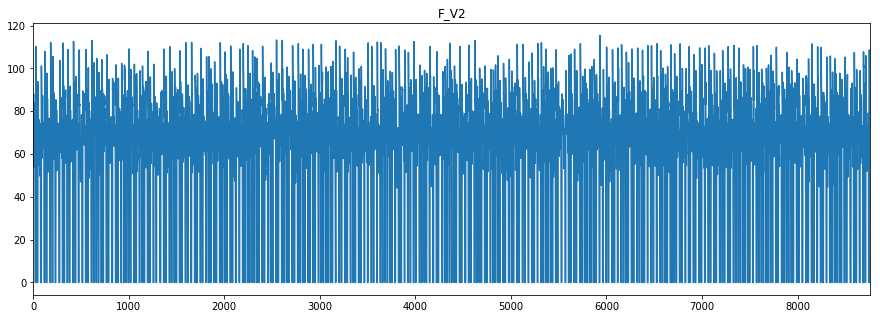

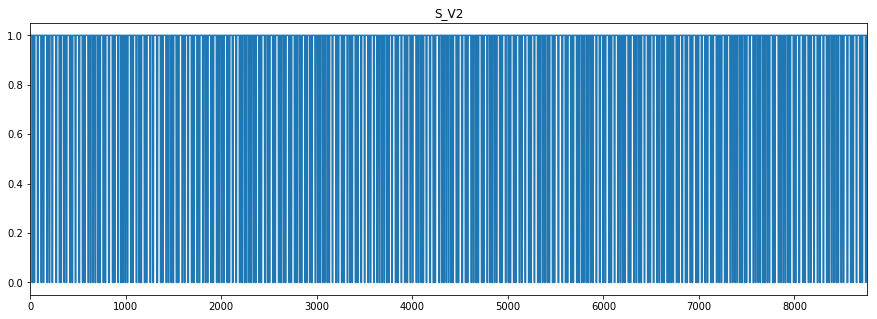

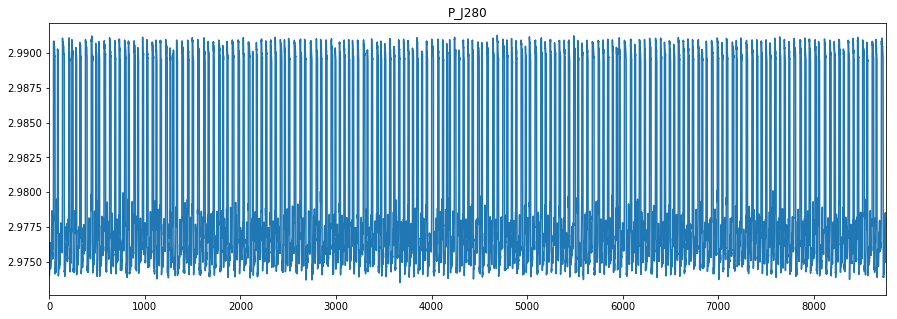

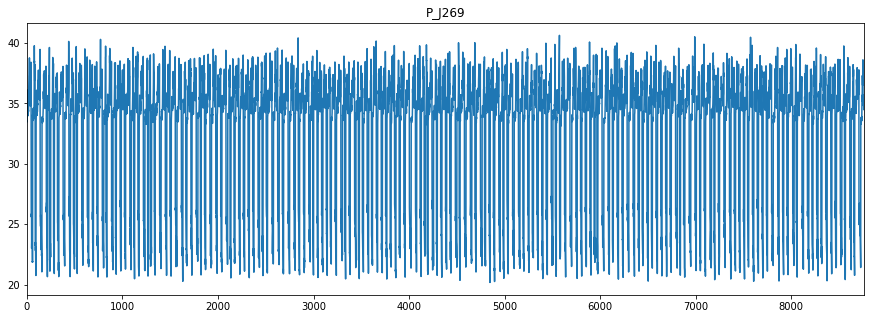

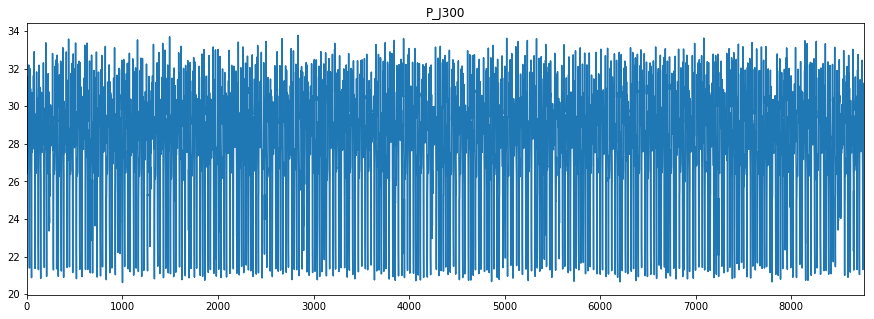

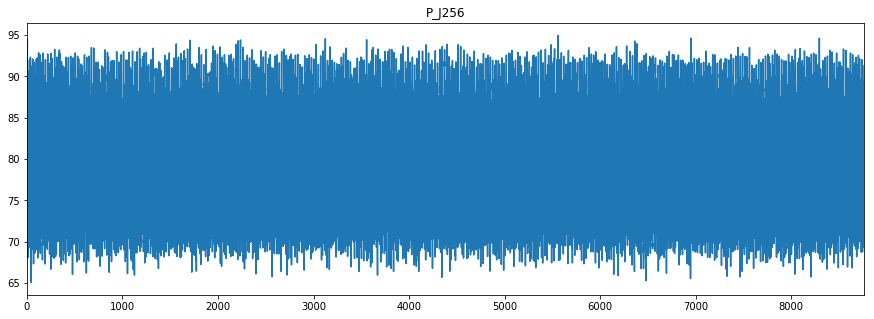

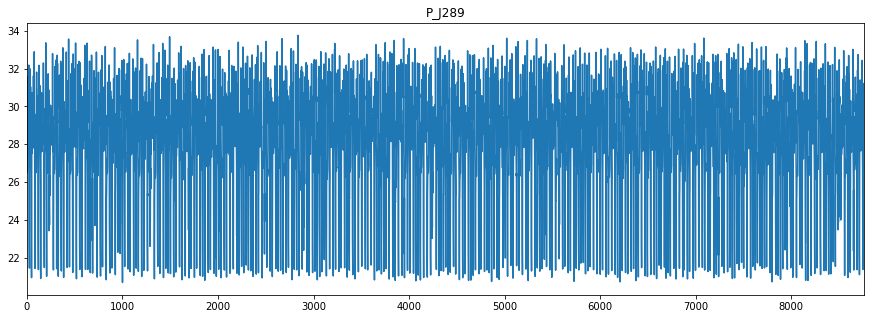

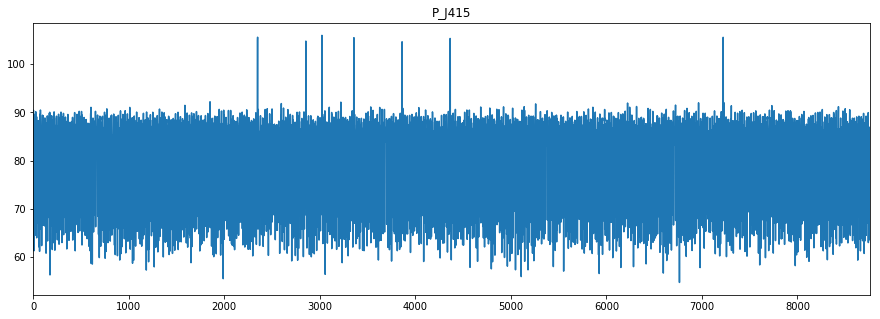

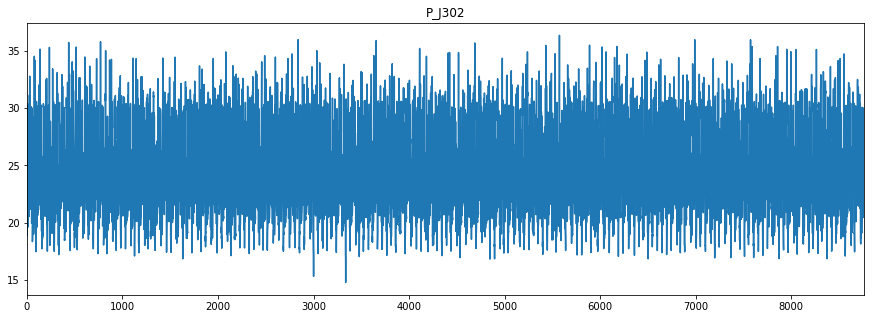

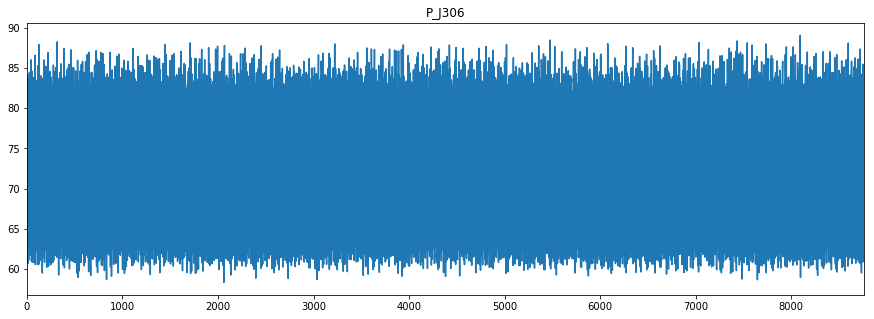

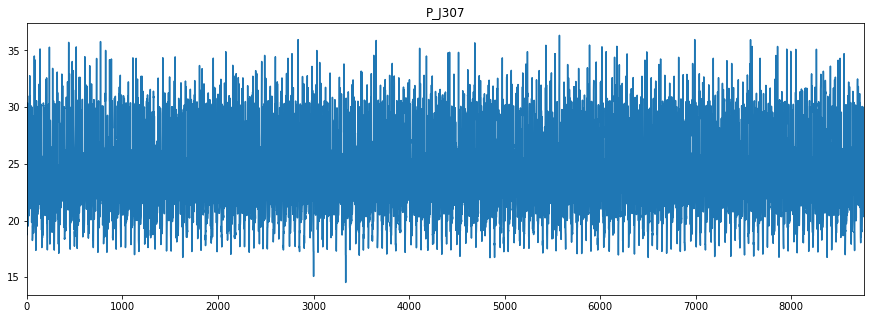

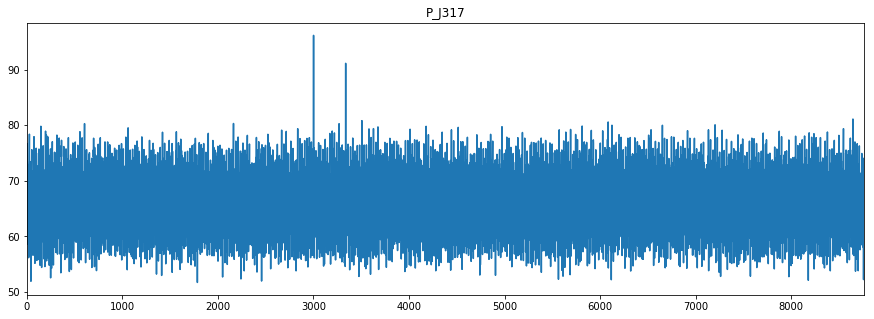

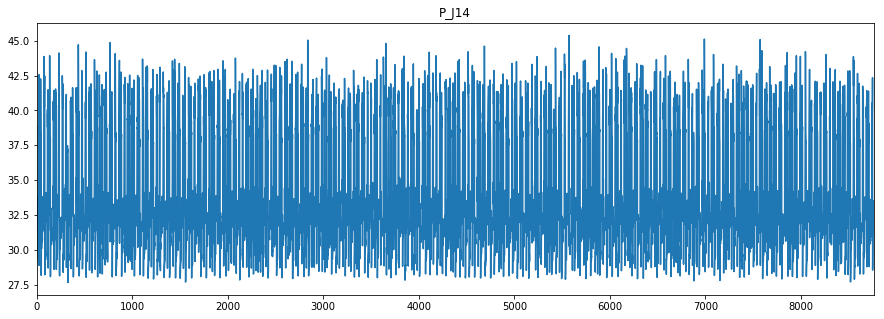

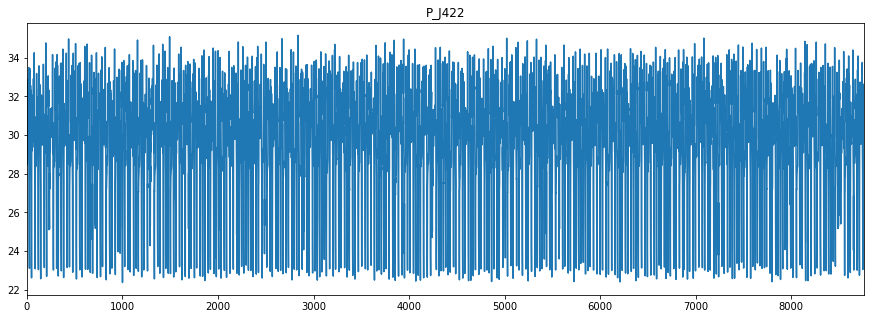

In [3]:
for i, feature in enumerate(data.columns[1:]):
    plt.title(feature)
    data[feature].plot(figsize=(15,5))
    plt.show()

### Are the signals correlated? Do they show cyclic behavior?

As one can see in the correlation heatmap below there is some data correlated

The interesting ones for now are the correlations between actuators and sensors (not from the same machine). Taking the lowest and highest correlations <-1:-0.75> and <0.75:1> from the subset described gives some interesting plots. Although not all the time deltas are equal there is a clear cycle visible between waterlevels/flows/pressure and when actuators are activated

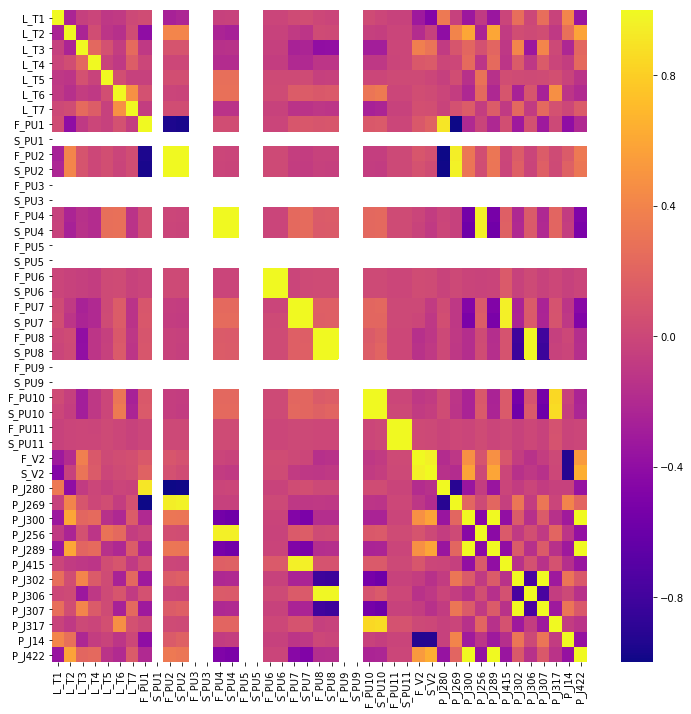

In [4]:
f, ax = plt.subplots(figsize=(12, 12))
corr = data.corr()
sns.heatmap(data.corr(), cmap='plasma')
plt.show()

### Print the Features (sensors) which are correlating the most

In [5]:
cr_series = corr.unstack().sort_values(ascending=False).drop_duplicates().dropna()
cr = pd.DataFrame(cr_series)
cr['high'] = cr_series.between(-0.75, 0.75, inclusive=True)
cr = cr[cr['high']==False].drop('high', axis='columns').reset_index().set_axis(['x', 'y', 'correlation'], axis='columns', inplace=False)

# Filter correlations with itself
cr = cr[cr['x'] != cr['y']]

# Filter correlations between status and flow of same machine
cr = cr[cr['x'].str.split('_', expand=True)[1] != cr['y'].str.split('_', expand=True)[1]]

# Most interesting are the correlatiosn between sensors and actuators
cr = cr[(cr['x'].str.split('_', expand=True)[0] =='S') | (cr['y'].str.split('_', expand=True)[0]=='S')]

display(HTML(cr.to_html()))


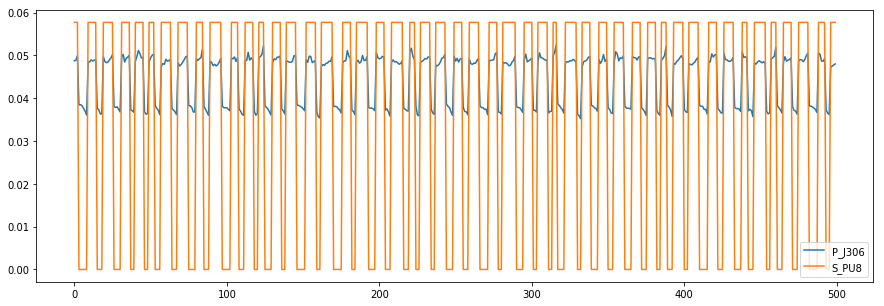

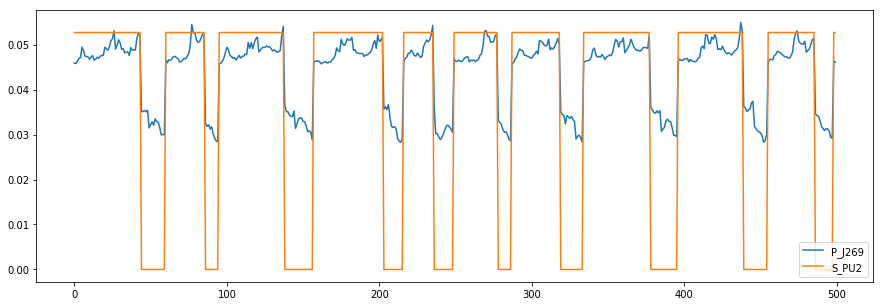

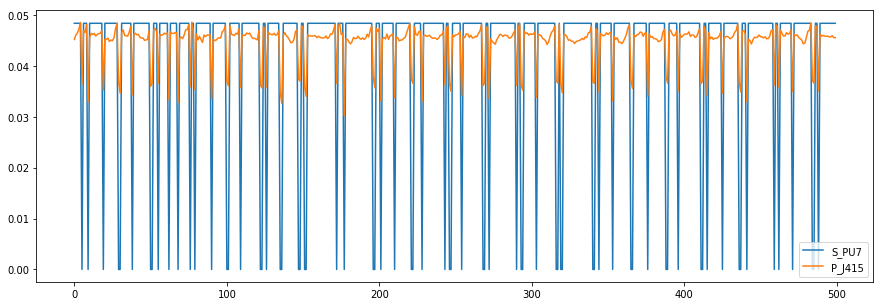

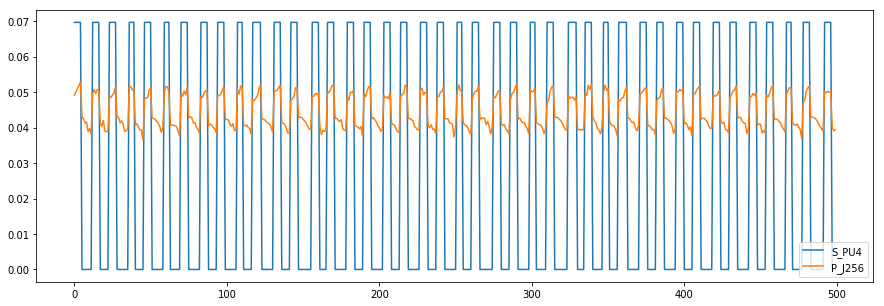

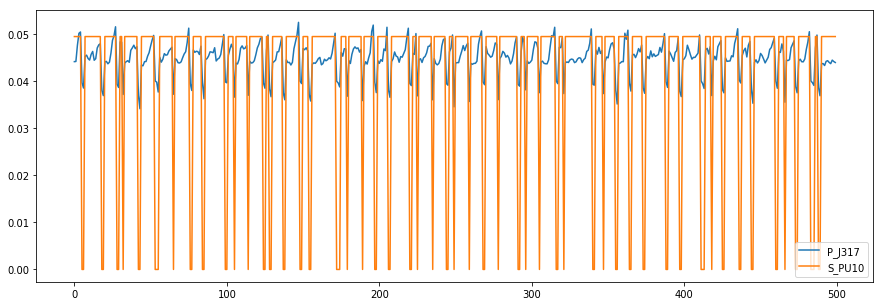

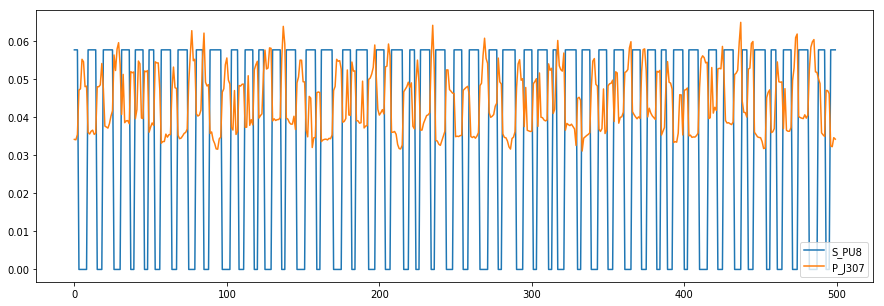

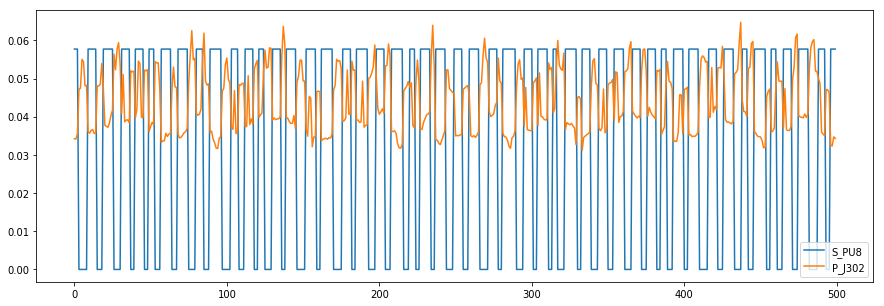

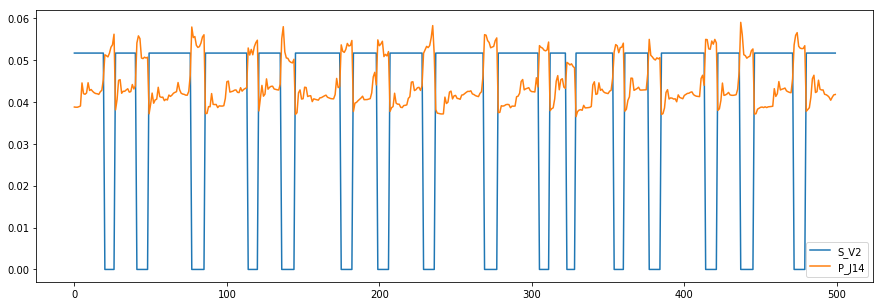

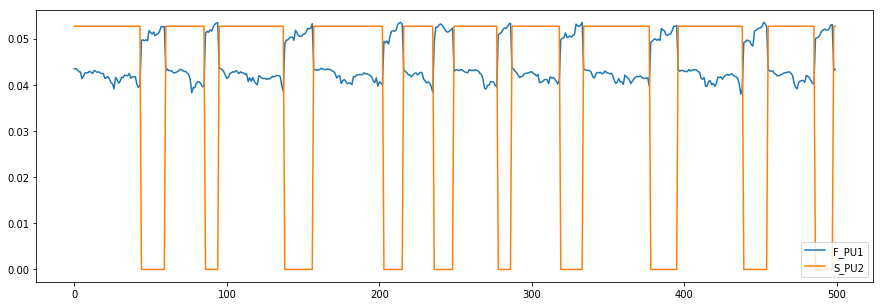

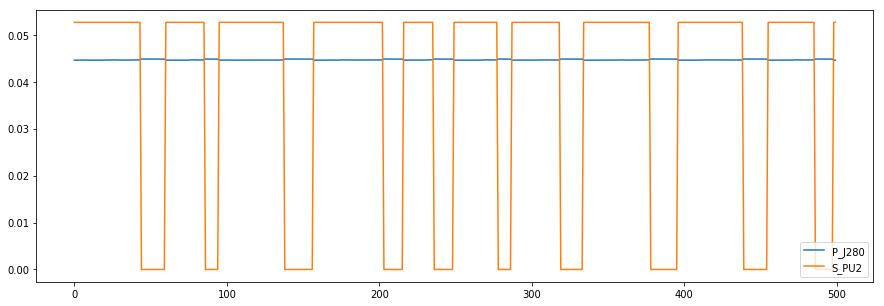

In [6]:
train_data = data
use_n_values = 500
for row in cr.itertuples():
    plt.figure(figsize=(15,5))
    plt.plot(normalize(train_data[row[1]][:use_n_values].values.reshape(1, -1)).reshape(-1, 1), label=row[1])
    plt.plot(normalize(train_data[row[2]][:use_n_values].values.reshape(1, -1)).reshape(-1, 1), label=row[2])
    plt.legend(loc = 'lower right')
    plt.show()

### Is predicting the next value in a series easy or hard? Use any method from class.

Using Auto regressive (AR)

Test MSE: 0.036


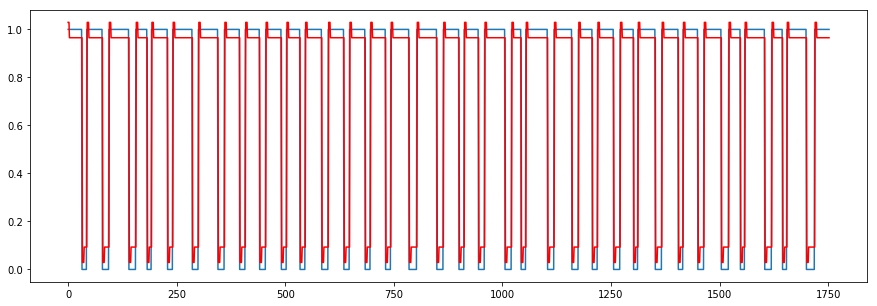

In [7]:
def predict(coef, history):
    #initialize on constant
    yhat = coef[0]
    # sum( phi(i) * X(t-1)) for i=1 till i=p
    for i in range(1, len(coef)):
        yhat += coef[i] * history[-i]
    return yhat


signal = 'S_PU2'
train_size = int(len(data)*0.8)
train = data[signal][0:train_size]
test = data[signal][train_size:].reset_index(drop='true')
predictions = list()

# Order for AR
p=5
#Create and train model
model = AR(train)
model_fit = model.fit(p)
# Get coefficients (+ constant)
coef = model_fit.params
# Retreive last p points
history = train[-p:].to_list()

# Predict same amount as values as availale in test set
for t in range(len(test)):
    # predict next value and add to list
    yhat = predict(coef, history)
    predictions.append(yhat)
    
    # add original point to history for next prediction
    obs = test[t]
    history.append(obs)
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.figure(figsize=(15,5))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# ARMA task 

Learn an autoregressive moving average model for at least 5 individual sensors (pick them in a sensible way!). Most statistical packages (statsmodels in Python) contain standard algorithm for fitting these models from training data. Use autocorrelation plots in order to identify the order of the ARMA models. The parameters can be determined using Akaike’s Information Criterion (AIC) or another model selection method. Note that there exists a wide range of ARMA variants; you only have to use the basic model. 

Decide how to set the detection threshold sensibly. Study some of the anomalies detected anomalies. What kind of anomalies can you detect using ARMA models? Which sensors can be modeled effectively using ARMA?

TODOS:
* Look at picking sensor data (now based on attack sheet)
* use autocorrelation to indetify order
* determine useing AIC
* Decide on threshold for attack
* write about this assignment
    

### Autocorrelation plots

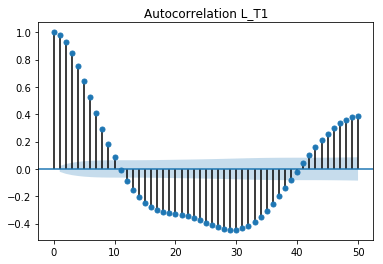

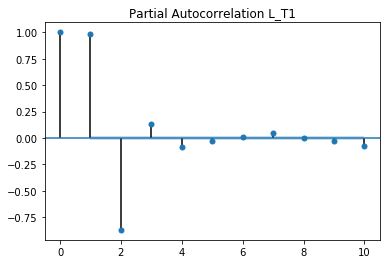

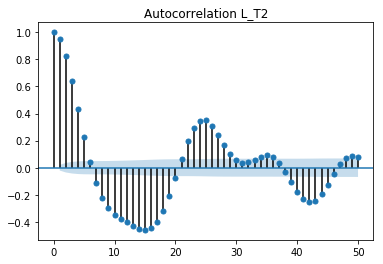

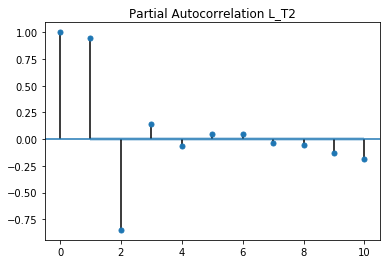

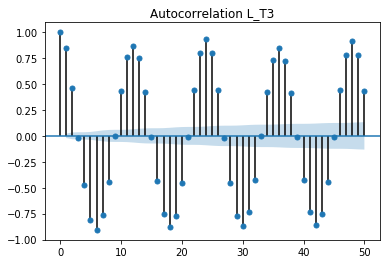

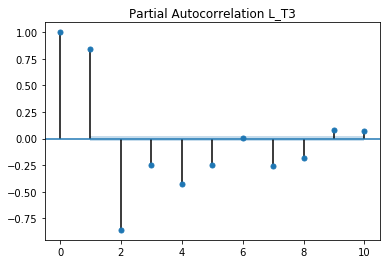

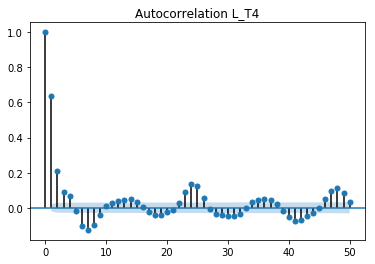

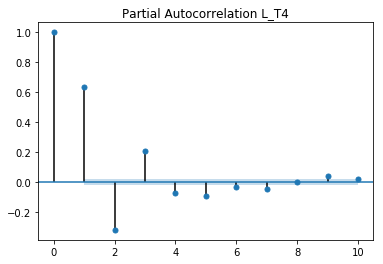

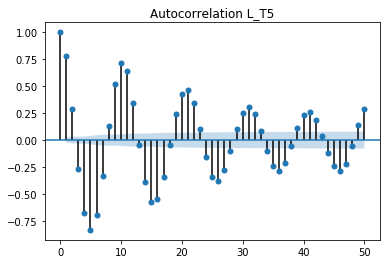

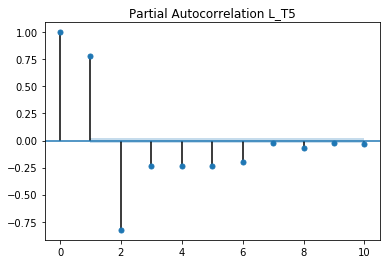

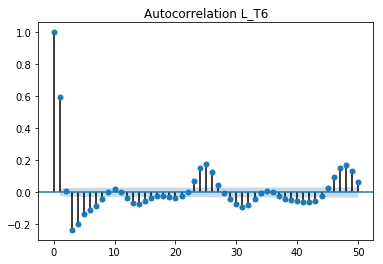

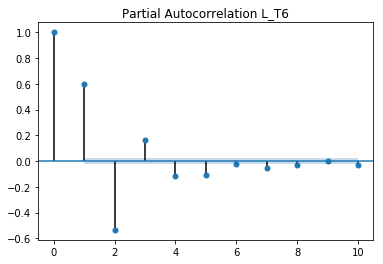

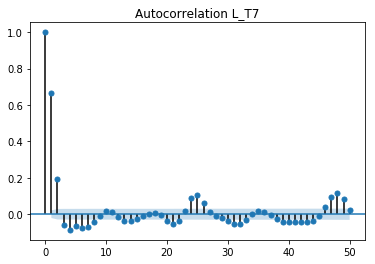

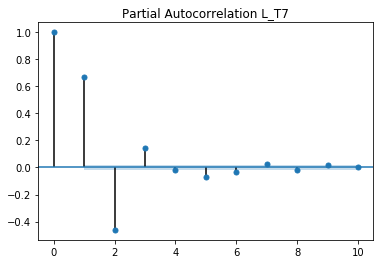

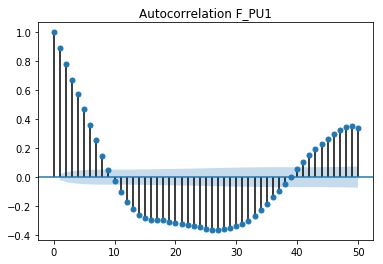

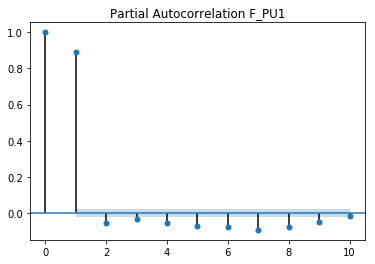

/home/roy/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:476: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[:nlags + 1] / avf[0]


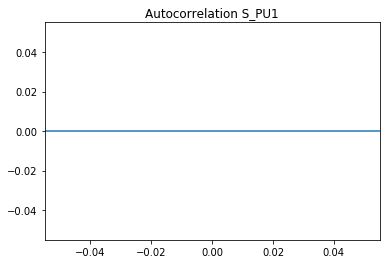

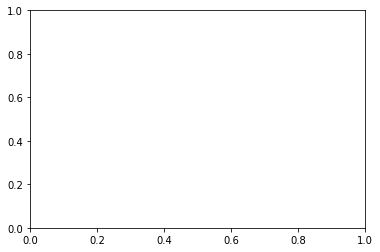

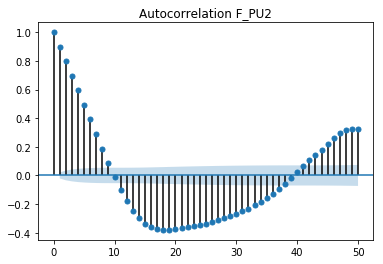

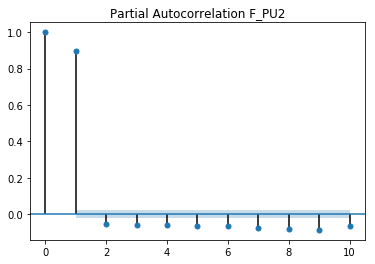

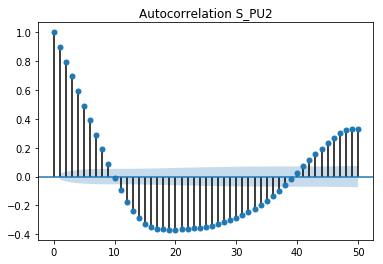

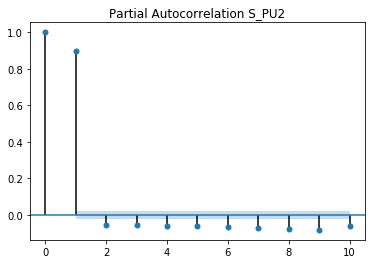

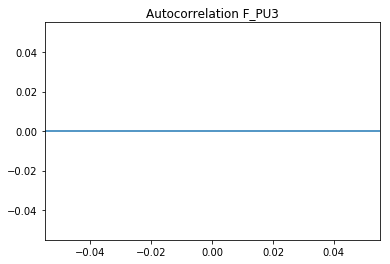

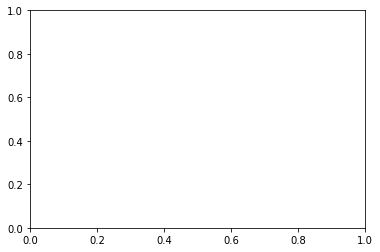

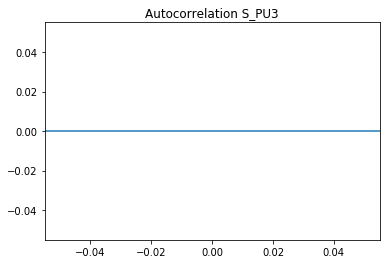

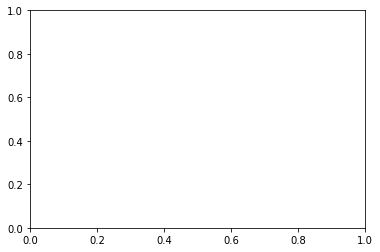

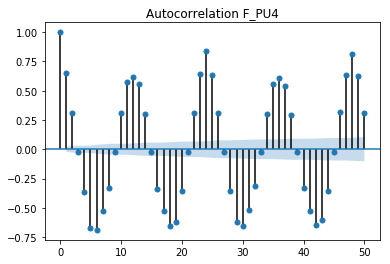

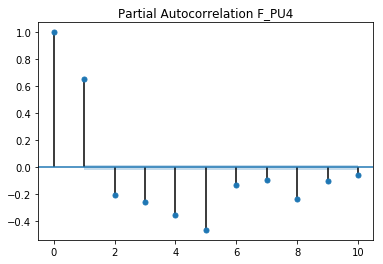

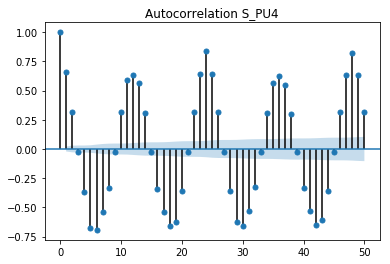

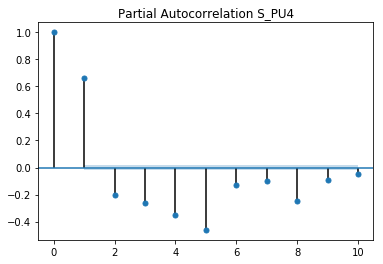

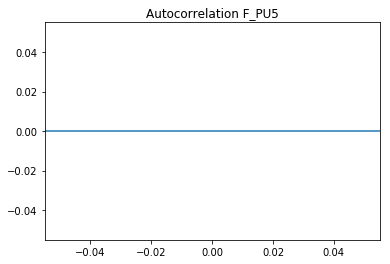

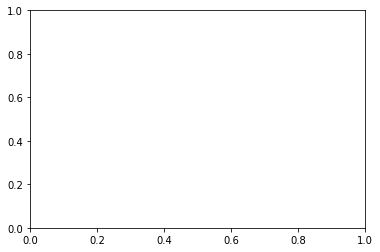

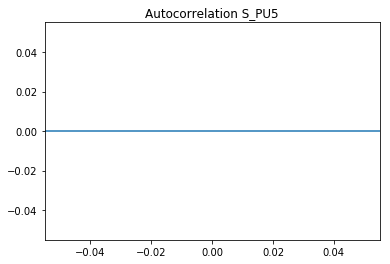

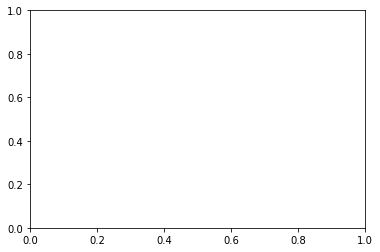

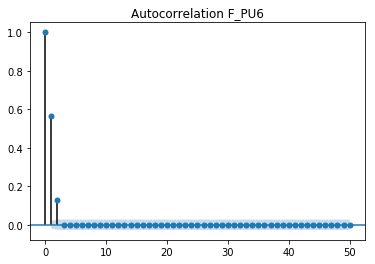

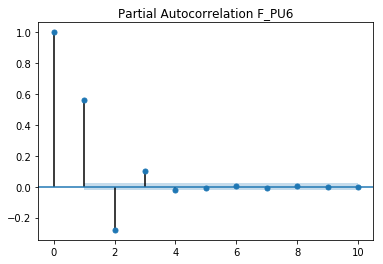

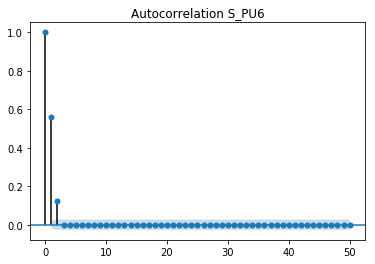

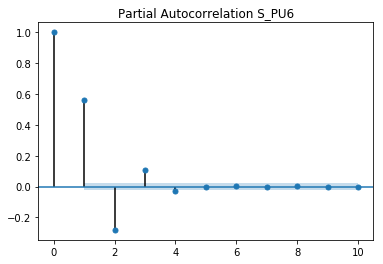

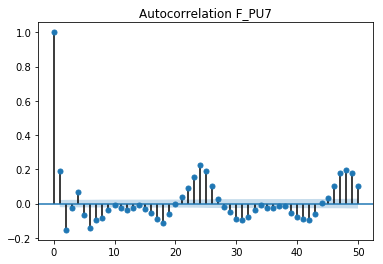

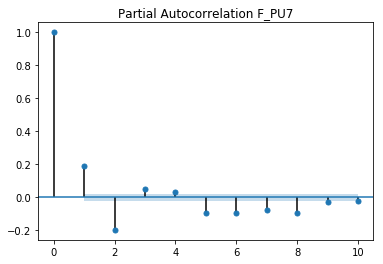

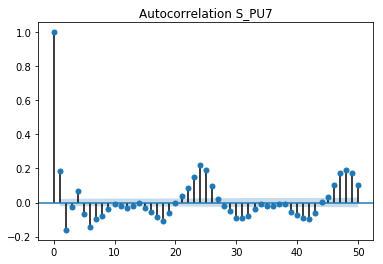

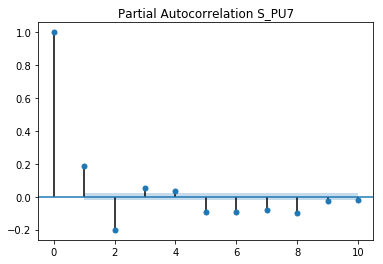

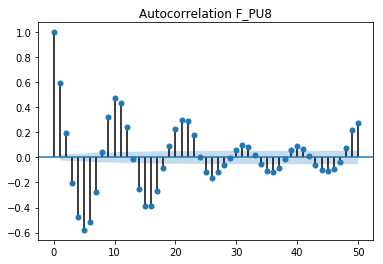

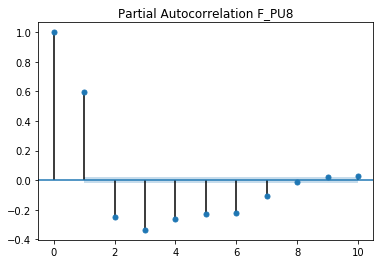

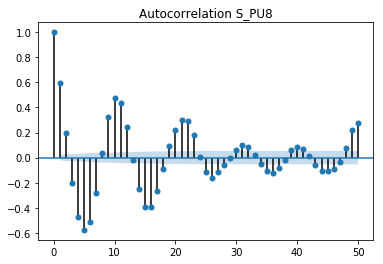

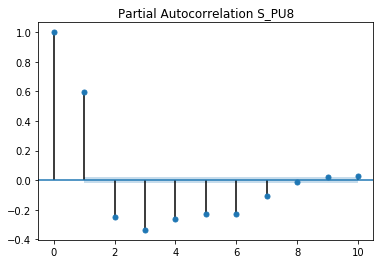

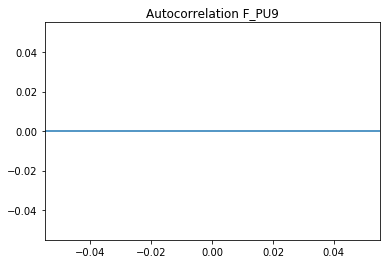

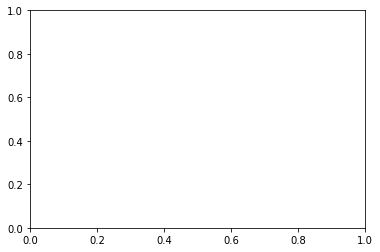

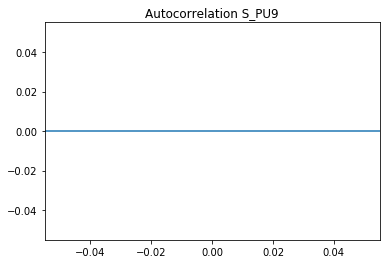

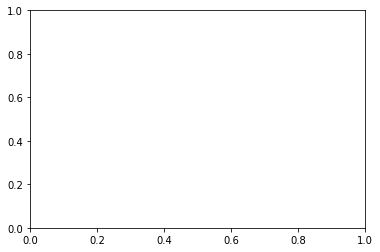

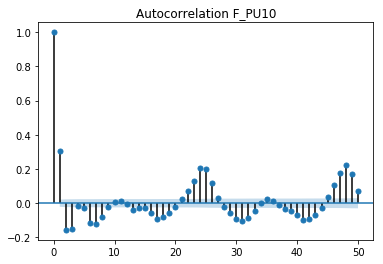

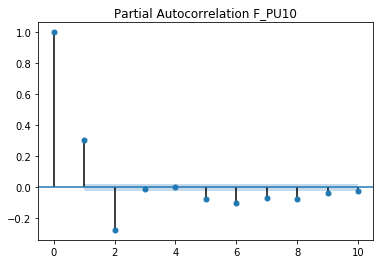

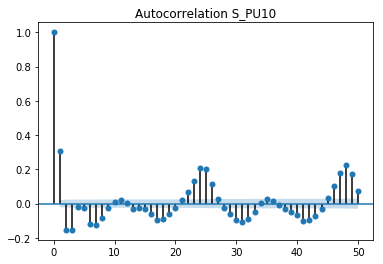

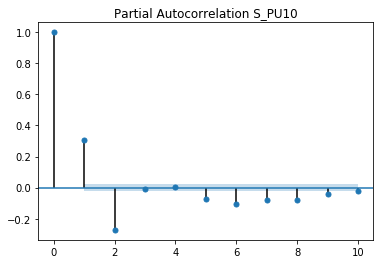

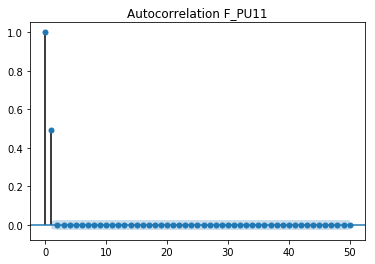

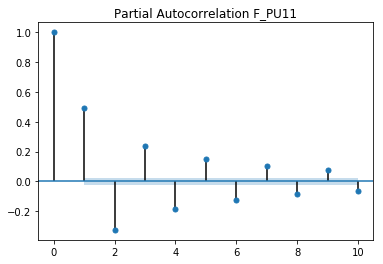

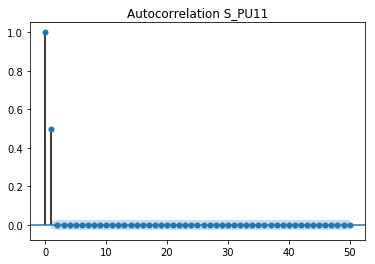

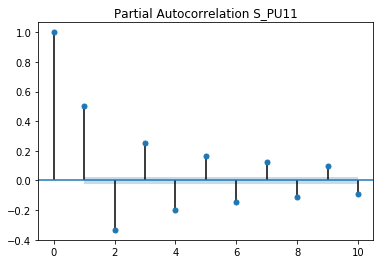

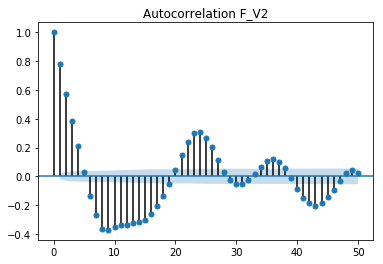

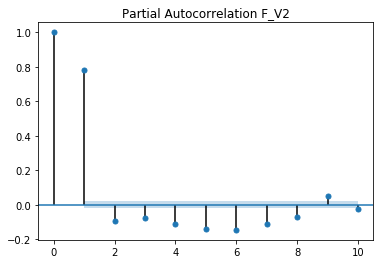

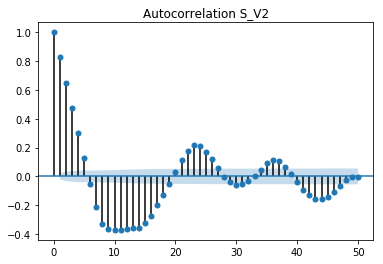

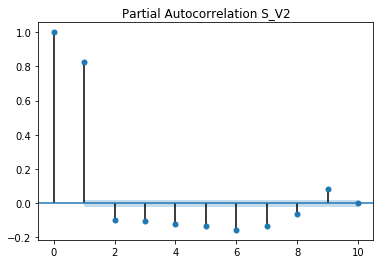

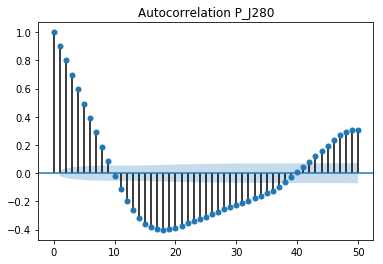

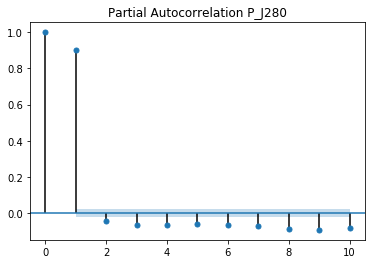

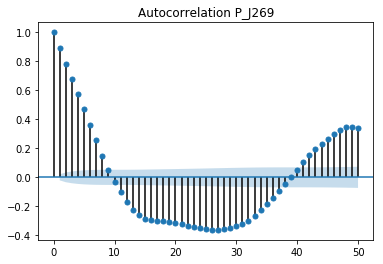

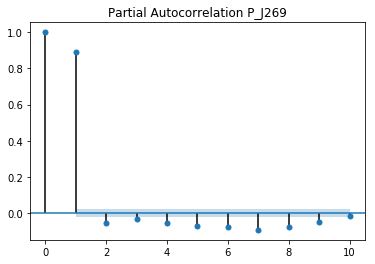

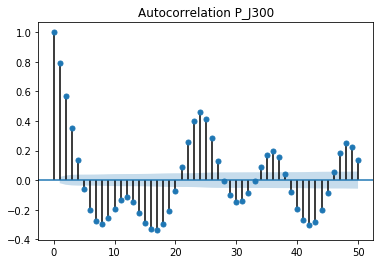

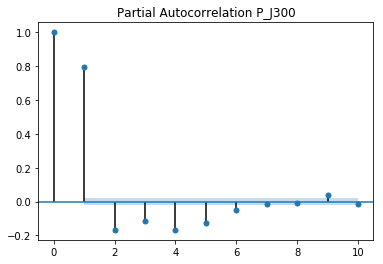

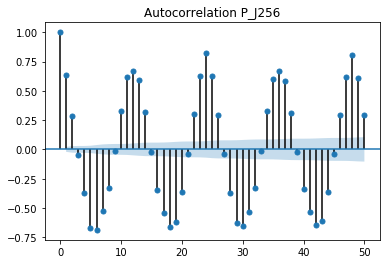

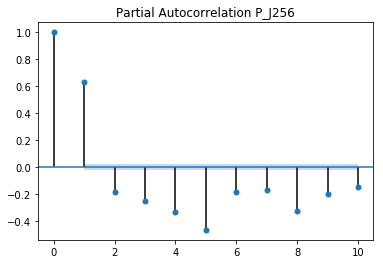

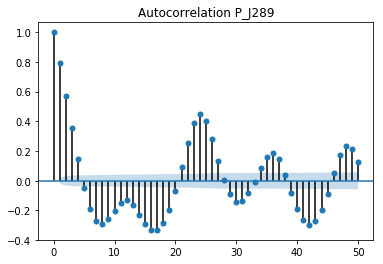

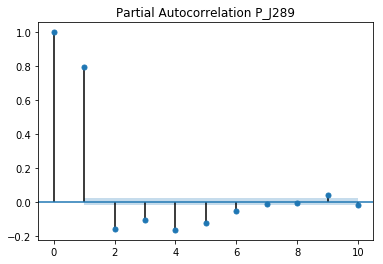

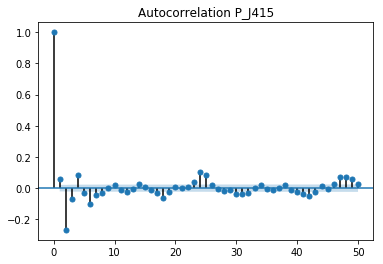

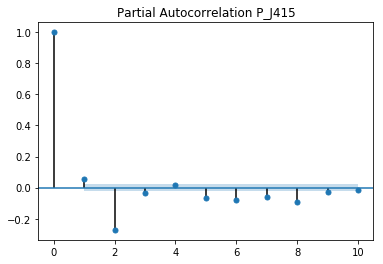

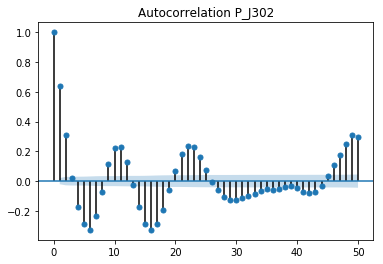

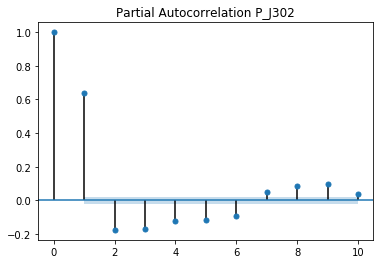

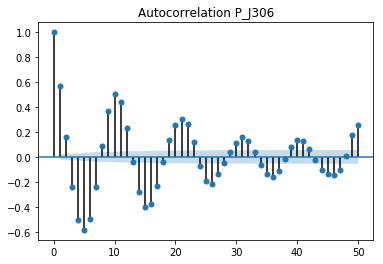

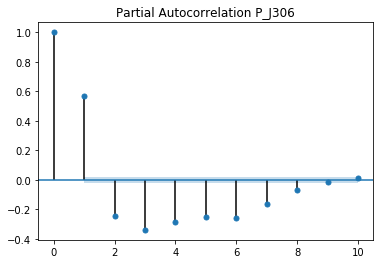

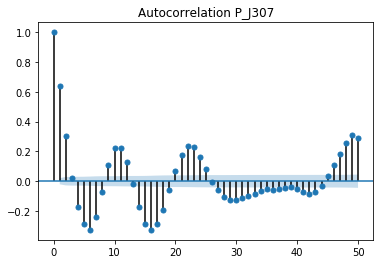

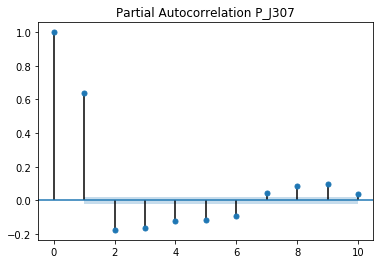

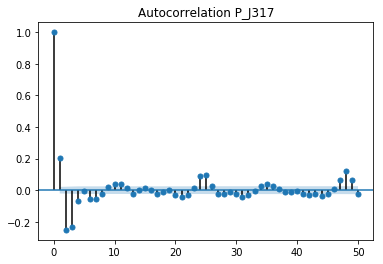

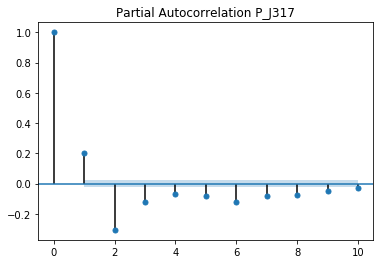

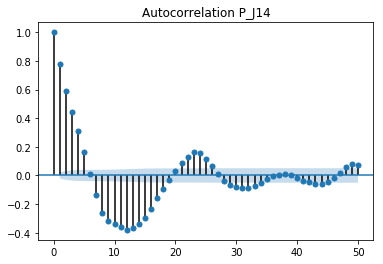

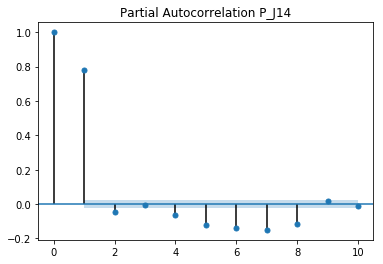

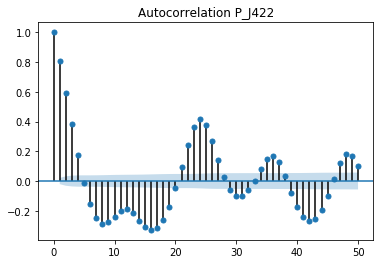

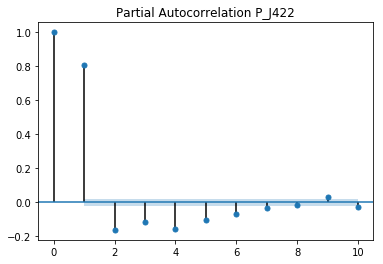

In [8]:
train_data = data
for feature in all_features:
    try:
        plot_acf(train_data[feature], lags=50)
        plt.title(f"Autocorrelation {feature}")
        plt.show()

        plot_pacf(train_data[feature], lags=10)
        plt.title(f"Partial Autocorrelation {feature}")
        plt.show()
    except Exception as e:
        pass

### Parameter estimation

In [9]:
def AIC(data):
#     initialize with lowest parameter and highest score
    best_p=1
    best_q=0
    best_score = float("inf")

#     Set the range in a way that the computing time is still acceptable (prox. 8 hours for this range)
    for i in range(1,9):
        for j in range(0,6):
            try:
                model = ARMA(data, (i,j))
                model_fit = model.fit(disp=0)
                score = model_fit.aic
                if score < best_score:
                    best_score = score
                    best_p = i
                    best_q = j
            except Exception as e:
                    break
    return best_score, best_p, best_q

In [10]:
train_data = data
try:
    arma_param = pd.read_csv('Data/arma_param.csv')
except:
    # If the results of a previous run are not available, we have to calculate them. 
    # This operation is very time consuming, so do not do it if it is not necessary!
    arma_param = pd.DataFrame(columns=['feature','p','q', 'score'])
    for col in all_features:
        score, p, q = AIC(train_data[col][:2000])
        arma_param = arma_param.append({'feature':col,'p':p,'q':q,'score':score}, ignore_index=True)
    arma_param = arma_param.reset_index(drop=True).set_index('feature')
    arma_param.to_csv('Data/arma_param.csv')
print(arma_param)
    

   feature  p  q         score
0     L_T1  8  5 -3.058122e+03
1     L_T2  7  4 -3.573662e+02
2     L_T3  8  4 -2.059657e+03
3     L_T4  5  2  1.828297e+03
4     L_T5  4  4 -2.133071e+02
5     L_T6  1  4 -2.986272e+03
6     L_T7  4  5  3.138211e+03
7    F_PU1  4  3  1.166425e+04
8    S_PU1  1  0           inf
9    F_PU2  5  3  1.719266e+04
10   S_PU2  5  4 -1.011738e+03
11   F_PU3  1  0           inf
12   S_PU3  1  0           inf
13   F_PU4  8  2  1.457518e+04
14   S_PU4  7  5  3.042906e+02
15   F_PU5  1  0           inf
16   S_PU5  1  0           inf
17   F_PU6  1  0           inf
18   S_PU6  1  0           inf
19   F_PU7  8  3  1.680106e+04
20   S_PU7  8  5  1.312875e+03
21   F_PU8  8  3  1.520033e+04
22   S_PU8  8  3  9.463836e+02
23   F_PU9  1  0           inf
24   S_PU9  1  0           inf
25  F_PU10  5  5  1.502197e+04
26  S_PU10  7  3  1.318424e+03
27  F_PU11  1  0           inf
28  S_PU11  1  0           inf
29    F_V2  8  5  1.770101e+04
30    S_V2  8  5 -2.266914e+02
31  P_J2

### Arma classification

In [11]:
def predict_point(coef, vector):
    # AR: sum( phi(i) * X(t-1)) for i=1 till i=p
    # MA: sum( phi(i) * eps(t-1)) for i=1 till i=q (eps is residual error noise)
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * vector[-i]
    return yhat

# p = order of AR     q = order of MA
def arma_predict(train, test, attacks, feature_name, p, q):
#     translate the data to around y=0 by subtracting the avarage y
    avg = np.mean(train)
    train = train - avg
    test = test- avg    
    
    model = ARMA(train, (p,q))
    model_fit = model.fit(disp=0)

    # Copy training set parameters for testing    
    ar_coef = model_fit.arparams
    ma_coef = model_fit.maparams
#     Take the residuals and history from the fitting
    residuals = model_fit.resid.tolist()
    history = train.tolist()    
    predictions=[]
    
    # Predict same amount of values as availale in test set
    for i in range(len(test)):
        # predict next value and add to list
        yhat = predict_point(ar_coef, history) + predict_point(ma_coef, residuals)
        predictions.append(yhat)

        # add original point to history for next prediction
        obs = test[i]
        history.append(obs)
        # calculate the resudual as input for the moving average
        residuals.append(obs-yhat)
    
    # Calculate the residuals of the predictions without history
    res = np.subtract(test,predictions)
    # absolute values of residual
    res_abs = np.abs(res)
    # sort residuals
    res_sorted = np.sort(res_abs)
    
    # Calculate the avarage of the highest 5% of the residuals     
    threshold = np.mean(res_sorted[int(0.95*len(res_sorted)):])
    # Set the detection threshold as 1.5 times the mean of highest residuals 
    # since anomalies are less frequent than normal data
    threshold *= 1.5
    
    # check the predictions for anomalies 
    prediction = []
    for i in range(len(test)):
        if (res_abs[i] > threshold):
            prediction.append(VALUE_FOR_ANOMALITY_DETECTED)
        else:
            prediction.append(VALUE_FOR_NORMALITY_DETECTED)        
        
    plt.figure(figsize=(15,5))
    # Uncomment the 4 lines below to see the raw ARMA results.
    plt.plot(list(res_abs), color='cyan', label='residual error')
    plt.plot(list(test), color='purple', label='test')
    plt.plot(list(predictions), color='green', label='pred')
    plt.plot(attacks, color='red', label='Real Attacks')
    plt.plot(prediction, color='blue', label='Predicted Attacks')
    plt.legend()
    plt.title('ARMA prediction attack on: '+ feature_name)
    plt.show()
    return prediction

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


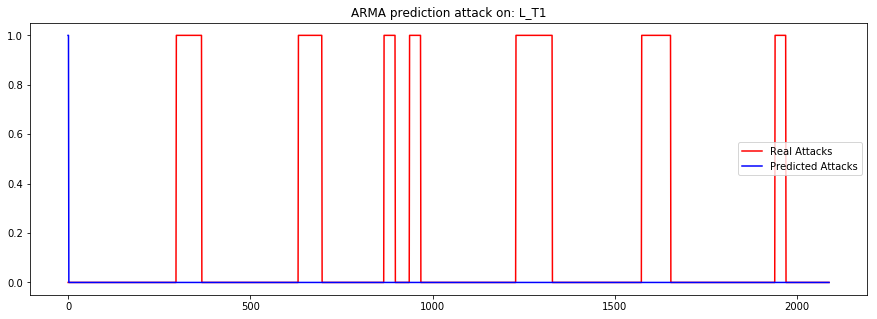

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


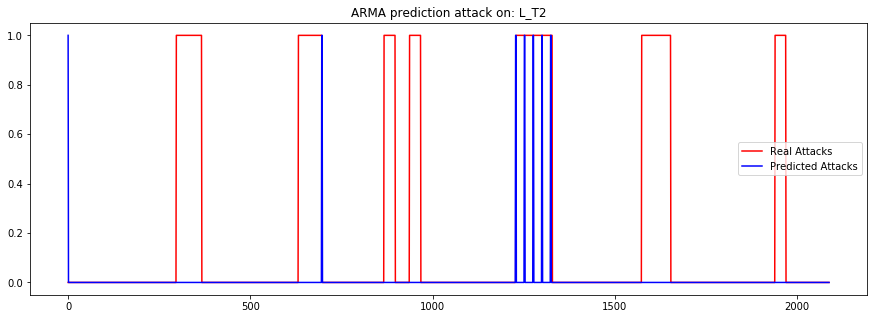

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


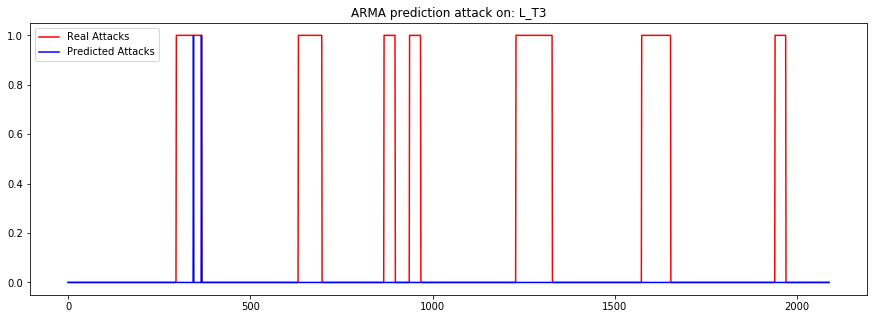

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


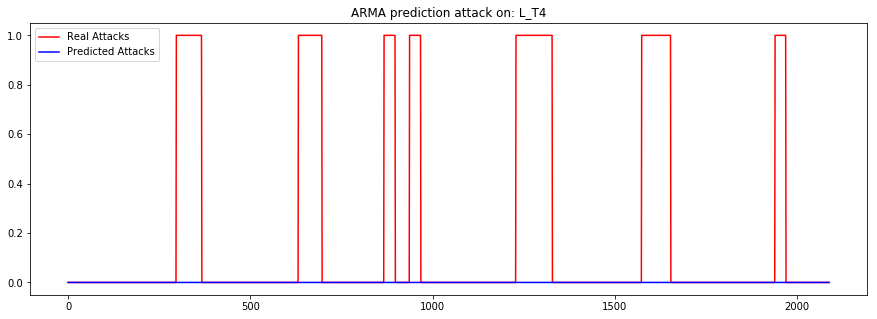

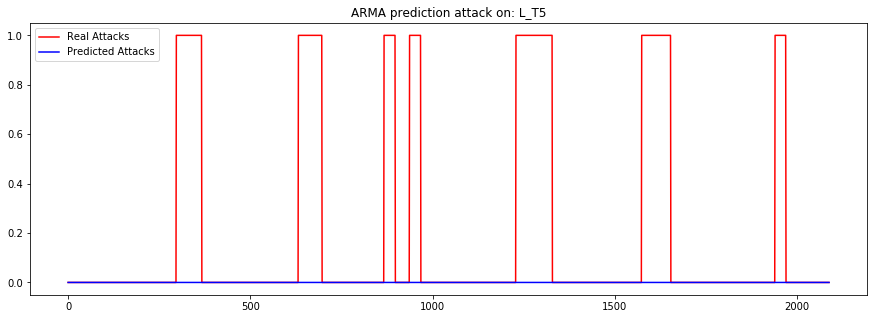

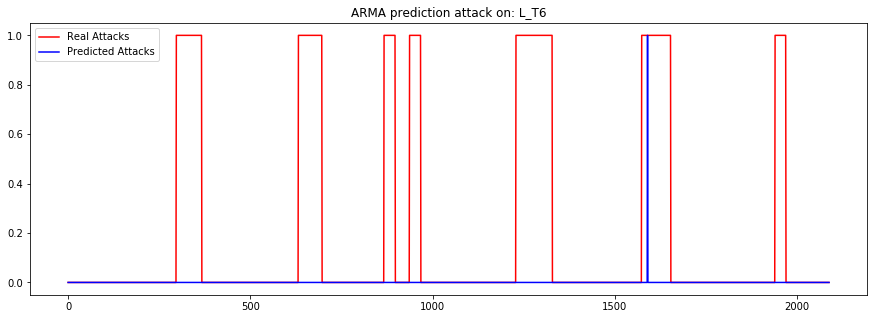

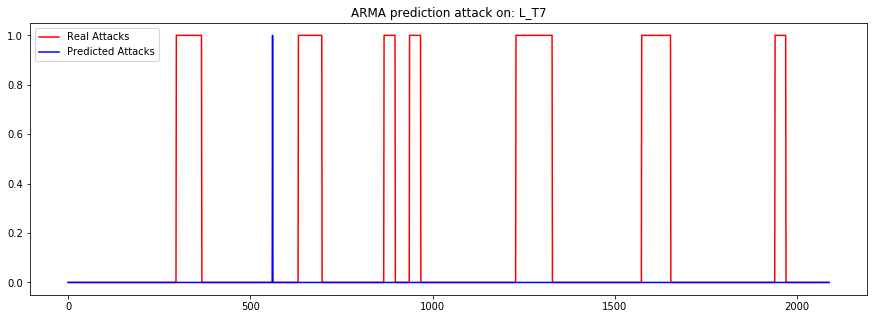

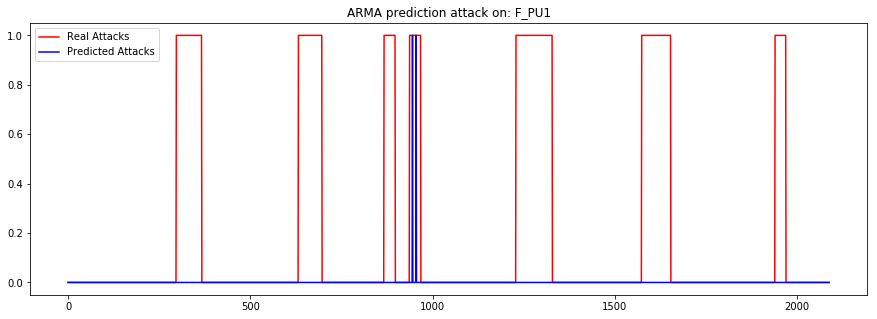

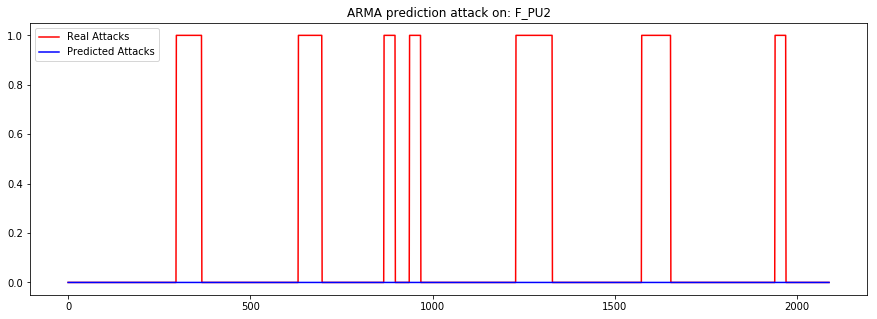

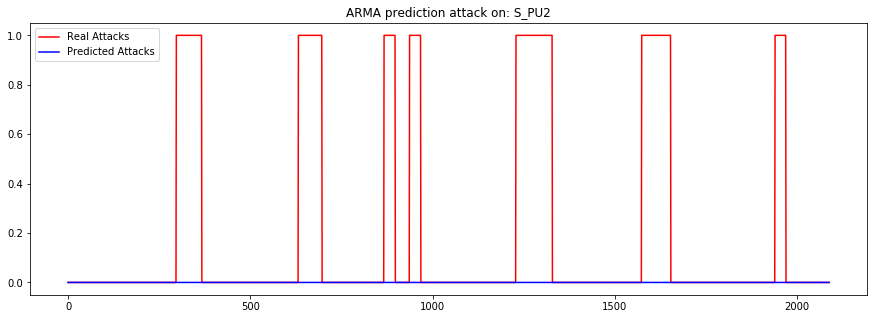

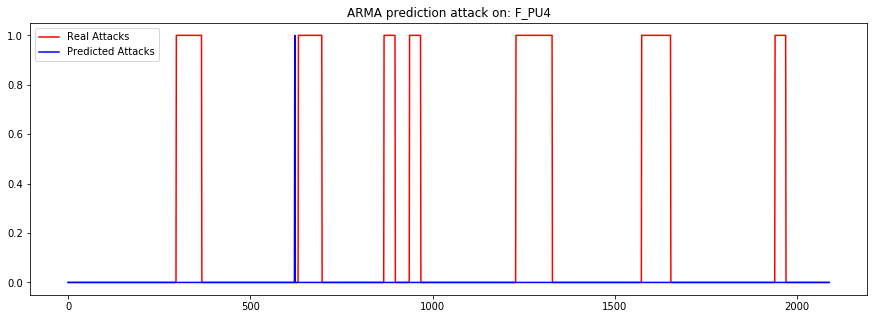

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


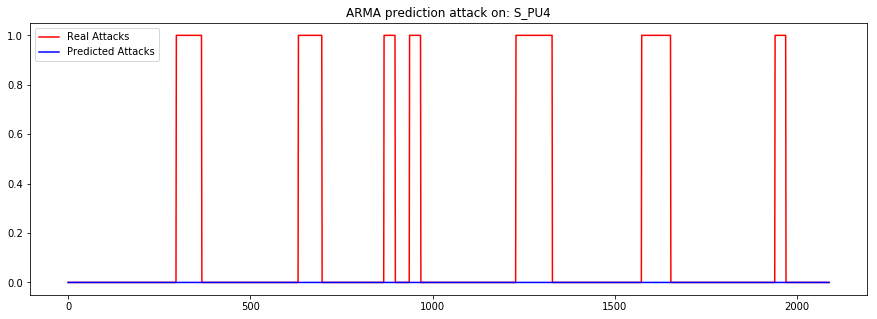

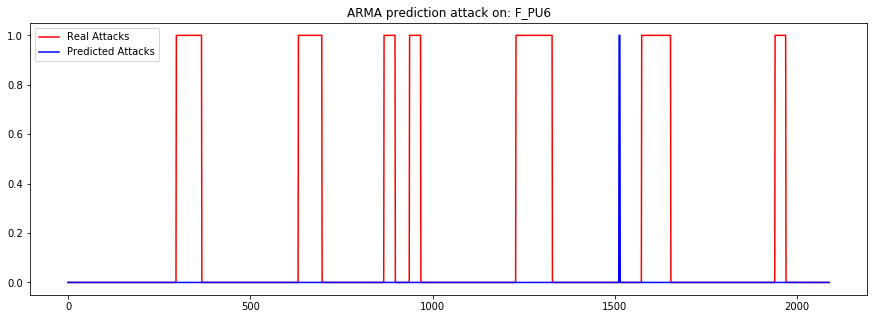

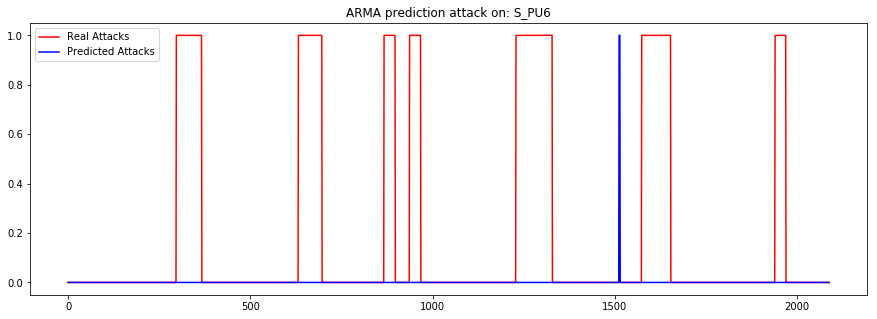

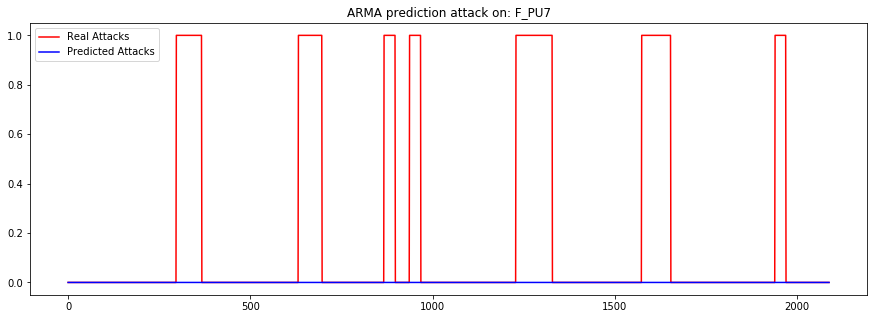

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


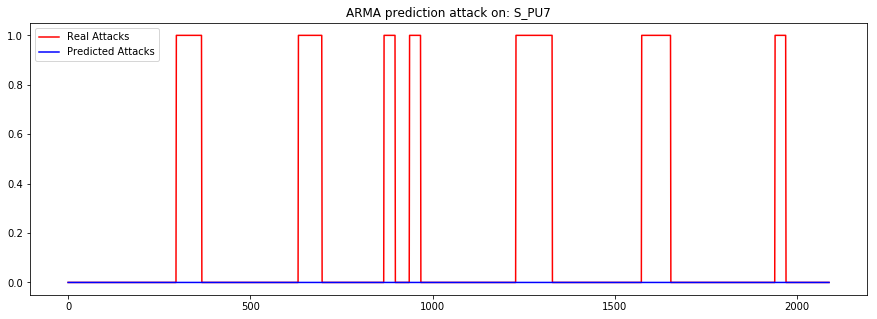

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


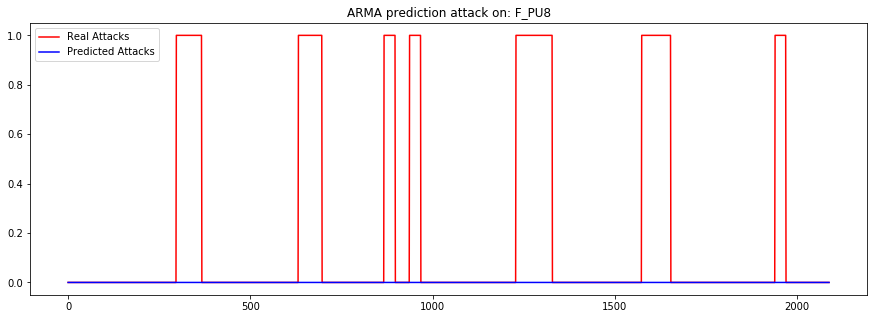

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


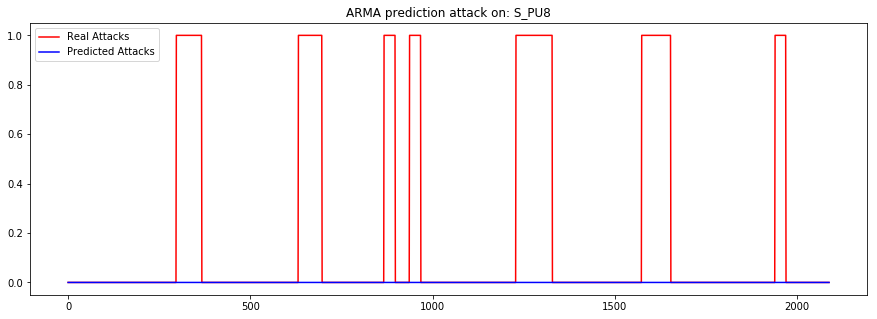

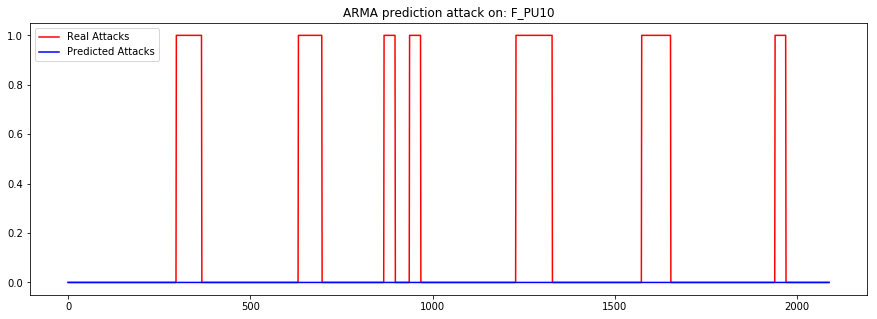

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


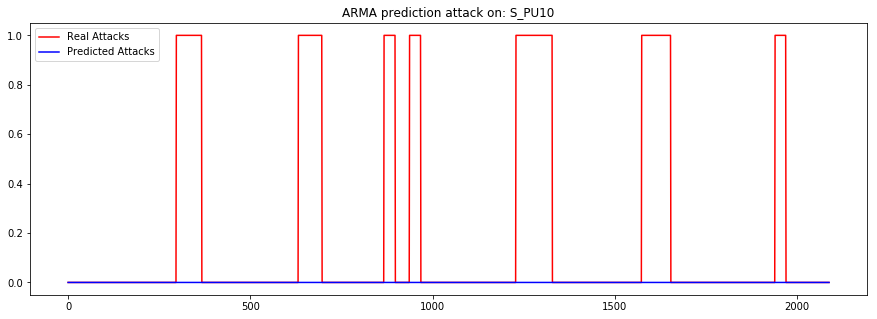

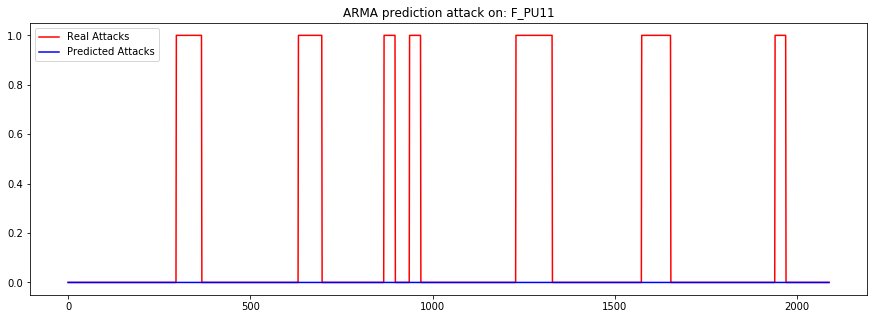

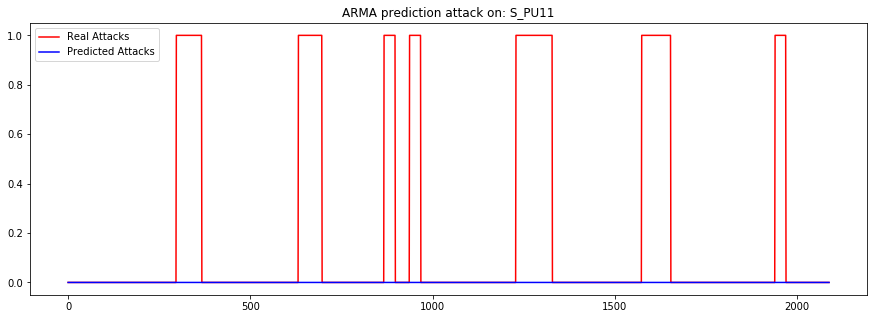

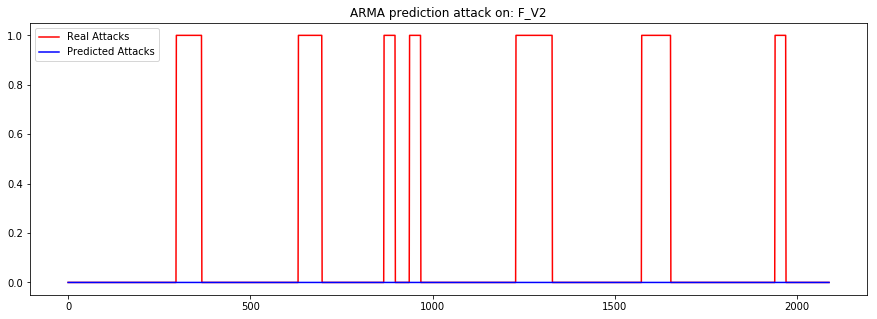

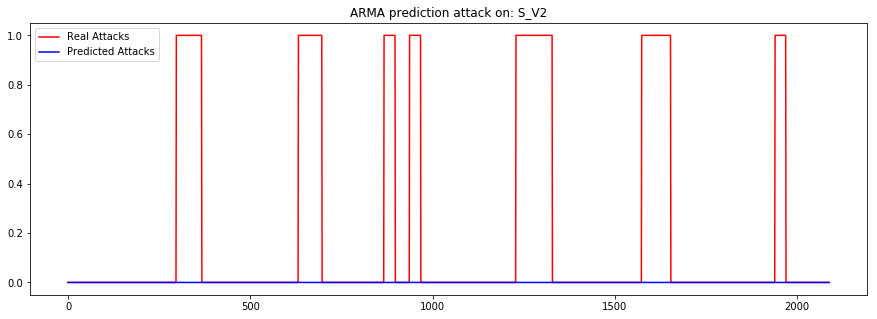

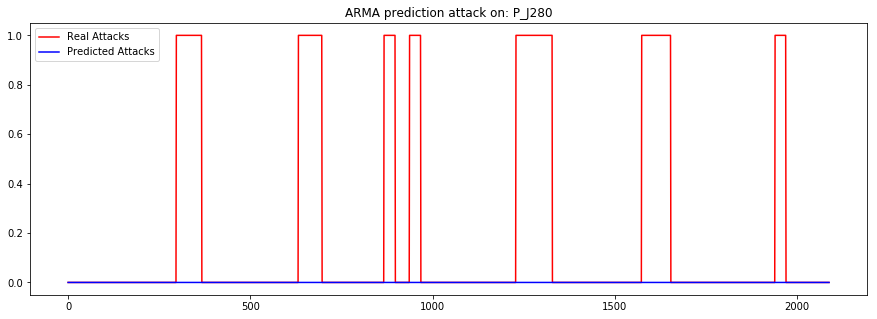

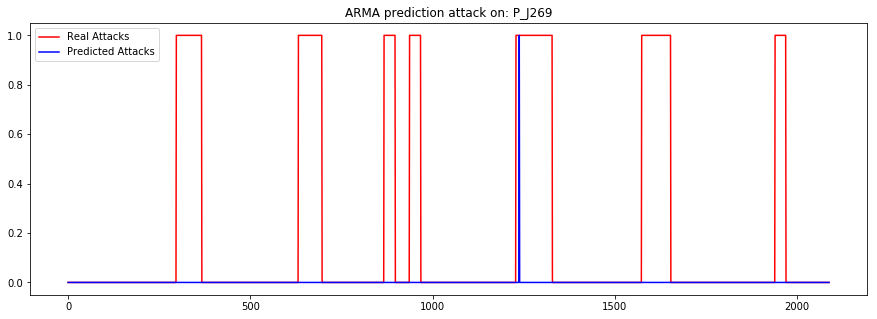

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


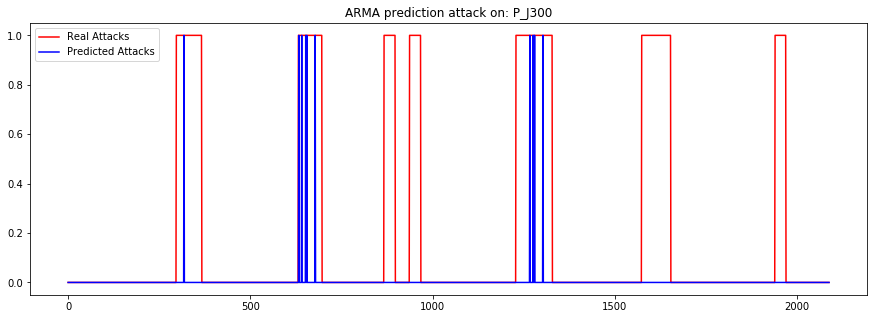

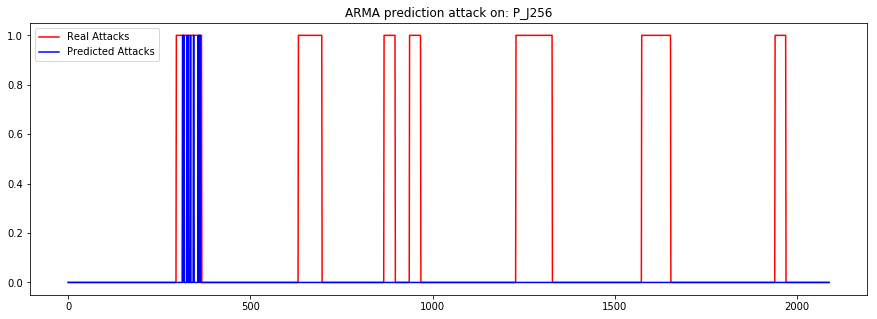

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


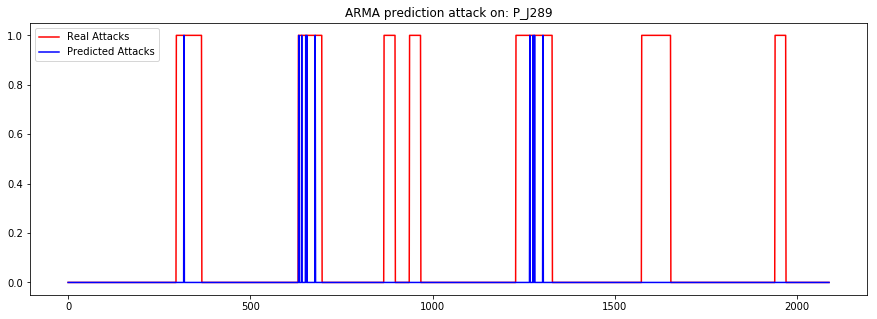

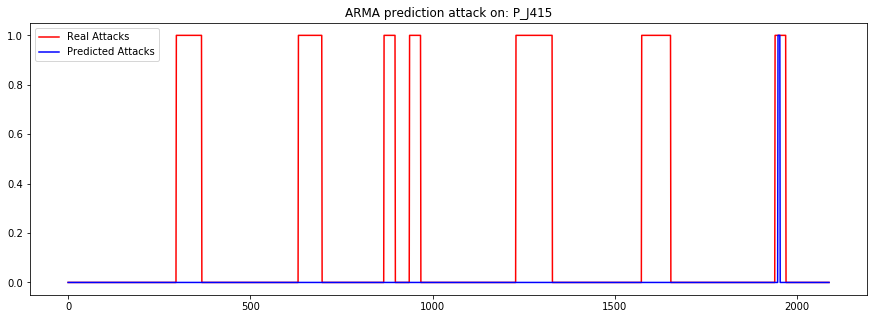

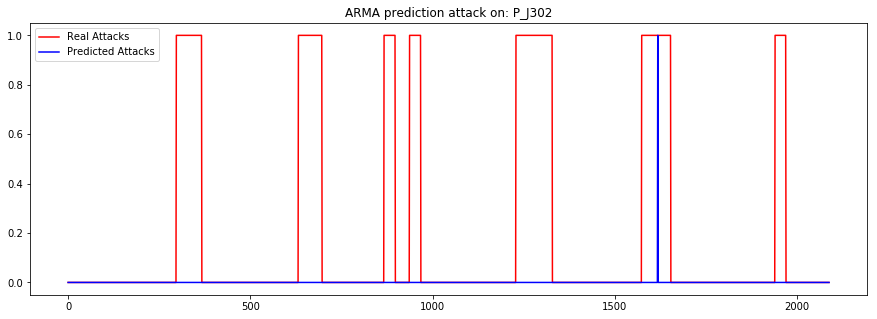

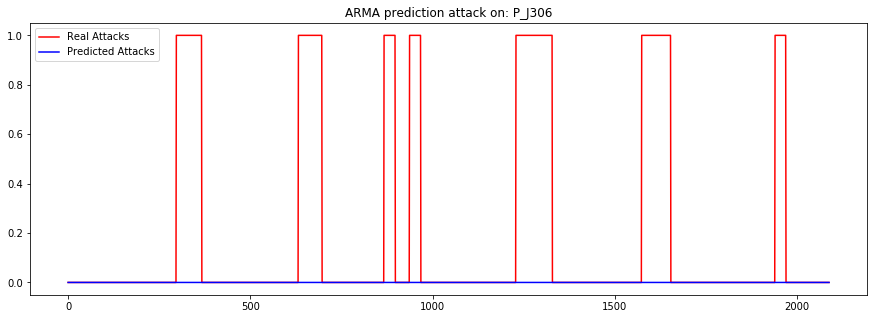

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


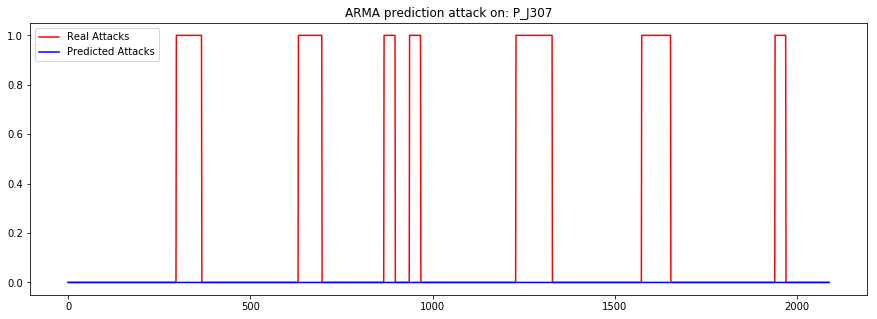

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: over

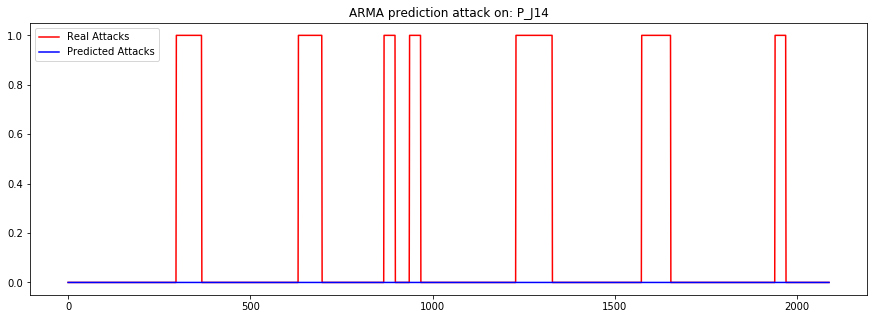

In [6]:
training_data = data
test_data = data3

features = all_features
arma_predictions = {}

for signal in features:
#   Only calculate if there are parameters available
    if arma_param[arma_param['feature'] == signal]['score'].values[0] != 'inf':
        p = arma_param[arma_param['feature'] == signal]['p'].values[0]
        q = arma_param[arma_param['feature'] == signal]['q'].values[0]
        try:
#           apply arma to the signal
            arma_prediction = arma_predict(training_data[signal], test_data[signal], test_data['ATT_FLAG'], 
                                           signal, p=p, q=q)
#             Add the predictions to the dictionary
            arma_predictions.update({signal: arma_prediction})
        except:
            continue

### Separate Visualisation

/home/roy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


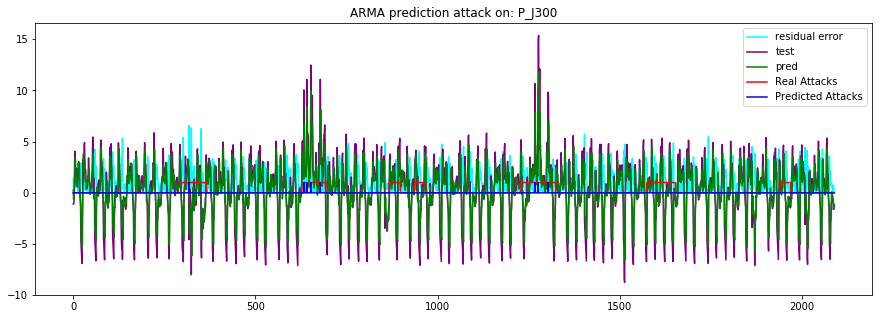

In [12]:
signal = 'P_J300'
training_data = data
test_data = data3
p = 8
q = 4
arma_prediction = arma_predict(training_data[signal], test_data[signal], test_data['ATT_FLAG'], 
                               signal, p=p, q=q)

### Load pre-computed results

In [13]:
# dictionary = arma_predictions
# np.save('arma_predictions_train_1.npy', dictionary) 

# Load
arma_predictions = np.load('arma_predictions.npy', allow_pickle=True).item()

# Discrete models task

Discretize the sensor data using any of the methods discussed in class. Explain why you choose this method and why the obtained discretization makes sense. Visualize the discretization. 

Apply any of the sequential data mining methods (N-grams, Sequence alignment with kNN, …) to sliding windows with a length of your choosing in order to find anomalies. Whenever an observed Ngram’s probability is too small, or the sequential data is too distant from any training sequence, raise an alarm. Set your thresholds sensibly. What kind of anomalies can you detect using the sequential model? Which sensors can be modeled effectively?

### Functions for evaluating and creating the discretization (classification):

In [14]:
MINIMAL_VALUE_FOR_ATTACK = 0.99


def create_markov_chain_from_ngram(levels, attack_data, n_elements):    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    attacks = zip(levels, attack_data)
    levels_to_use = []
    # Do not use the attacks in determining normal behaviour.
    for level, attack_value in attacks:
        if attack_value >= MINIMAL_VALUE_FOR_ATTACK:
            # Mark that an attack is going on
            levels_to_use.append(None)
        else:
            levels_to_use.append(level)
            
    ngrams = list(zip(*[levels_to_use[i:] for i in range(n_elements)]))
    markov_chain = {}
    for ngram in ngrams:
        # If attacks are present in de training data, do not take them into account for the markov chain 
        # (as the attacks should not be marked as normal data)
        if None not in ngram:
            last_element = ngram[-1]
            ngram_base = ngram[:-1]
            if ngram_base not in markov_chain:
                markov_chain.update({ngram_base: {}})
            known_transitions = markov_chain[ngram_base]
            if last_element not in known_transitions:
                known_transitions.update({last_element: 1})
            else:
                known_transitions[last_element] += 1
    return markov_chain


def classify_using_markov_chains(sax_training, attacks_in_training, sax_test, symbols, treshold, n_elements):
    markov_chain = create_markov_chain_from_ngram(sax_training, attacks_in_training, n_elements)
    # We need to set the first n_elements - 1 values to normal, 
    # because we detect abnormalities for the last element of the sequence.
    # If a certain index is abnormal, it is thus actually index + n_elements - 1,
    detected_list = [VALUE_FOR_NORMALITY_DETECTED]*(n_elements - 1)
    for i in range(len(sax_test)):
        if i >= len(sax_test) - n_elements:
            # Take the last n_elements values into account if 
            # we are at the end
            sequence = sax_test[-n_elements:]
        else:
            sequence = sax_test[i:i+n_elements]
        
        base = tuple(sequence[:-1])
        head = sequence[-1]
        
        if base not in markov_chain:
            markov_chain.update({base: {}})
        last_elements = markov_chain[base]
        
        # Apply smoothing for unknown elements
        if head not in last_elements:
            last_elements.update({head: 1})
        base_occurences = sum(last_elements.values())
        occurences = last_elements[head]
        sequence_probability = occurences / base_occurences
        if sequence_probability < treshold or math.isclose(sequence_probability, treshold):        
            detected_list.append(VALUE_FOR_ANOMALITY_DETECTED)
        else:
            detected_list.append(VALUE_FOR_NORMALITY_DETECTED)
    return detected_list[:-(n_elements-1)]


def get_sax_data(training_data, test_data, alphabet_size, elements_per_segment=1):
    # Scale data
    scaler = StandardScaler()
    preprocessed_training_data = training_data.values.reshape(-1,1)
    preprocessed_test_data = test_data.values.reshape(-1,1)
    scaled_training_data = scaler.fit_transform(preprocessed_training_data).ravel()
    # Only transform is called, because we want the same scale as the training data
    scaled_test_data = scaler.transform(preprocessed_test_data).ravel()
    
    #Perform SAX
    sax = SymbolicAggregateApproximation(n_segments=round(len(training_data)/elements_per_segment),
                                         alphabet_size_avg=alphabet_size)
    # Compute SAX representations
    fit = sax.fit(scaled_training_data)
    transformed_training = fit.transform(scaled_training_data)
    # Compute time series corresponding to given SAX representations.
    ts_train = fit.inverse_transform(transformed_training)[0].ravel()
    
    # We cannot use the previous SAX, as then the creation of the alphabe is influenced by the test set 
    sax = SymbolicAggregateApproximation(n_segments=round(len(test_data)/elements_per_segment),
                                         alphabet_size_avg=alphabet_size) 
    transformed_test = sax.fit_transform(scaled_test_data)    
    ts_test = sax.inverse_transform(transformed_test)[0].ravel()
    return ts_train, ts_test
    

def results_of_predictions(predictions, real_attacks, combined, pp_treshold):
    results = {'ALL': {'FP': 0, 'DETECTED': 0}}
    grouped = {'ALL': combined}
    att_ranges = attack_ranges(real_attacks)
    prediction_set = set()
    for feature, prediction in predictions.items():
        if feature.startswith("L_T"):
            sensor_name = "L_T"
        if feature.startswith("S_PU"):
            sensor_name = "S_PU"
        if feature.startswith("F_PU"):
            sensor_name = "F_PU"
        if feature.startswith("S_V"):
            sensor_name = "S_V"
        if feature.startswith("F_V"):
            sensor_name = "F_V"
        if feature.startswith("P_J"):
            sensor_name = "P_J"
            
        if sensor_name not in results:
            results.update({sensor_name: {'FP': 0, 'DETECTED': 0}})
            grouped.update({sensor_name: prediction})
            
        grouped_prediction = grouped[sensor_name]
        for i, p in enumerate(prediction):
            prediction_set.add(p)
            if p == 1:
                grouped_prediction[i] = 1
                
    for sensor_name, prediction in grouped.items():
        for i, p in enumerate(prediction):
            r = real_attacks[i]
            if r == 0 and p == 1:
                results[sensor_name]['FP'] += 1
        for (start, end) in att_ranges:
            prediction_range = prediction[start:end]
            if 1 in prediction_range:
                results[sensor_name]['DETECTED'] += 1
    return results 
    
    
def attack_ranges(attacks):
    ranges = []
    ctr = 0
    att_start = None
    while ctr < len(attacks):
        e = attacks[ctr]
        if e > 0.1:
            att_start = ctr
            while e > 0.1:
                ctr += 1
                e = attacks[ctr]
            att_stop = ctr - 1
            ranges.append((att_start, att_stop))
        else:
            ctr += 1
    return ranges          

### Visualisation

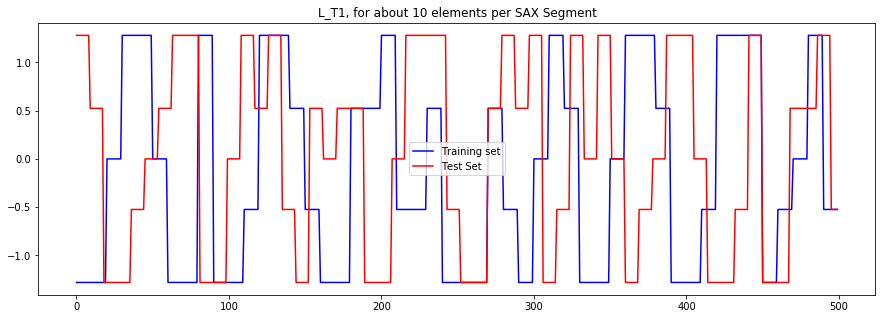

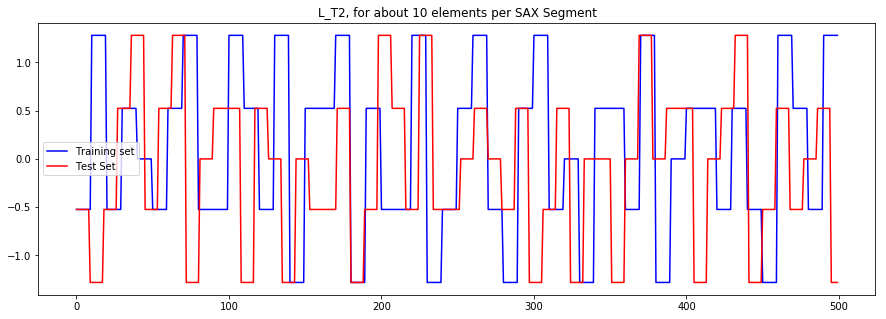

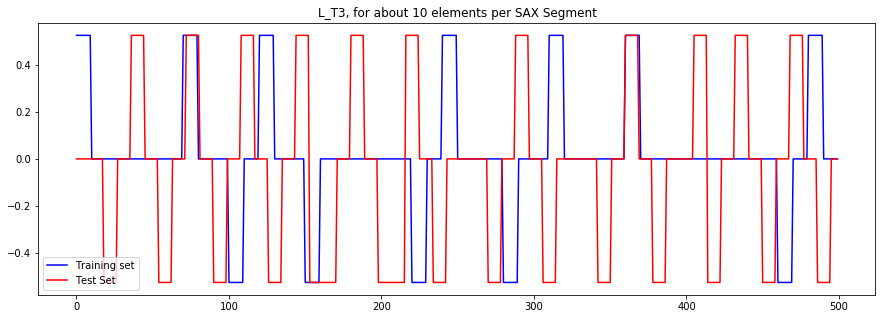

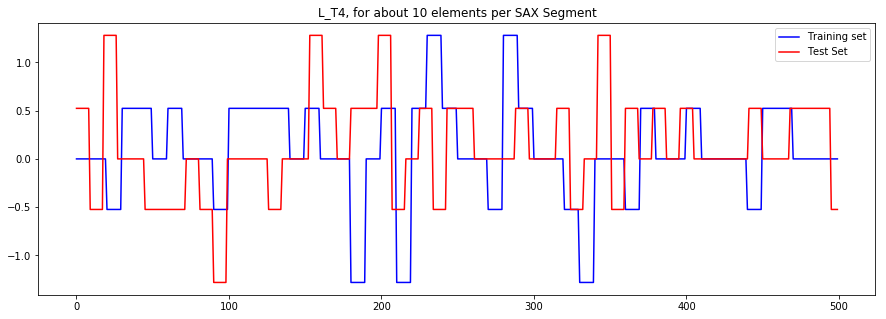

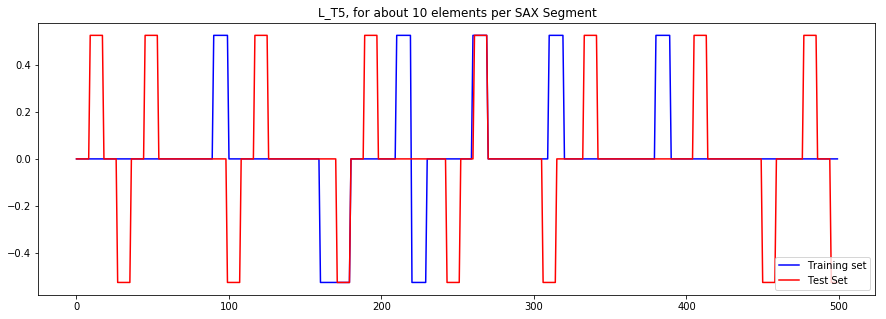

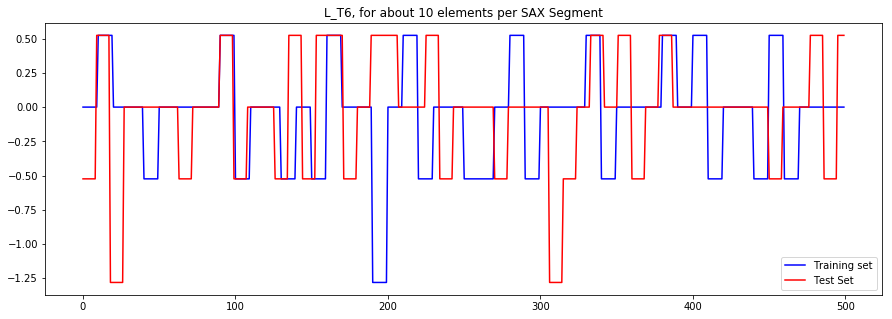

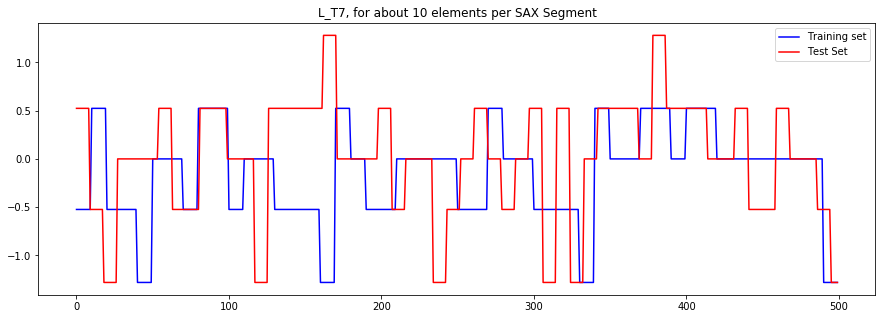

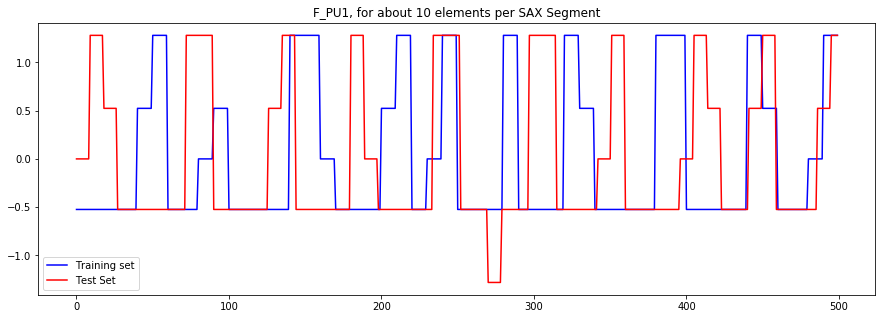

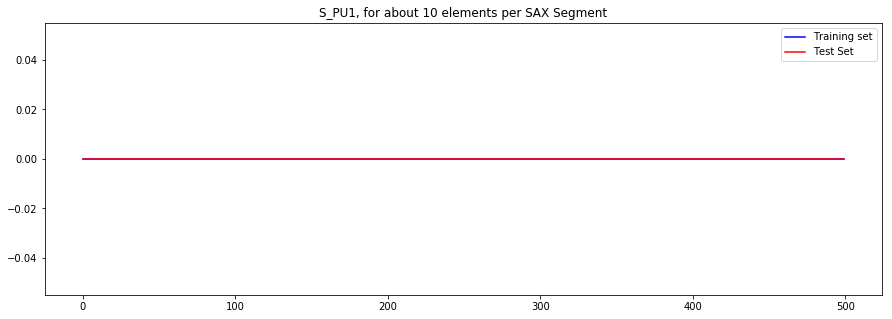

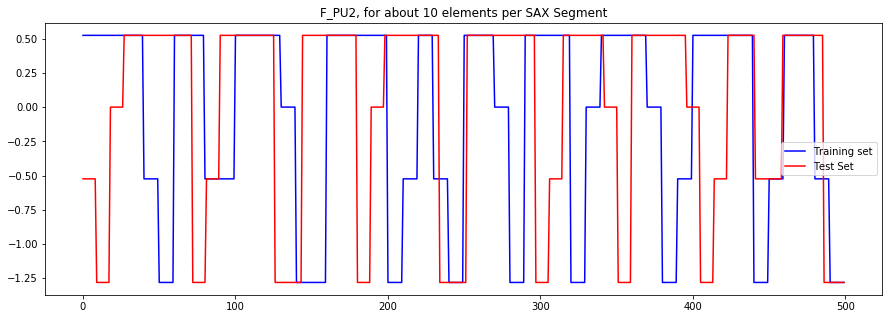

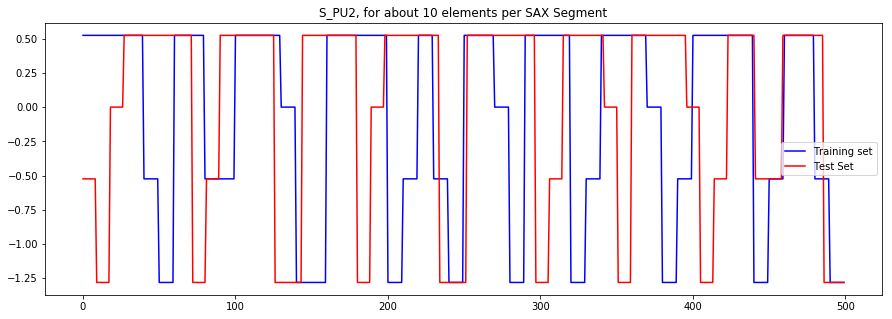

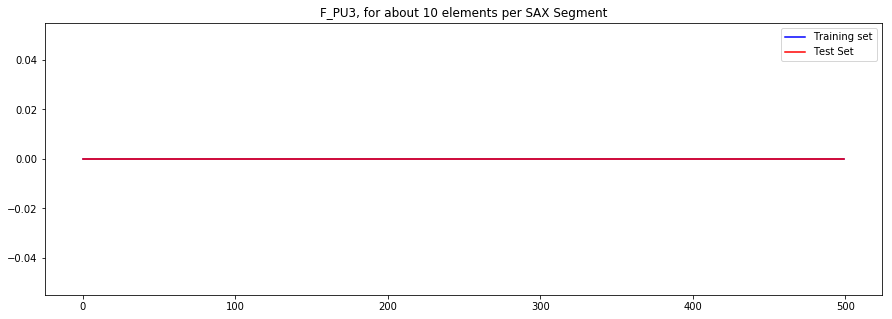

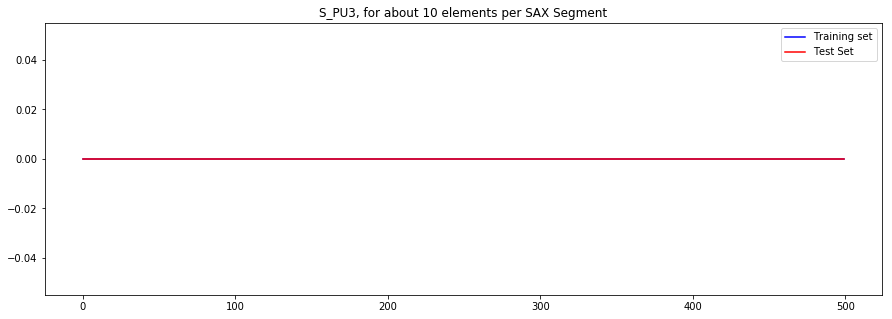

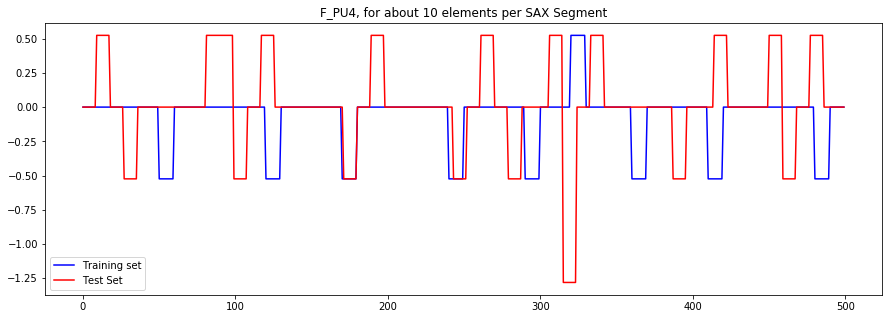

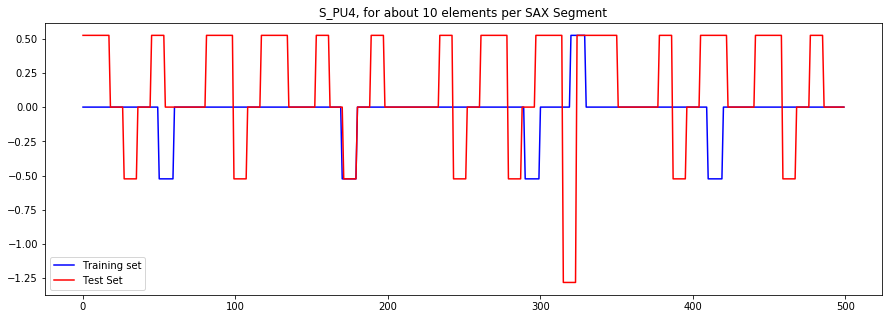

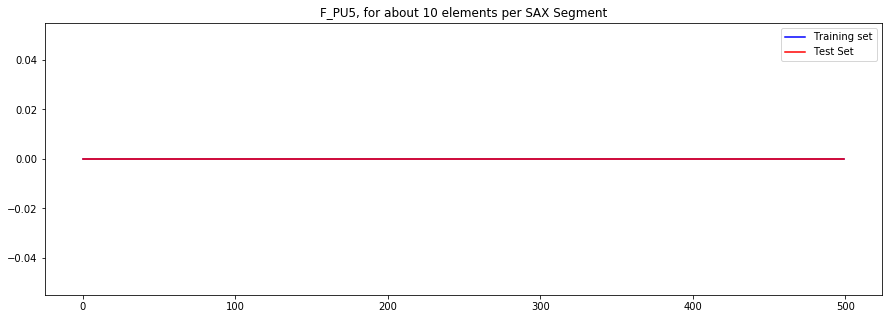

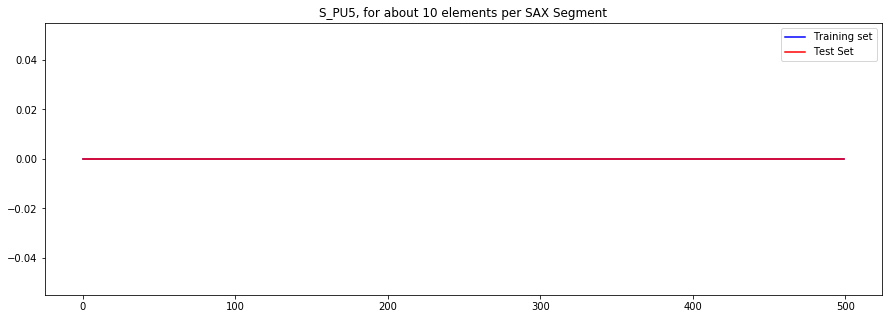

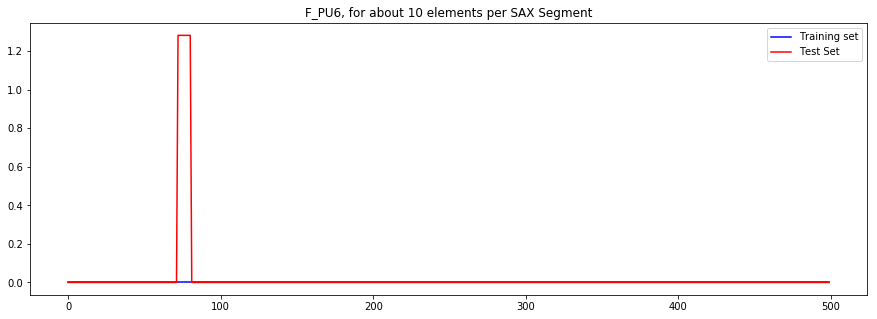

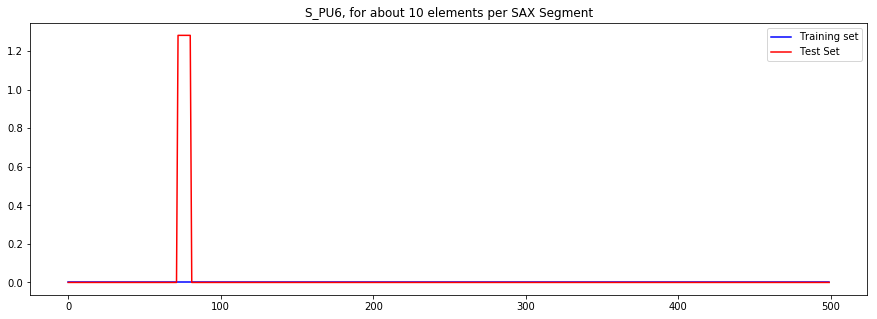

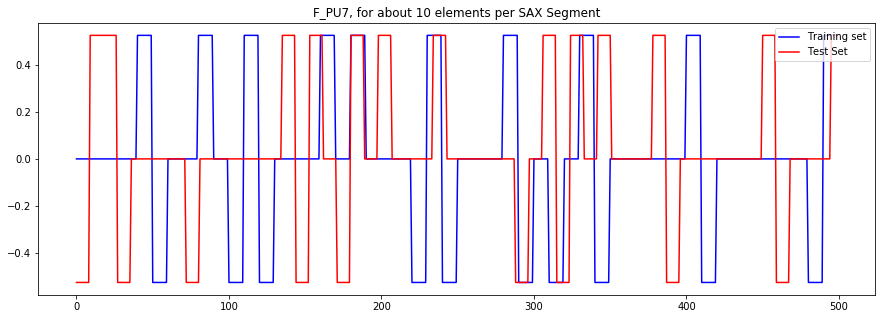

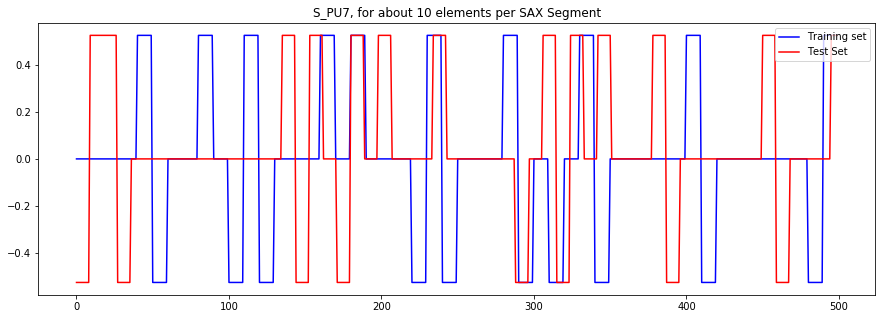

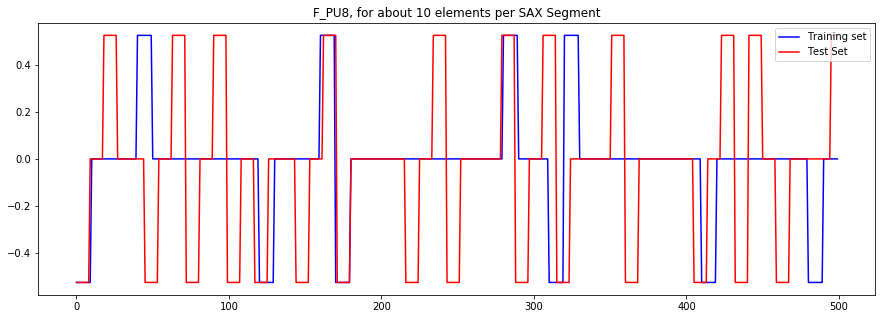

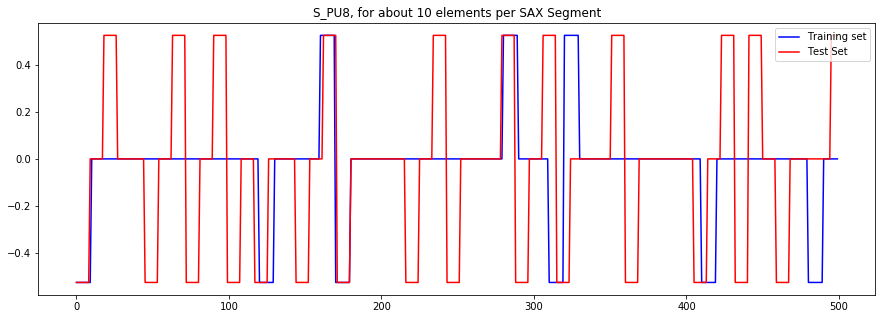

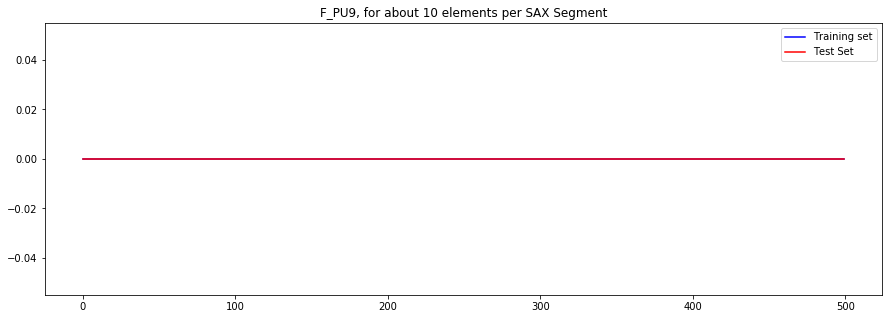

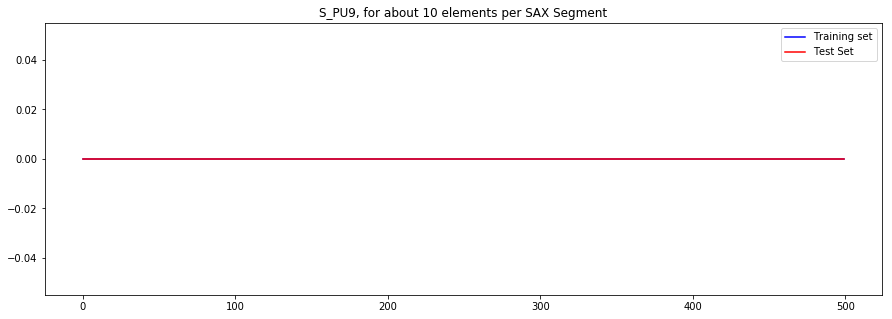

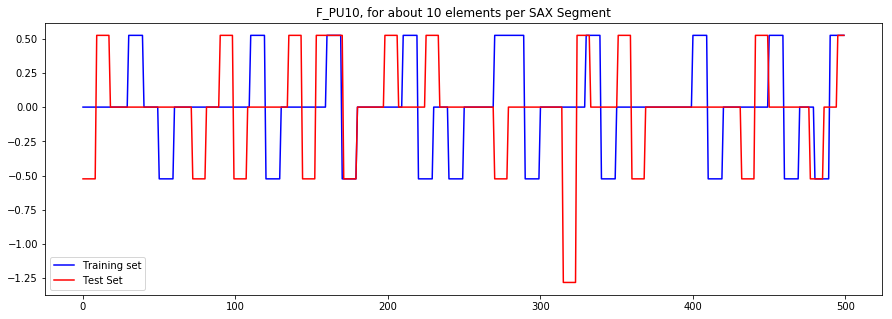

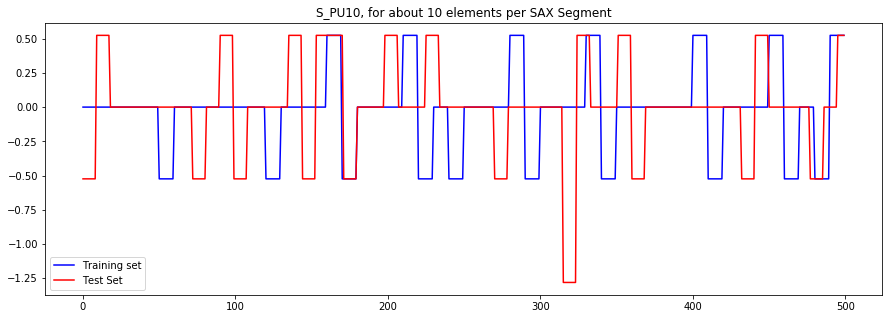

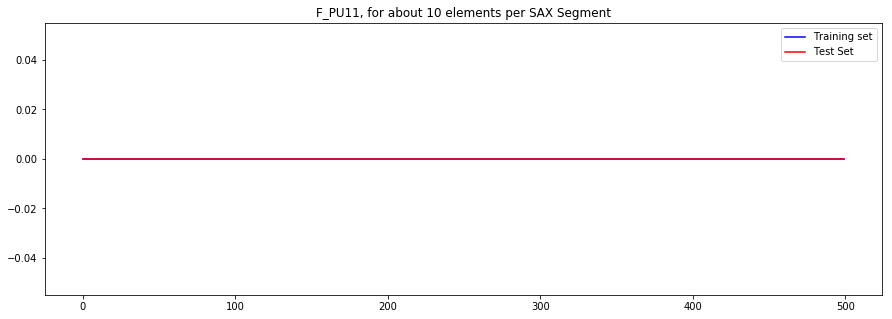

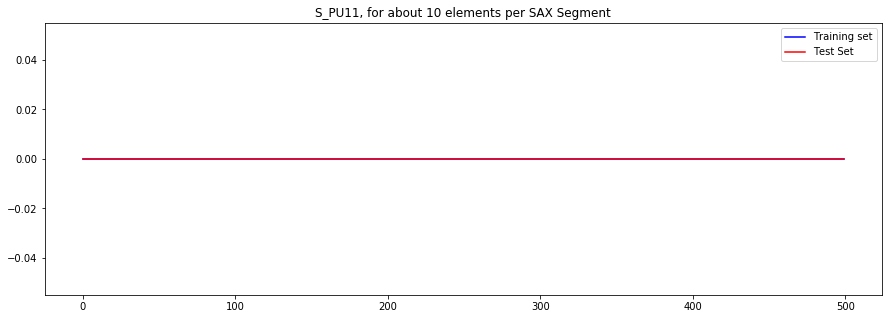

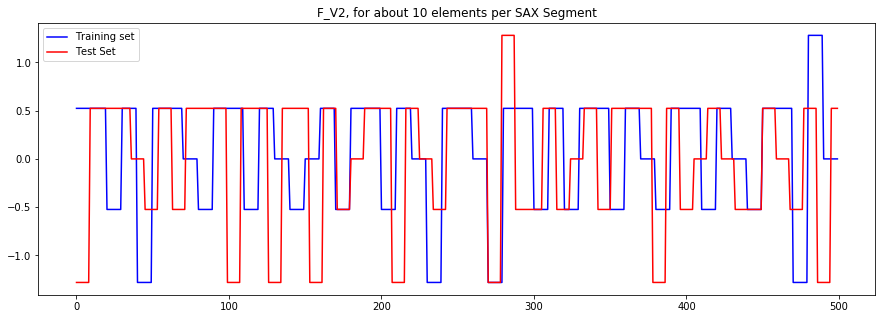

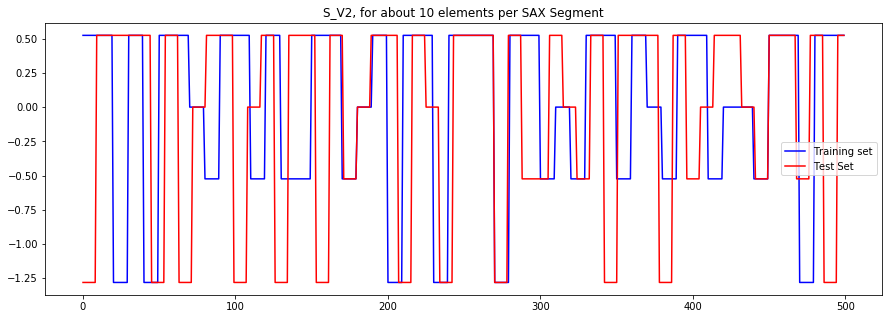

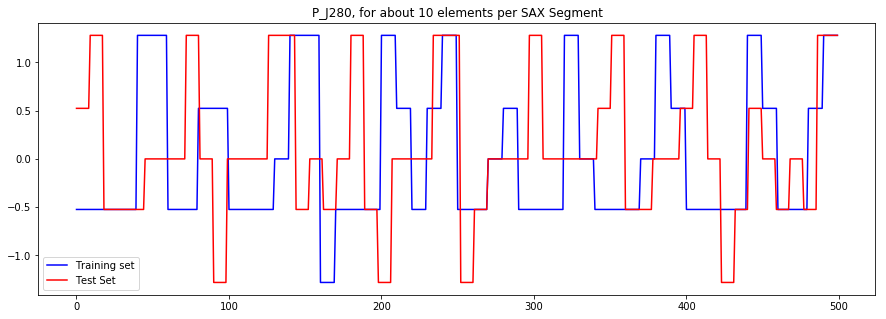

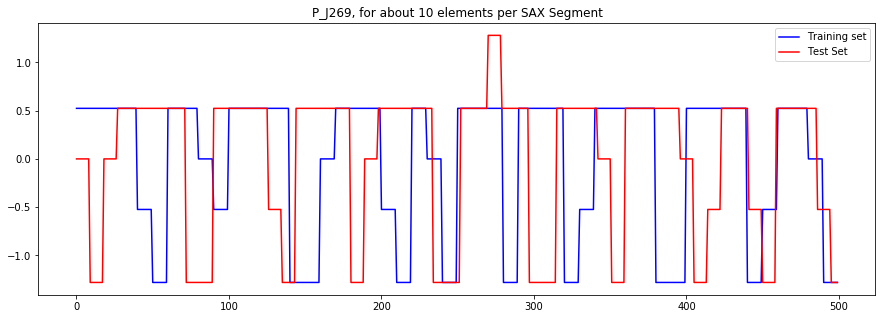

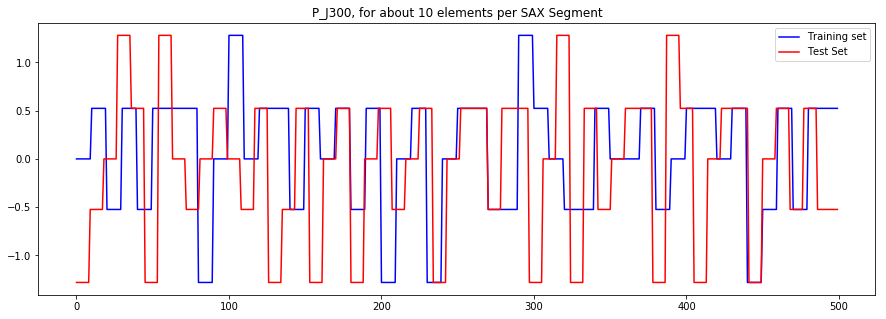

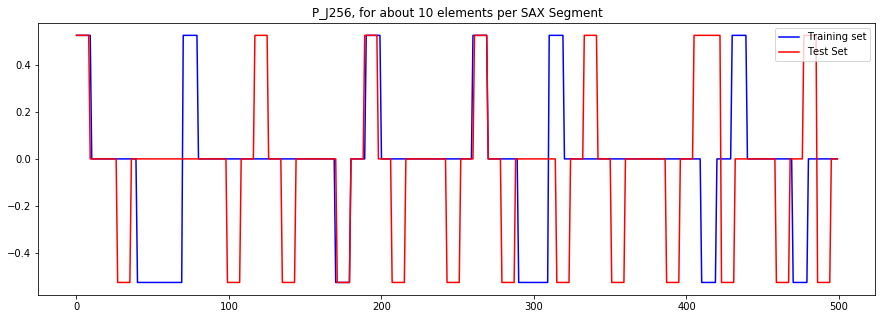

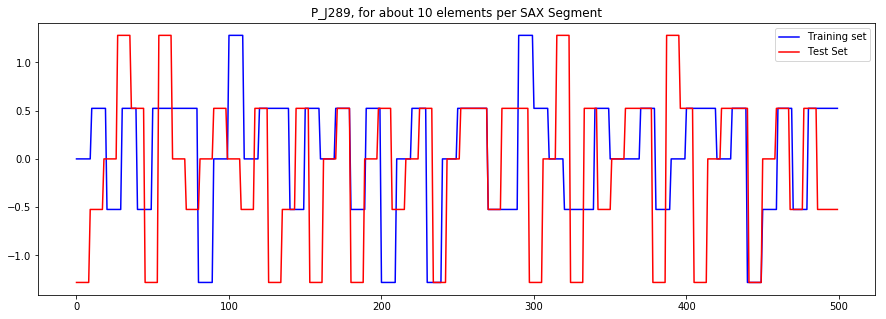

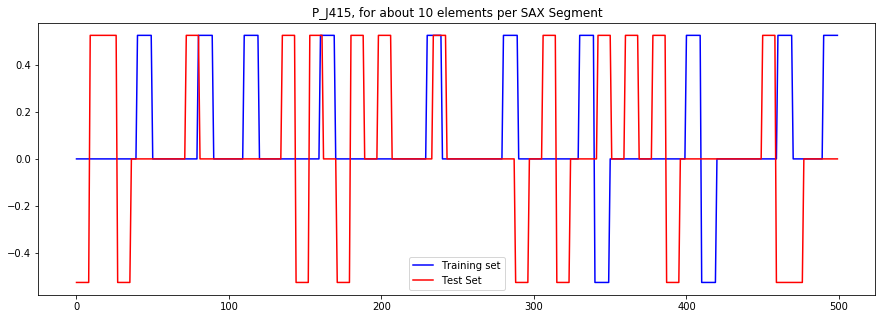

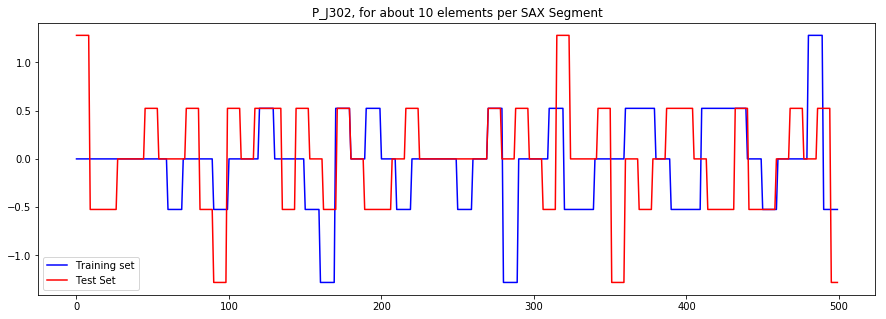

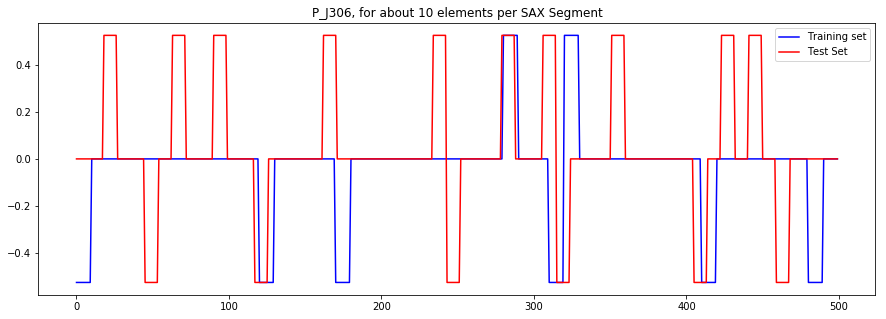

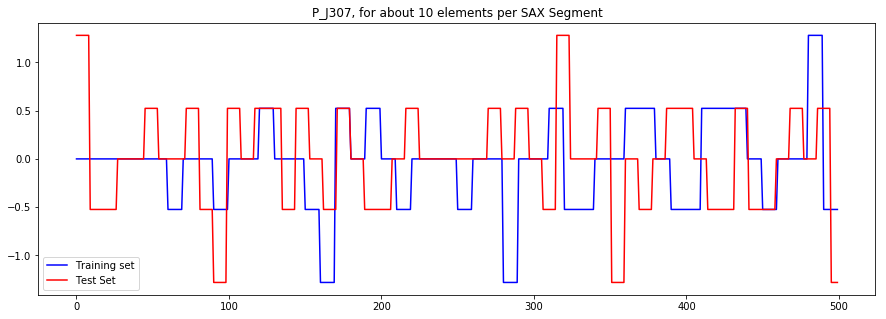

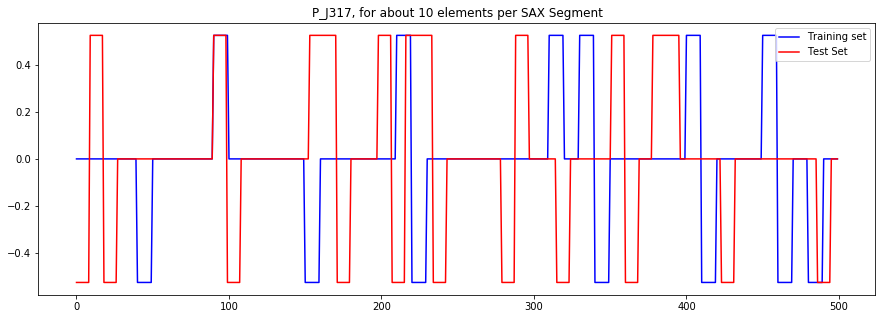

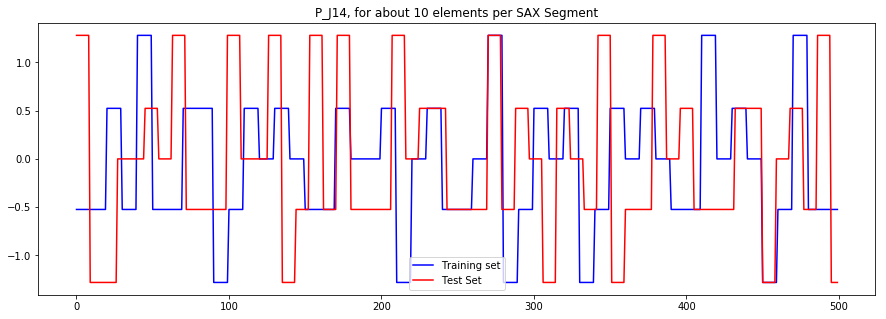

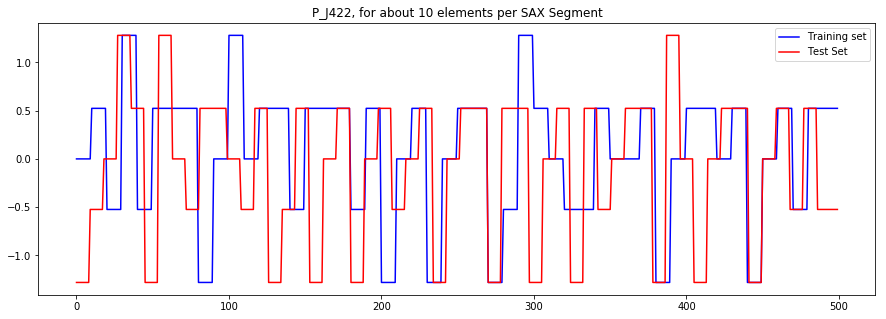

In [15]:
def visualise(training_set, test_set, features, alphabet_size, plot_n_elements):    
    for feature in features:
        # Just to be sure. We do not want to train on these columns.
        if feature in ['DATETIME', 'ATT_FLAG']:
            continue
    
        # Calculate the Symbolic Aggregate approXimation
        sax_training, sax_test = get_sax_data(training_set[feature], test_set[feature], alphabet_size, 
                                              elements_per_segment=10) 
        symbols_training = set(sax_training)
        symbols_test = set(sax_test)
        symbols = symbols_training.union(symbols_test)
        # Just to be sure
        if len(symbols) > alphabet_size:
            raise NotImplementedError("Too many symbols!")
        
        # Plot the results
        plt.figure(figsize=(15,5))
        plt.plot(sax_training[:plot_n_elements], 'b-')
        plt.plot(sax_test[:plot_n_elements], 'r-')

        plot_title = f"{feature}, for about 10 elements per SAX Segment"
        plt.legend(['Training set', 'Test Set'])
        plt.title(plot_title)
#         plt.savefig(f"{feature}.png")
        plt.show()
        
training_data = data # data2.append(data, ignore_index = True)
test_data = data2
features = training_data.columns
visualise(training_data, test_data, features,
          alphabet_size=5, plot_n_elements=500)

### Classification

/home/roy/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


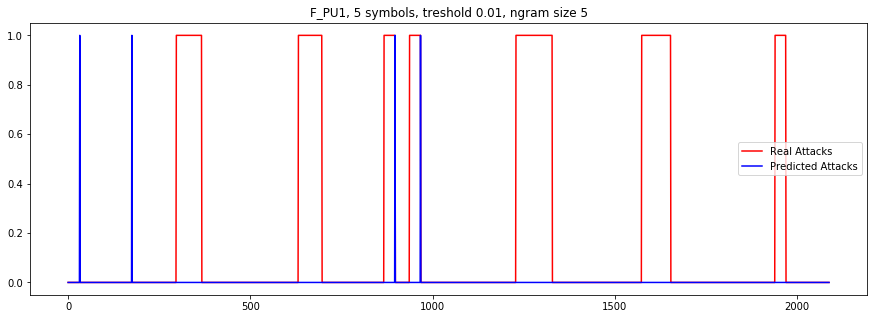

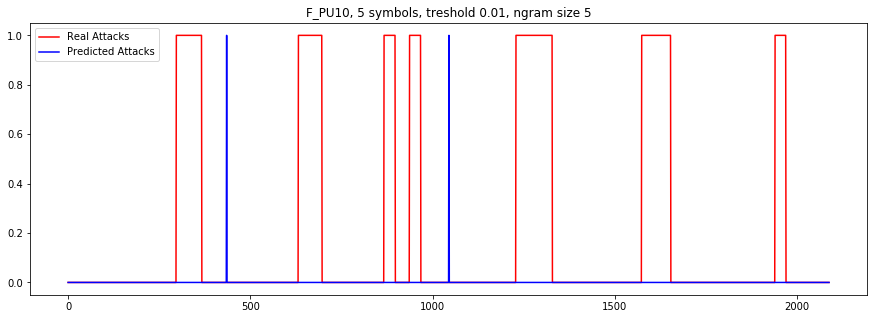

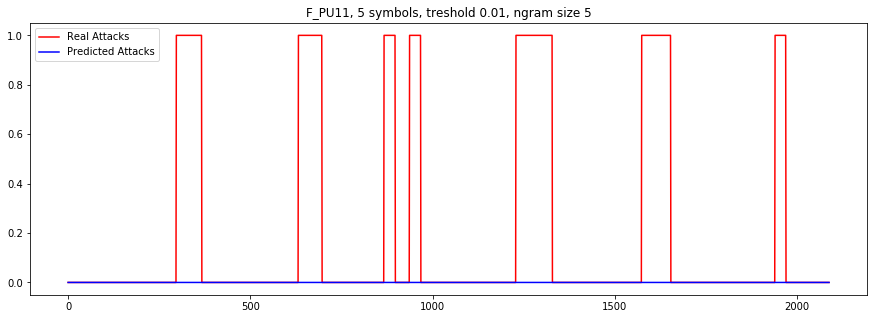

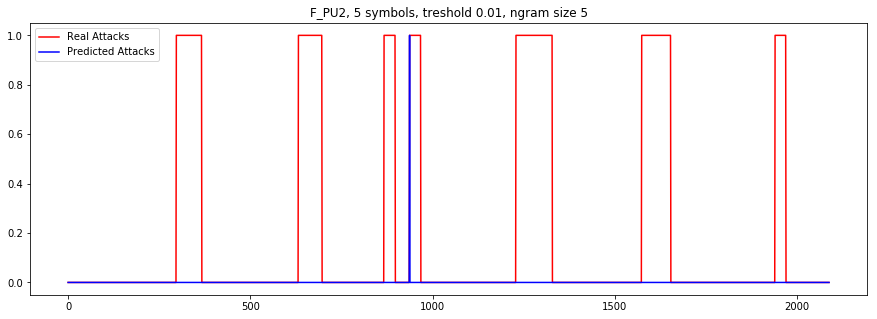

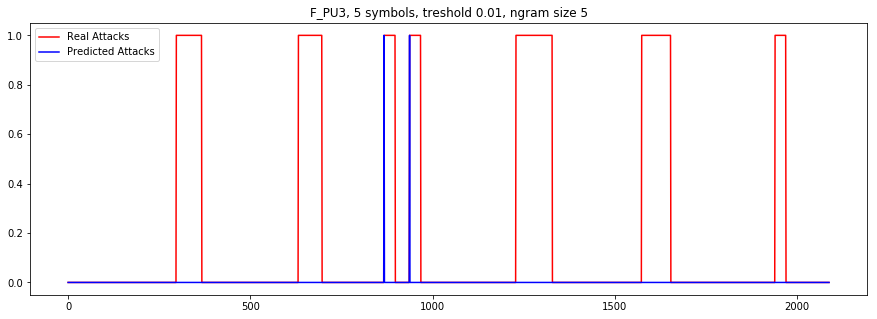

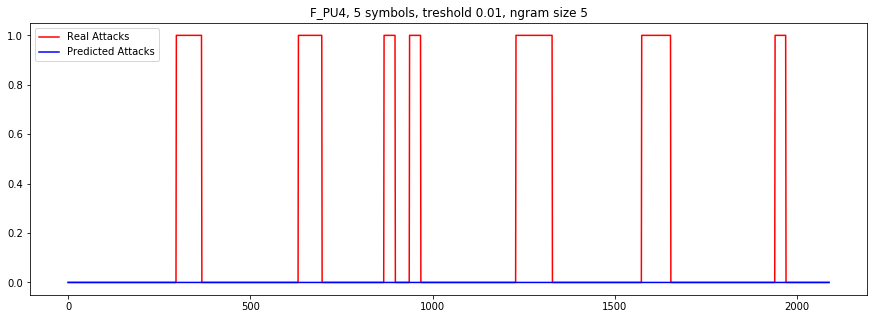

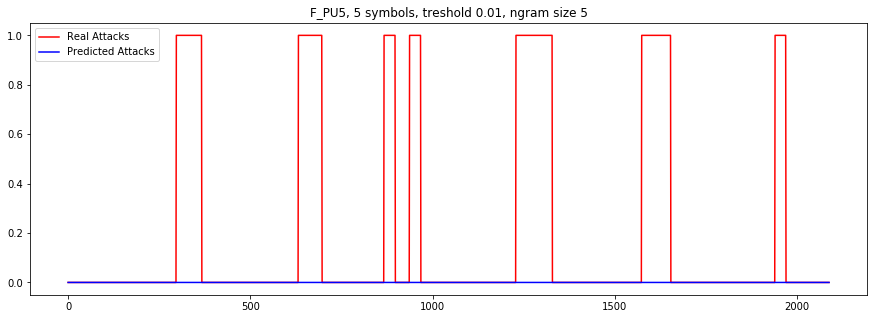

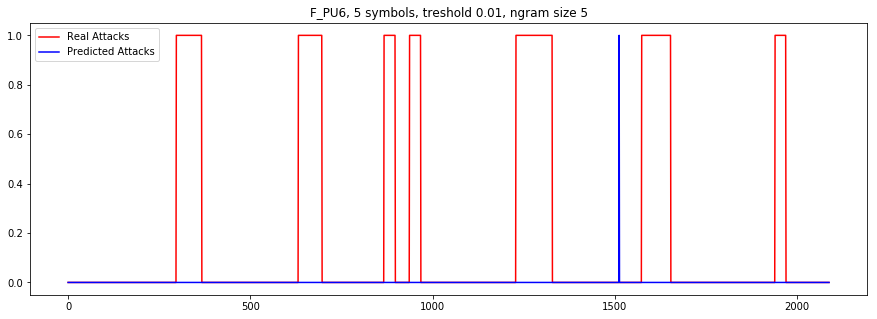

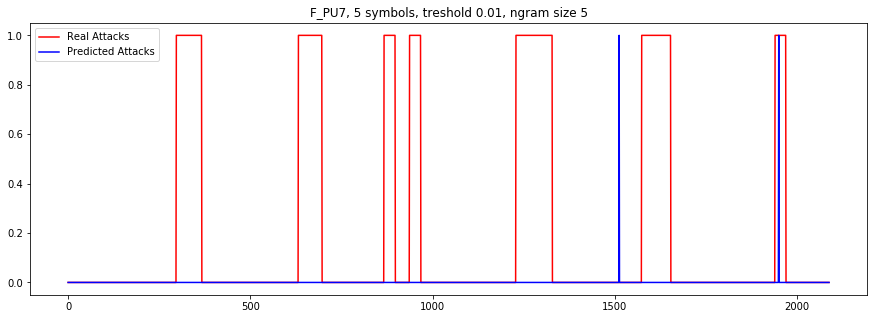

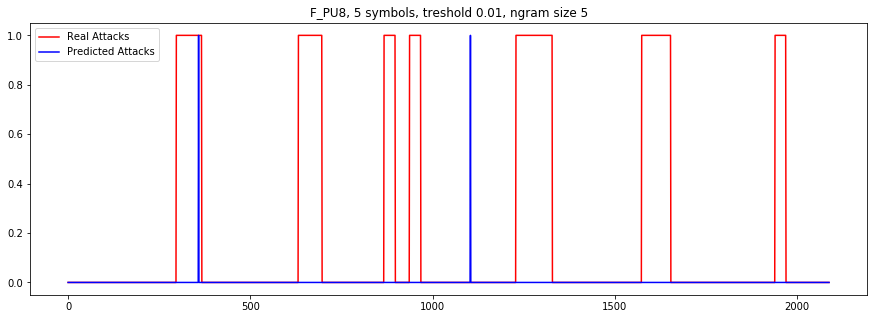

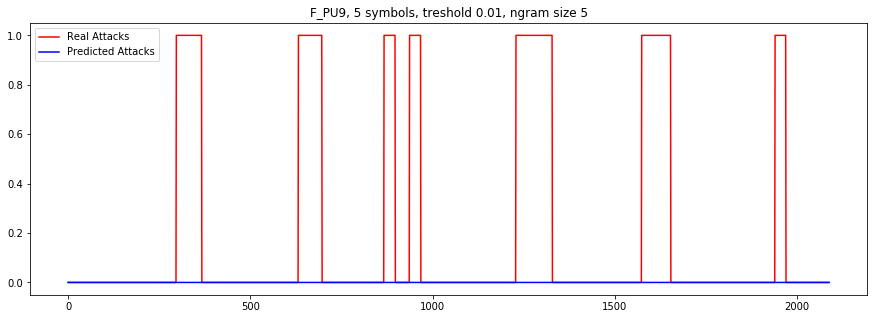

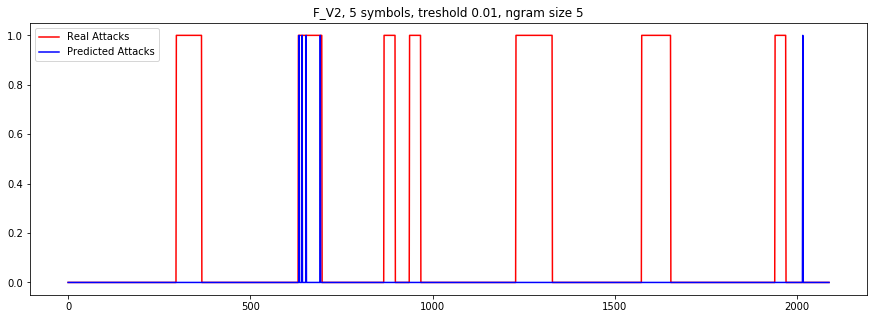

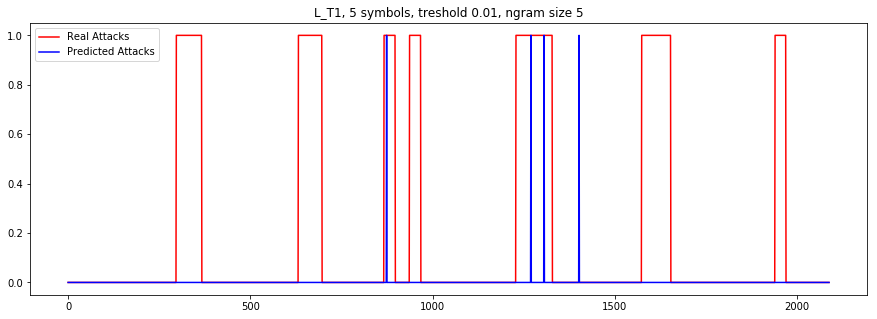

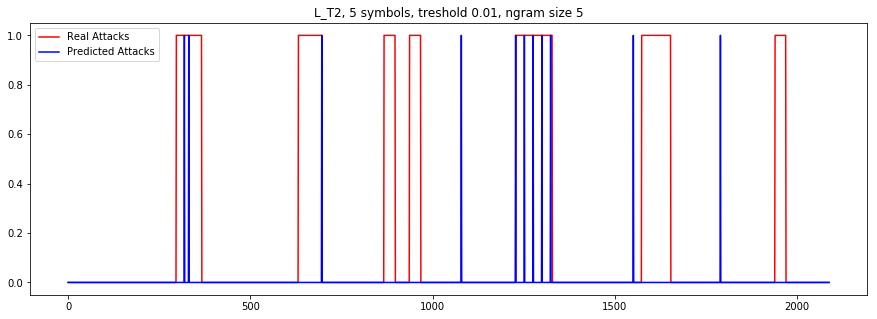

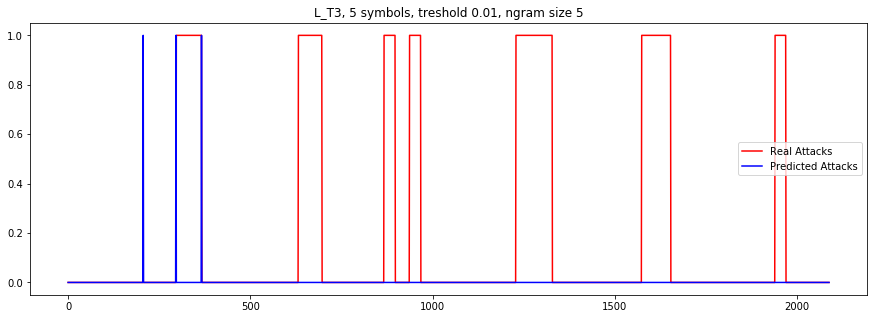

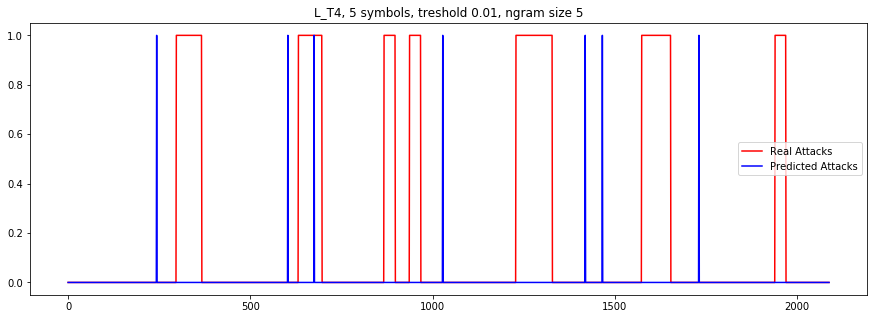

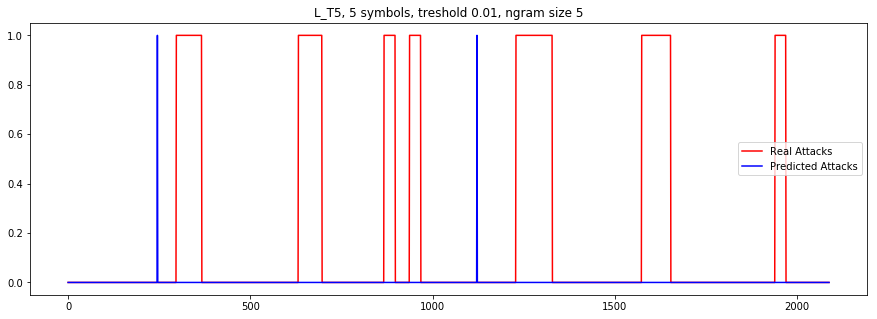

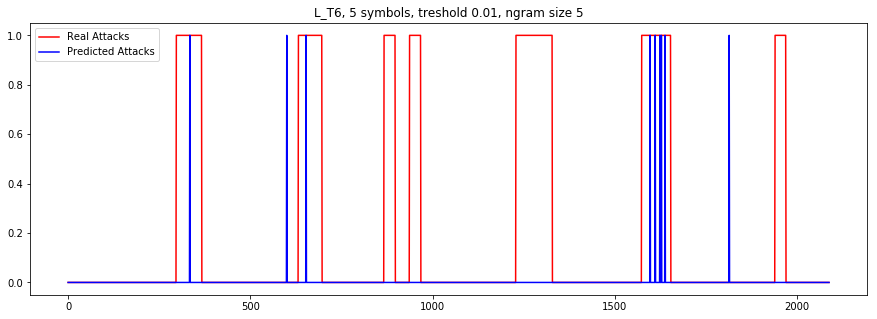

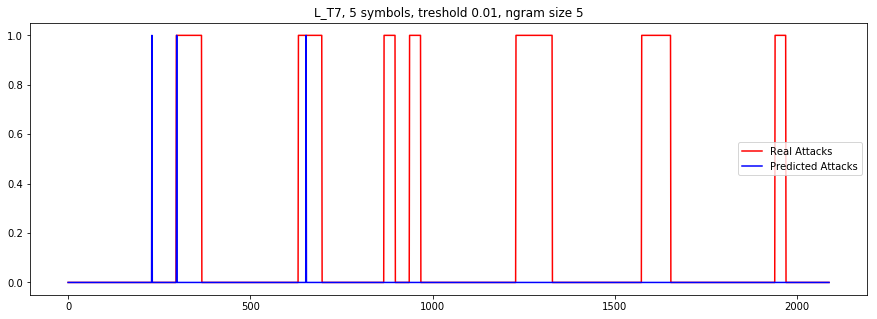

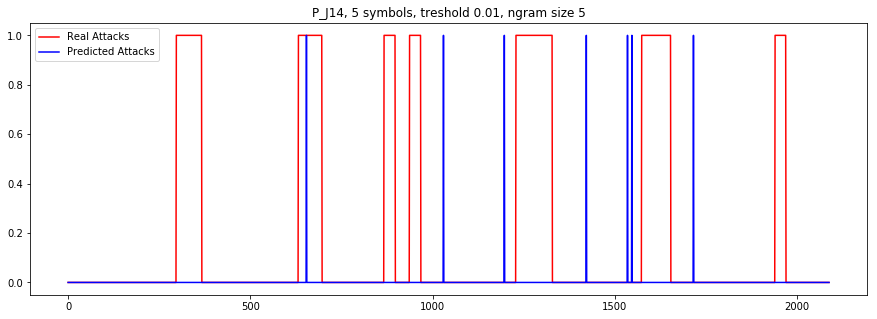

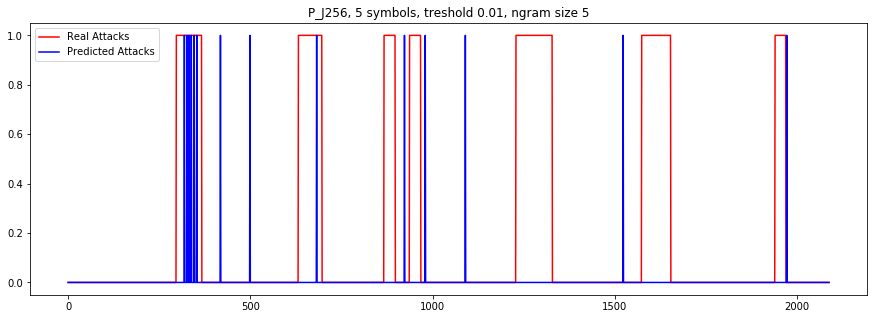

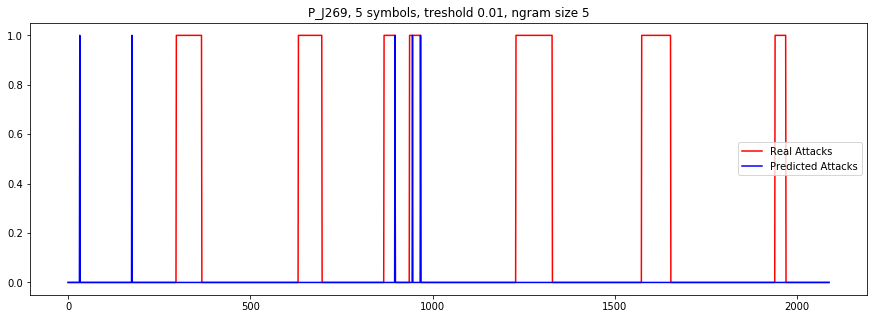

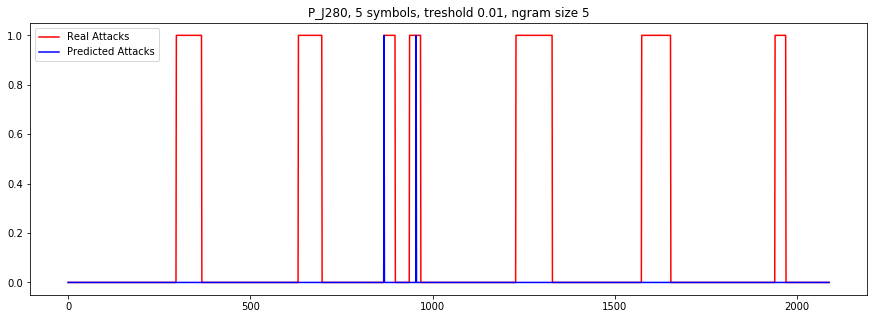

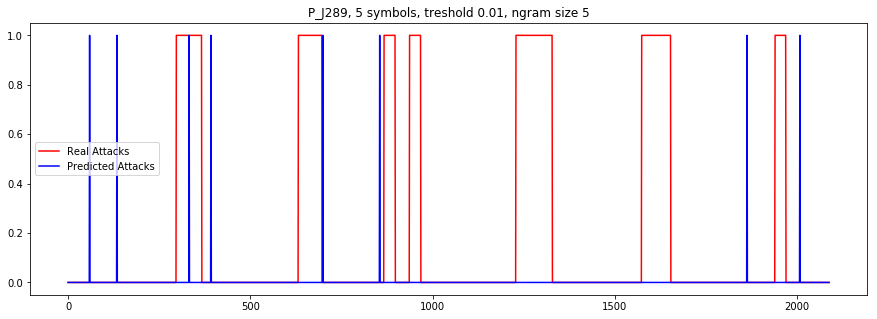

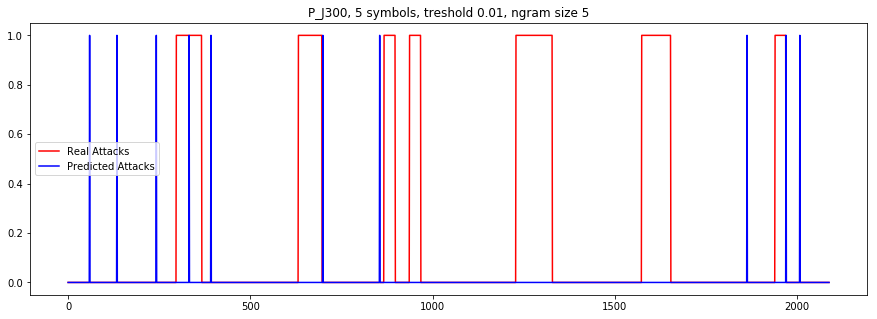

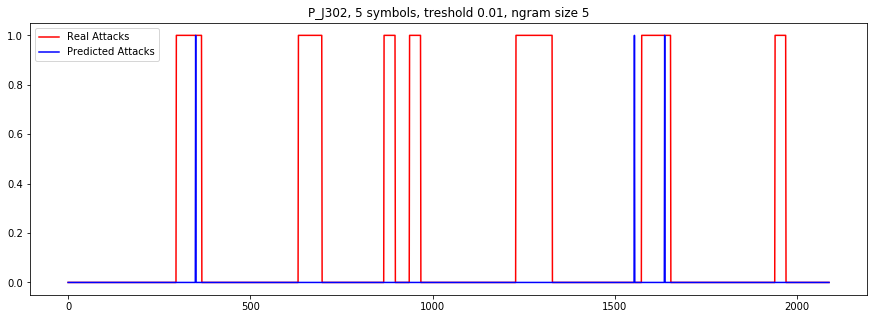

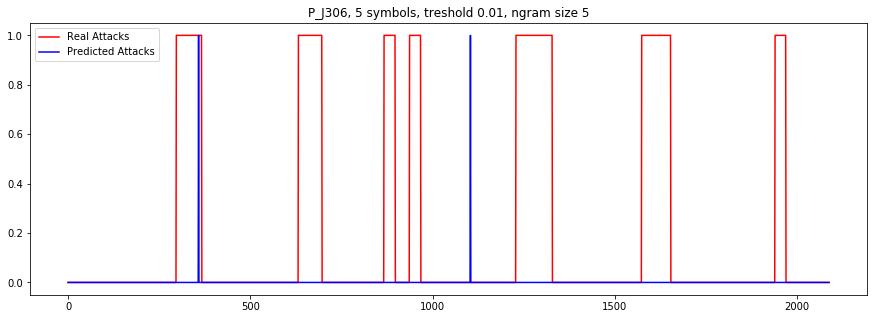

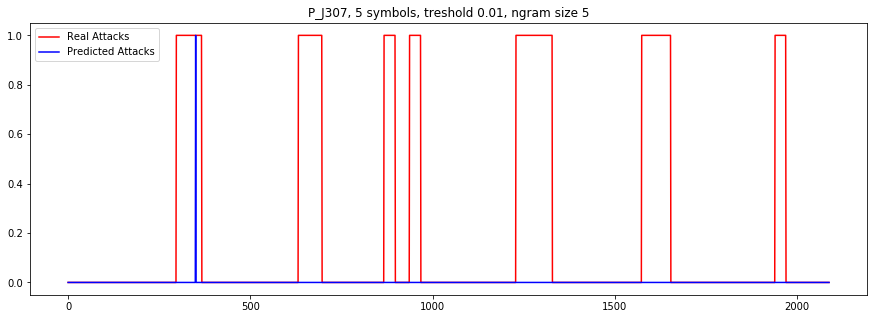

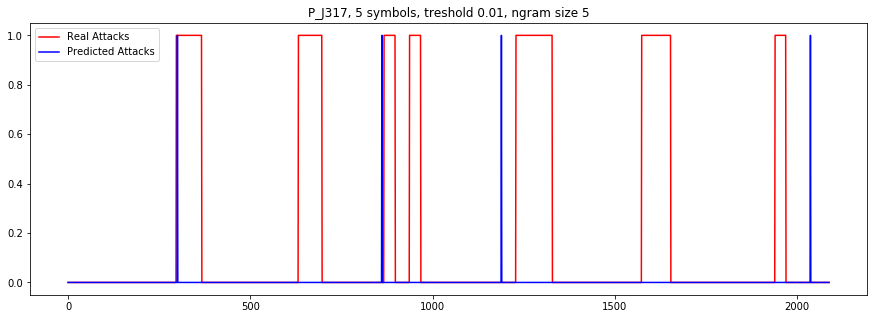

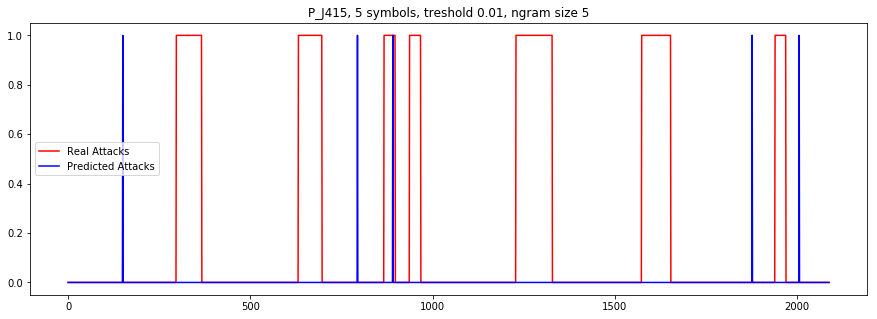

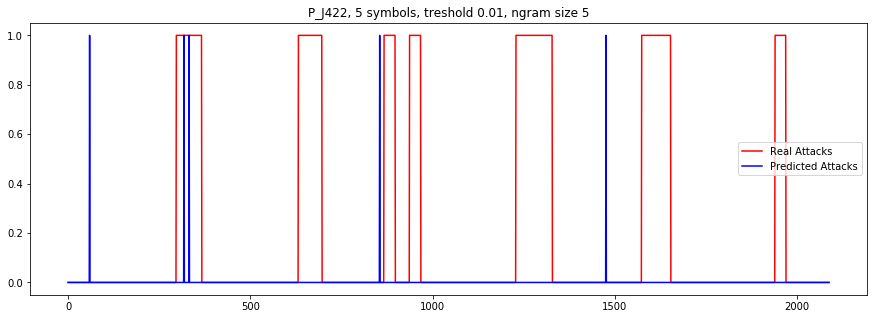

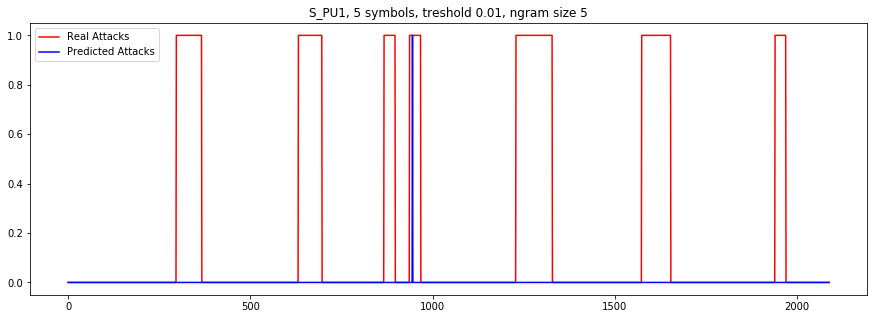

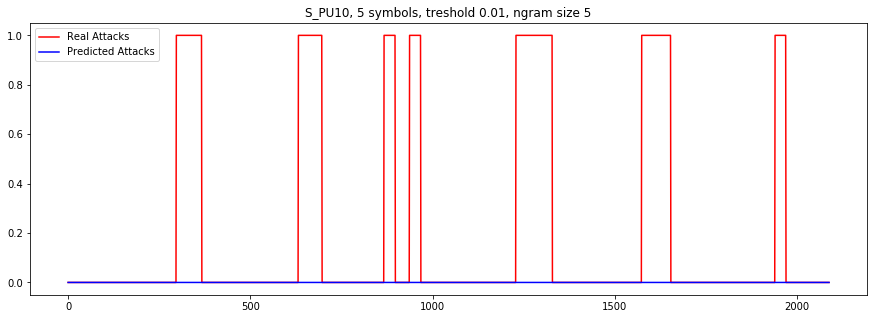

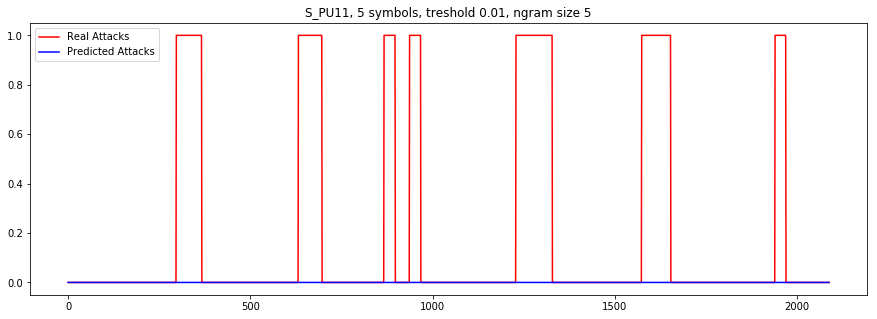

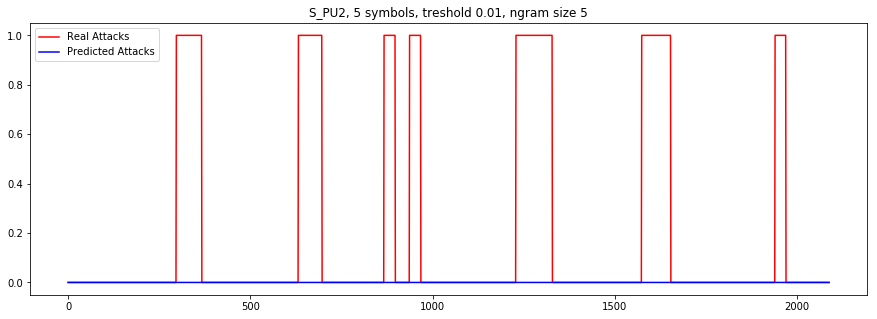

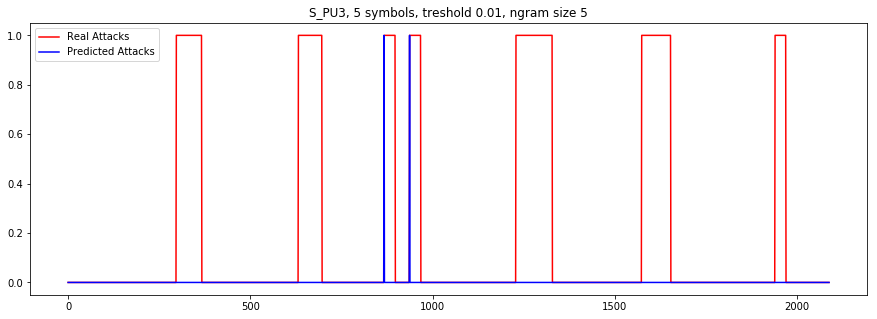

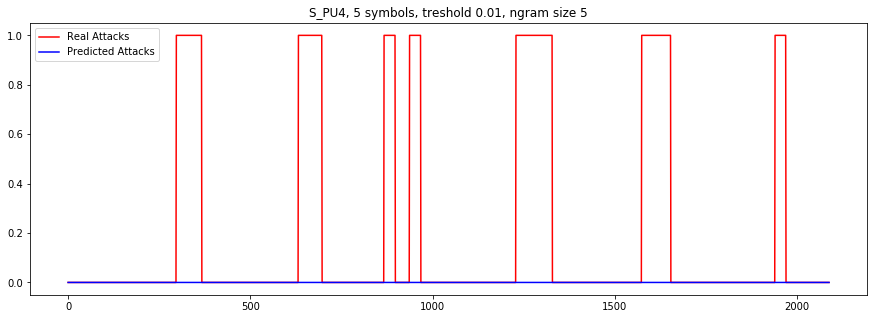

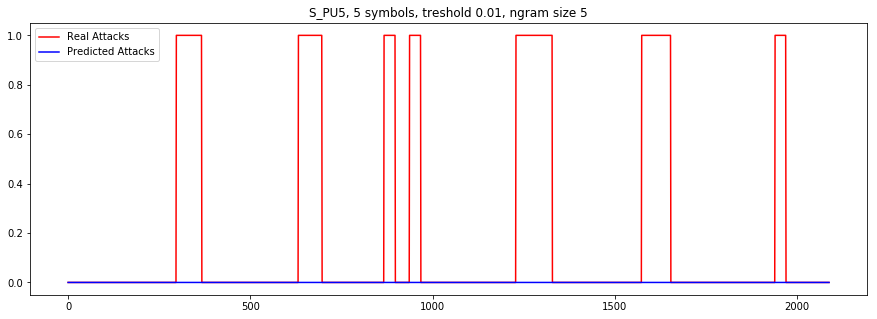

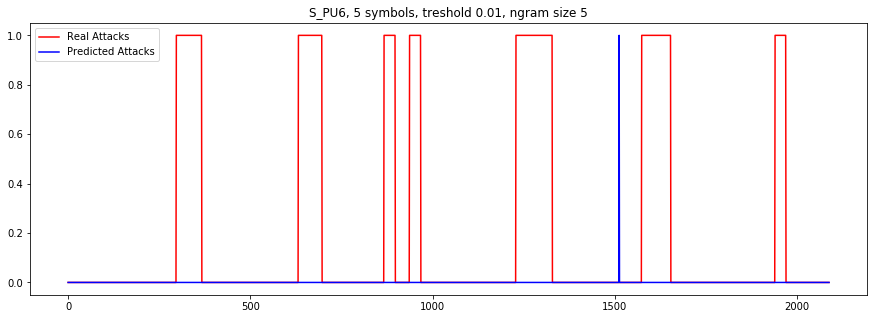

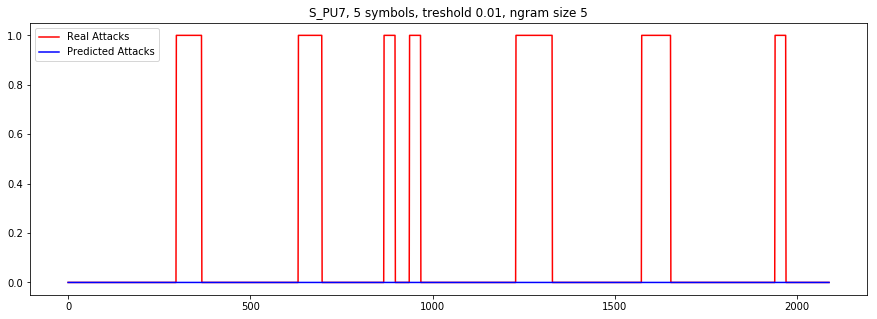

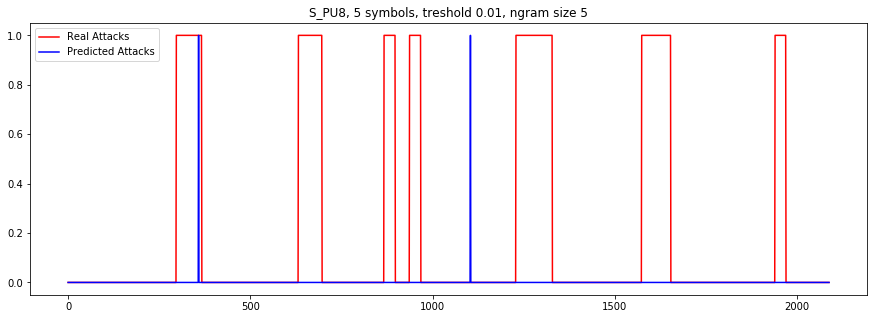

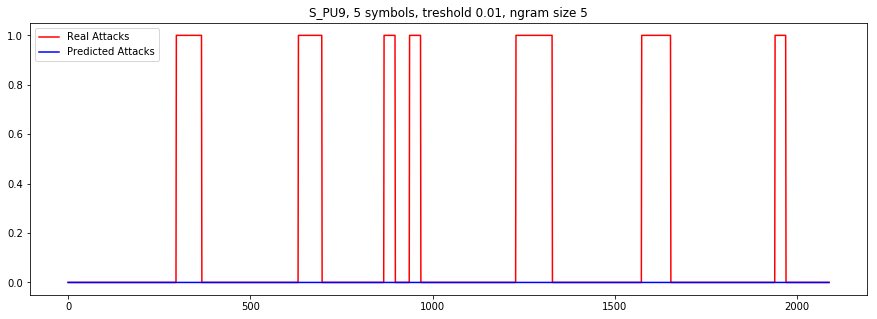

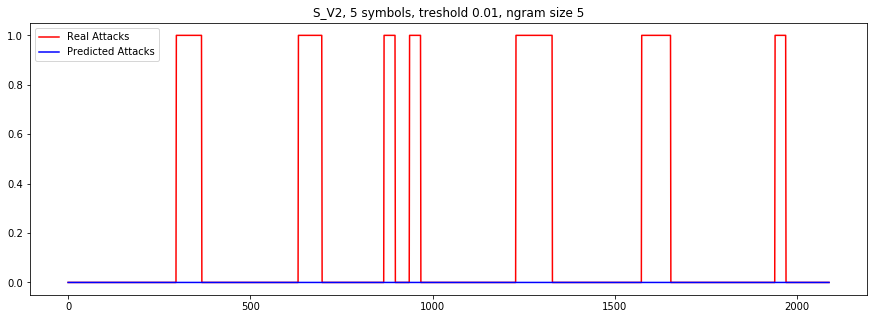

{'ALL': {'DETECTED': 4, 'FP': 4},
 'F_PU': {'DETECTED': 7, 'FP': 47},
 'F_V': {'DETECTED': 1, 'FP': 1},
 'L_T': {'DETECTED': 5, 'FP': 18},
 'P_J': {'DETECTED': 5, 'FP': 34},
 'S_PU': {'DETECTED': 3, 'FP': 2},
 'S_V': {'DETECTED': 0, 'FP': 0}}


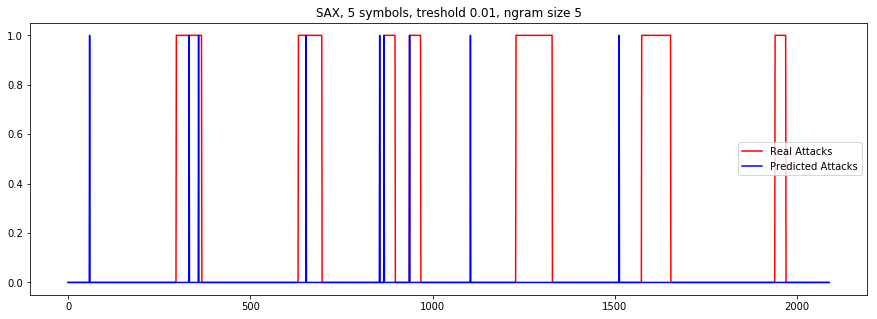

In [16]:
def discretization(training_set, test_set, features, alphabet_size, treshold, n_elements_ngram, pp_treshold,
                   show_single_features=False):
    attacks_in_training = training_set['ATT_FLAG']
    real_attacks = test_set['ATT_FLAG']
    
    predictions = {}
    for feature in features:
        # Just to be sure. We do not want to train on these columns.
        if feature in ['DATETIME', 'ATT_FLAG']:
            continue
            
        # These lines can be used to only look at certain types of sensors.
#         if feature.startswith("L_T"):
#             continue 
#         if feature.startswith("S_PU"):
#             continue
#         if feature.startswith("F_PU"):
#             continue
#         if feature.startswith("S_V"):
#             continue
#         if feature.startswith("F_V"):
#             continue
#         if feature.startswith("P_J"):
#             continue
    
        # Calculate the Symbolic Aggregate approXimation
        sax_training, sax_test = get_sax_data(training_set[feature], test_set[feature], alphabet_size) 
        symbols_training = set(sax_training)
        symbols_test = set(sax_test)
        symbols = symbols_training.union(symbols_test)
        
        # Just to be sure
        if len(symbols) > alphabet_size:
            raise NotImplementedError("Too many symbols!")
        
        predicted_attacks = classify_using_markov_chains(sax_training, attacks_in_training, sax_test, symbols, 
                                                         treshold, n_elements_ngram)
        predictions.update({feature: predicted_attacks})
        
        if show_single_features:
            # Plot the results
            plt.figure(figsize=(15,5))
            plt.plot(real_attacks,'r')
            plt.plot(predicted_attacks, 'b-')

            plot_title = f"{feature}, {alphabet_size} symbols, treshold {treshold}, ngram size {n_elements_ngram}"
            plt.legend(['Real Attacks', 'Predicted Attacks'])
            plt.title(plot_title)
            plt.show()
    
    attacks_predicted = list(predictions.values())
    prediction = attacks_predicted[0]
    if len(features) > 1:
        for p in attacks_predicted[1:]:
            for i, e in enumerate(p):
                if e == VALUE_FOR_ANOMALITY_DETECTED:
                    prediction[i] += VALUE_FOR_ANOMALITY_DETECTED
                    
    combined = [1 if e >= pp_treshold else 0 for e in prediction]
    results = results_of_predictions(predictions, real_attacks, combined, pp_treshold)
    pprint.pprint(results)
    
    plt.figure(figsize=(15,5))
    plt.plot(real_attacks,'r')
    plt.plot(combined, 'b-')
    plot_title = f"SAX, {alphabet_size} symbols, treshold {treshold}, ngram size {n_elements_ngram}"
    plt.legend(['Real Attacks', 'Predicted Attacks'])
    plt.title(plot_title)
#     plt.savefig("all.png")
    plt.show()
    return results, combined
    

# F_PU1 and F_PU7 both detect other anomalies
training_data = data2.append(data, ignore_index = True)
test_data = data3

features = training_data.columns
discretization_dict, discretization_raw = discretization(training_data, test_data, features,
                                                         alphabet_size=5, 
                                                         treshold=0.01, 
                                                         n_elements_ngram=5,
                                                         pp_treshold=3,
                                                         show_single_features=True)

# PCA task

Perform PCA-based anomaly detection on the signal data. Set the threshold on training data to a value that results in few false positives on the training data. Plot the PCA residuals in one signal. Do you see large abnormalities in the training data? Can you explain why these occur? It is best to remove such abnormalities from the training data since you only want to model normal behavior. What kind of anomalies can you detect using PCA?

### Normalize data

In [17]:
train_data = data
test_data1 = data2.drop(columns={'ATT_FLAG'})
test_data2 = data3.drop(columns={'ATT_FLAG'})

att_labels_1 = data2['ATT_FLAG']
att_labels_2 = data3['ATT_FLAG']

pca_labels = train_data.columns
    
# Use a standerd scaler
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data1 = scaler.fit_transform(test_data1)
test_data2 = scaler.fit_transform(test_data2)

### Calculate number of most significant components without removing abnormal data points

In [18]:
new_train = train_data
new_test_1 = test_data1
new_test_2 = test_data2

pca = PCA()
pca.fit(new_train)
expl_var = pca.explained_variance_ratio_

# Sum explained variance
for i in range(1, len(expl_var)+1):
    var_sum = np.sum(expl_var[0:i])
    n_significant = i
    print('first',i,'components explains: ', round(var_sum*100,2),'%')
    if var_sum > 0.99:
        break

first 1 components explains:  21.49 %
first 2 components explains:  34.87 %
first 3 components explains:  47.68 %
first 4 components explains:  57.65 %
first 5 components explains:  64.87 %
first 6 components explains:  71.63 %
first 7 components explains:  77.18 %
first 8 components explains:  82.72 %
first 9 components explains:  86.97 %
first 10 components explains:  90.22 %
first 11 components explains:  92.79 %
first 12 components explains:  95.24 %
first 13 components explains:  97.11 %
first 14 components explains:  98.62 %
first 15 components explains:  99.35 %


### Plot residual error

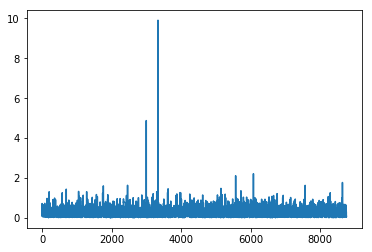

In [19]:
pca = PCA(n_components=n_significant)
pca.fit(new_train)

# transform function returns matrix inf form of [n_samples X n_components]
train_projection = pca.transform(new_train)

# returns components matrix in form of [n_components X n_features]
components = pca.components_

# original data has form [n_samples X n_features]
# recreate data with matrix multiplication of projection and components
train_recreate = np.matmul(train_projection,components)

#calculate squared error for every sample (row)
train_residual_error = np.sum( np.square( np.subtract(new_train, train_recreate) ),axis=1)
plt.plot(train_residual_error)
plt.show()

### Remove abnormal data from the training set

Thresholds:  3.3906177564779783 -3.3906177564779765
Removed rows:  28


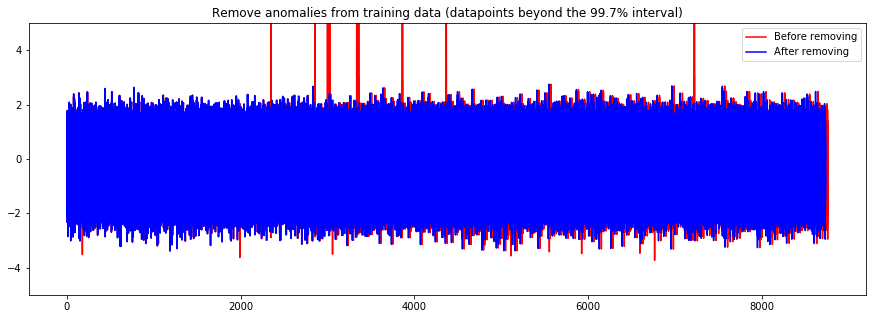

In [20]:
plt.figure(figsize=(15,5))
a = plt.plot(train_data, color='red', label='Before removing')

# calculate an interval (mu + n * sigma) for every feature to remove anomalies from the normal data.
# n = 3 covers 99.7% from the data, n=4 covers 99.99% of the data.
mean_per_col = np.mean(train_data, axis=1)
std_per_col = np.std(train_data, axis=1)
n_std_deviations = 4
interval_upper = mean_per_col + n_std_deviations*std_per_col
interval_lower = mean_per_col - n_std_deviations*std_per_col

#threshold is the mean of the 99.7% feature intervals
threshold_upper = np.mean(interval_upper)
threshold_lower = np.mean(interval_lower)
print('Thresholds: ', threshold_upper, threshold_lower)

# Discard rows that contain abnormal data in the training set.
normalities_in_training_data = []
for row in train_data:
    contains_anomaly = False
    for value in row:
        if value > threshold_upper or value < threshold_lower:
            contains_anomaly = True
    if not contains_anomaly:
        normalities_in_training_data.append(row)

print('Removed rows: ', len(train_data) - len(normalities_in_training_data))
train_data = normalities_in_training_data

### Uncomment the next lines to filter all FEATURES containing abnormal data in the training set
# # append collumn numbers that contains anomalies to list
# abnormalities_in_trainig_data = []
# for row in train_data:
#     for i, cell in enumerate(row):
#         if cell > threshold_upper or cell < threshold_lower:
#             abnormalities_in_trainig_data.append(i)
# abnormalities_in_trainig_data = np.unique(abnormalities_in_trainig_data)
# 
# print('Removed columns:', *itemgetter(abnormalities_in_trainig_data)(pca_labels))
# pca_labels_filtered = np.delete(pca_labels, list(abnormalities_in_trainig_data), axis=0)
# 
# # Remove collumns from training data that contains anomalies
# train_data = np.delete(train_data, list(abnormalities_in_trainig_data), axis=1)
# test_data1 = np.delete(test_data1, list(abnormalities_in_trainig_data), axis=1)
# test_data2 = np.delete(test_data2, list(abnormalities_in_trainig_data), axis=1)

b = plt.plot(train_data, color='blue', label='After removing')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.gca().set_ylim((-5,5))
plt.title('Remove anomalies from training data (datapoints beyond the 99.7% interval)')
plt.show()


### Calculate number of principle comonents to reach a certain threshold

In [21]:
new_train = train_data

new_test_1 = test_data1
new_test_2 = test_data2

pca = PCA()
pca.fit(new_train)
expl_var = pca.explained_variance_ratio_

# Sum explained variance
for i in range(1, len(expl_var)+1):
    var_sum = np.sum(expl_var[0:i])
    n_significant = i
    print('first',i,'components explains: ', round(var_sum*100,2),'%')
    if var_sum > 0.99:
        break

first 1 components explains:  24.23 %
first 2 components explains:  39.28 %
first 3 components explains:  53.69 %
first 4 components explains:  64.89 %
first 5 components explains:  72.95 %
first 6 components explains:  80.51 %
first 7 components explains:  85.31 %
first 8 components explains:  88.98 %
first 9 components explains:  91.87 %
first 10 components explains:  94.65 %
first 11 components explains:  96.75 %
first 12 components explains:  98.45 %
first 13 components explains:  99.28 %


### Reconstruct the test data, plot the residuals and detect anomalies

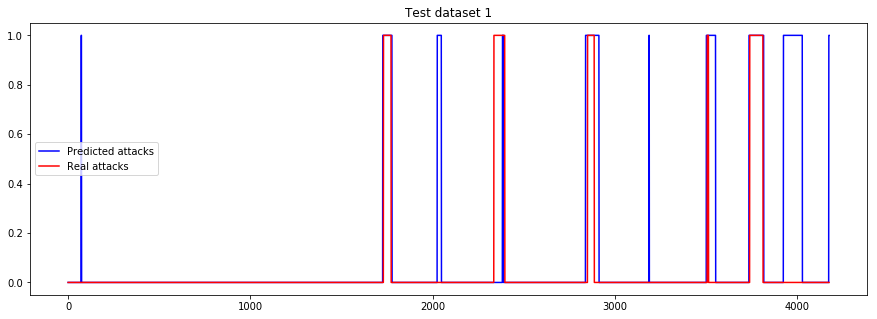

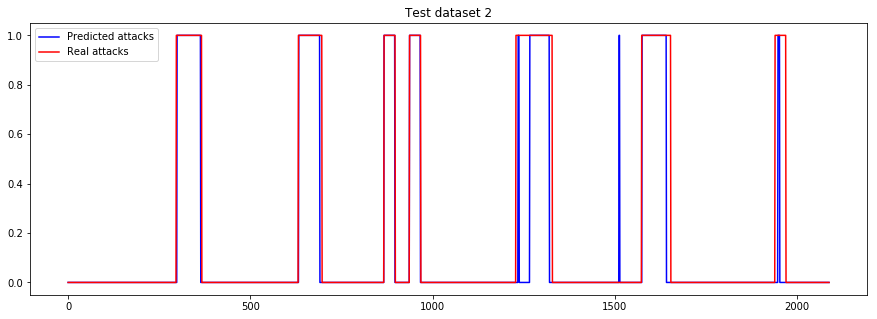

In [25]:
# Initialize PCA() with n components and fit the model with the training data
pca = PCA(n_components=n_significant)
pca.fit(new_train)

# transform function returns matrix inf form of [n_samples X n_components]
train_projection = pca.transform(new_train)
test_projection1 = pca.transform(new_test_1)
test_projection2 = pca.transform(new_test_2)

# returns components matrix in form of [n_components X n_features]
components = pca.components_

# original data has form [n_samples X n_features]
# recreate data with matrix multiplication of projection and components
train_recreate = np.matmul(train_projection,components)
test_recreate1 = np.matmul(test_projection1,components)
test_recreate2 = np.matmul(test_projection2,components)

#calculate squared error for every sample (row)
train_residual_error = np.sum( np.square( np.subtract(new_train, train_recreate) ),axis=1)
test_residual_error1 = np.sum( np.square( np.subtract(new_test_1, test_recreate1) ),axis=1)
test_residual_error2 = np.sum( np.square( np.subtract(new_test_2, test_recreate2) ),axis=1)

pca_threshold = 3

# Decide wheter it is an attack or not
prediction1 = []
for row in test_residual_error1:
    prediction1.append(VALUE_FOR_ANOMALITY_DETECTED if row > pca_threshold else VALUE_FOR_NORMALITY_DETECTED)

# comment to disable grouping
group_attacks(prediction1)

prediction2 = []
for row in test_residual_error2:
    prediction2.append(VALUE_FOR_ANOMALITY_DETECTED if row > pca_threshold else VALUE_FOR_NORMALITY_DETECTED) 

# comment to disable grouping
group_attacks(prediction2)

att_labels_1 = data2['ATT_FLAG']
att_labels_2 = data3['ATT_FLAG']

PLOT_RESIDUALS=False

plt.figure(figsize=(15,5))
if PLOT_RESIDUALS:
    plt.hlines(pca_threshold, 0, len(test_residual_error1), label='Attack threshold', color='green')
    plt.plot(test_residual_error1, label='Residual error', color='cyan')
    plt.gca().set_ylim((-0.2, 7))
    
plt.plot(prediction1, label='Predicted attacks', color='blue',)
plt.plot(att_labels_1, label='Real attacks', color='red')
plt.title('Test dataset 1')
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
if PLOT_RESIDUALS:
    plt.hlines(pca_threshold, 0, len(test_residual_error1), label='Attack threshold', color='green')
    plt.plot(test_residual_error2, label='Residual error', color='cyan')
    plt.gca().set_ylim((-0.2, 7))
plt.plot(prediction2, label='Predicted attacks', color='blue',)
plt.plot(att_labels_2, label='Real attacks', color='red')
plt.title('Test dataset 2')
plt.legend()
plt.show()    

# Comparison task

Compare the performance of the PCA method with the ARMA and discrete models. Comparing anomaly detection methods in not straightforward, and different research studies frequently use different measures. You can either:
* test point-wise precision and recall, or
* overlap-based false and true positives, or /and
* count a true positive if it detects at least one anomaly in an anomalous region, or
* compare the top-k detected anomalies,
* or...

Describe in a few lines which comparison method you chose for this data and why. Keep in mind that
in practice an analyst has to take action on every positive detected, but will not study every detected
data point. Do you recommend using PCA, ARMA, or discrete models?

### Functions used for the comparison

In [26]:
# This method takes a dictionary (feature: prediction) 
# and returns a dictionary with insights per sensor type
def results_of_predictions(predictions, real_attacks, combined, pp_treshold):
    results = {'ALL': {'FP': 0, 'DETECTED': 0}}
    grouped = {'ALL': combined}
    att_ranges = attack_ranges(real_attacks)
    prediction_set = set()
    # Group the predictions per sensor
    for feature, prediction in predictions.items():
        
        if feature.startswith("L_T"):
            sensor_name = "L_T"
        if feature.startswith("S_PU"):
            sensor_name = "S_PU"
        if feature.startswith("F_PU"):
            sensor_name = "F_PU"
        if feature.startswith("S_V"):
            sensor_name = "S_V"
        if feature.startswith("F_V"):
            sensor_name = "F_V"
        if feature.startswith("P_J"):
            sensor_name = "P_J"
            
        if sensor_name not in results:
            results.update({sensor_name: {'FP': 0, 'DETECTED': 0}})
            grouped.update({sensor_name: prediction})
            
        grouped_prediction = grouped[sensor_name]
        for i, p in enumerate(prediction):
            prediction_set.add(p)
            if p == 1:
                grouped_prediction[i] = 1
       
    # Process FP and detection rates
    for sensor_name, prediction in grouped.items():
        # Find the False Positives
        for i, p in enumerate(prediction):
            r = real_attacks[i]
            if r == VALUE_FOR_NORMALITY_DETECTED and p == VALUE_FOR_ANOMALITY_DETECTED:
                results[sensor_name]['FP'] += 1
                
        # Calculate the detection rate
        for (start, end) in att_ranges:
            prediction_range = prediction[start:end]
            if VALUE_FOR_ANOMALITY_DETECTED in prediction_range:
                first_index = None
                for j in range(start, end+1):
                    e = prediction[j]
                    if e == VALUE_FOR_ANOMALITY_DETECTED:
                        first_index = j
                        break
                fraction_detected = 1 - ((first_index - start) / (end-start + 1))
                results[sensor_name]['DETECTED'] += fraction_detected
        results[sensor_name]['DETECTED'] = round(results[sensor_name]['DETECTED'], 2)
    return results 


# This method returns the ranges of attacks happening in a list containing the attacks.
def attack_ranges(attacks):
    treshold_for_attack = 0.1
    ranges = []
    ctr = 0
    att_start = None
    while ctr < len(attacks):
        e = attacks[ctr]
        if e > treshold_for_attack:
            att_start = ctr
            while e > treshold_for_attack:
                ctr += 1
                e = attacks[ctr]
            att_stop = ctr - 1
            ranges.append((att_start, att_stop))
        else:
            ctr += 1
    return ranges


def extract_results_per_sensor_arma(prediction_per_sensor, real_attacks, pp_treshold):
    predictions = {}
    for feature, predicted_attacks in prediction_per_sensor.items():
        predictions.update({feature: predicted_attacks})
    
    attacks_predicted = list(predictions.values())
    prediction = attacks_predicted[0]
    if len(features) > 1:
        for p in attacks_predicted[1:]:
            for i, e in enumerate(p):
                if e == VALUE_FOR_ANOMALITY_DETECTED:
                    prediction[i] = VALUE_FOR_ANOMALITY_DETECTED
                    
    combined = [1 if e >= pp_treshold else 0 for e in prediction]
    results = results_of_predictions(predictions, real_attacks, combined, pp_treshold=pp_treshold)
    return results, combined


def extract_results_per_sensor_dis(predictions, real_attacks, pp_treshold):    
    print(predictions.keys())
    attacks_predicted = list(predictions.values())
    prediction = attacks_predicted[0]
    if len(features) > 1:
        for p in attacks_predicted[1:]:
            for i, e in enumerate(p):
                if e == VALUE_FOR_ANOMALITY_DETECTED:
                    prediction[i] = VALUE_FOR_ANOMALITY_DETECTED
                    
    combined = [1 if e >= pp_treshold else 0 for e in prediction]
    print(sum(combined))
    results = results_of_predictions(predictions, real_attacks, combined, pp_treshold=pp_treshold)
    return results

### The comparison

ARMA:  {'FP': 9, 'DETECTED': 5.02}
Discretization:  {'FP': 4, 'DETECTED': 4}
PCA:  {'FP': 2, 'DETECTED': 6.62}
Combination:  {'FP': 12, 'DETECTED': 6.68}


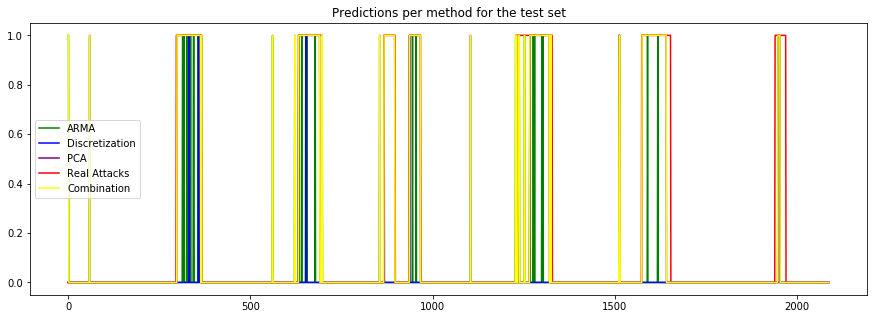

In [27]:
# Because Arma would take too long to execute
# Contains a dictionary with the raw prediction per sensor.
arma_load = np.load('arma_predictions.npy', allow_pickle=True).item()
arma_predictions, raw_arma = extract_results_per_sensor_arma(arma_load, data3['ATT_FLAG'], 1)

# Contains a dict with the results per sensor
# discretization_predictions = extract_results_per_sensor_dis(discretization_results, data3['ATT_FLAG'], 2)
# print(discretization_predictions.keys())
discretization_predictions = discretization_dict
raw_discretization = discretization_raw

# Contains the prediction for all sensors together
raw_pca = prediction2
pca_predictions = results_of_predictions({}, data3['ATT_FLAG'], raw_pca, 1)

raw_all = []
for i in range(len(raw_pca)):
    if VALUE_FOR_ANOMALITY_DETECTED in [raw_arma[i], raw_pca[i], raw_discretization[i]]:
        raw_all.append(VALUE_FOR_ANOMALITY_DETECTED)
    else:
        raw_all.append(VALUE_FOR_NORMALITY_DETECTED)
all_predictions = results_of_predictions({}, data3['ATT_FLAG'], raw_all, 1)

print('ARMA: ', arma_predictions['ALL'])
print('Discretization: ', discretization_predictions['ALL'])
print('PCA: ', pca_predictions['ALL'])
print('Combination: ', all_predictions['ALL'])

plt.figure(figsize=(15,5))
plt.plot(raw_arma, label='ARMA', color='green')
plt.plot(raw_discretization, label='Discretization', color='blue',)
plt.plot(raw_pca, label='PCA', color='purple')
plt.plot(data3['ATT_FLAG'], label='Real Attacks', color='red')
plt.plot(raw_all, label='Combination', color='yellow')

plt.title('Predictions per method for the test set')
plt.legend()
plt.show()  